In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os,sys
from scipy import stats
from collections import Counter
plt.style.use('seaborn-white')

In [3]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=3,2
plt.rcParams['figure.dpi']=300
plt.rcParams['axes.linewidth'] =1
plt.rcParams['lines.linewidth'] =1
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# set font size
SMALL_SIZE = 7
MEDIUM_SIZE = 8
LARGE_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=1) 
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

In [4]:
print(sys.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:51:59) 
[Clang 14.0.6 ]


In [6]:
%pip list | grep -e "numpy" -e "pandas" -e "matplotlib" -e "scipy" -e 'seaborn'

matplotlib                    3.4.3
matplotlib-inline             0.1.3
matplotlib-venn               0.11.6
numpy                         1.20.3
pandas                        1.3.4
scipy                         1.7.2
seaborn                       0.11.2
Note: you may need to restart the kernel to use updated packages.


# Broad

In [7]:
df=pd.read_csv('../processed/CCLE_integrated_broad.txt',sep='\t',index_col=0)

/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (22,23,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
df['HRD_score_broad']=df['HRD_score']

In [9]:
brca1_met=[]
for idx in df.index:
    if df.loc[idx,'BRCA1_methylation_broad']==1:
        brca1_met.append(1)
    elif df.loc[idx,'BRCA1_methylation_cosmic_likely']==1:
        brca1_met.append(1)
    elif df.loc[idx,'BRCA1_methylation_broad']==0:
        brca1_met.append(0)
    elif df.loc[idx,'BRCA1_methylation_cosmic_likely']==0:
        brca1_met.append(0)
    else:
        brca1_met.append(np.nan)
df['BRCA1_methylation']=brca1_met

In [10]:
brca_status=[]
for idx in df.index:
    if df.loc[idx,'BRCA1']=='LOH':
        brca_status.append('BRCA1_LOH')
    elif df.loc[idx,'BRCA2']=='LOH':
        brca_status.append('BRCA2_LOH')
    elif df.loc[idx,'BRCA2']=='LOH':
        brca_status.append('BRCA2_LOH')
    elif df.loc[idx,'BRCA1_methylation']==1:
        brca_status.append('BRCA1_methylation')
    elif df.loc[idx,'otherHRR_LOH']==1:
        brca_status.append('HRR_LOH')
    elif df.loc[idx,'BRCA1']=='unknown':
        brca_status.append('BRCA1_unknown')
    elif df.loc[idx,'otherHRR_unknown']==1:
        brca_status.append('HRR_unknown')
    elif df.loc[idx,'BRCA1']=='nonLOH':
        brca_status.append('BRCA1_nonLOH')
    elif df.loc[idx,'BRCA2']=='nonLOH':
        brca_status.append('BRCA2_nonLOH')
    elif df.loc[idx,'otherHRR_nonLOH']==1:
        brca_status.append('HRR_nonLOH')
    elif (df.loc[idx,'BRCA1']=='wt')&(df.loc[idx,'BRCA2']=='wt')&(df.loc[idx,'BRCA1_methylation']==0):
        brca_status.append('wt')
    else:
        brca_status.append(np.nan)

In [11]:
df['BRCA_status']=brca_status

In [12]:
Counter(df['BRCA_status']).most_common()

[('wt', 904),
 (nan, 559),
 ('HRR_nonLOH', 180),
 ('HRR_LOH', 60),
 ('HRR_unknown', 48),
 ('BRCA2_nonLOH', 47),
 ('BRCA1_nonLOH', 12),
 ('BRCA1_LOH', 10),
 ('BRCA2_LOH', 9),
 ('BRCA1_methylation', 8),
 ('BRCA1_unknown', 2)]

In [13]:
Counter(df['BRCA_status']).most_common()

[('wt', 904),
 (nan, 559),
 ('HRR_nonLOH', 180),
 ('HRR_LOH', 60),
 ('HRR_unknown', 48),
 ('BRCA2_nonLOH', 47),
 ('BRCA1_nonLOH', 12),
 ('BRCA1_LOH', 10),
 ('BRCA2_LOH', 9),
 ('BRCA1_methylation', 8),
 ('BRCA1_unknown', 2)]

In [14]:
df=df[(df['BRCA_status'].isna()==False)]
#df=df[~df['BRCA_status'].isin(['HRR_unknown','BRCA1_unknown'])]
df.shape

(1280, 1034)

In [15]:
df['BRCA_alteration']=((df['BRCA1_LOH']==1)|(df['BRCA1_methylation']==1)|(df['BRCA2_LOH']==1)).astype(int)

In [16]:
df['BRCA_alteration'].sum()

27

In [17]:
(~df['HRD_score_broad'].isna()).sum()

914

In [18]:
(~df['SigMA_broad'].isna()).sum()

1280

In [19]:
df0=df.copy()

### drug annotation

In [20]:
drug_gdsc1=set(df.columns[df.columns.str.startswith('GDSC1')])
drug_gdsc2=set(df.columns[df.columns.str.contains('GDSC2')])
drug_ctrp1=set(df.columns[df.columns.str.contains('CTRP1')])
drug_ctrp2=set(df.columns[df.columns.str.contains('CTRP2')])
drug_prism=set(df.columns[df.columns.str.startswith("PRISM")])
drug_gcsi=set(df.columns[df.columns.str.contains('gCSI')])

In [21]:
drug_all_set=drug_gdsc1|drug_gdsc2|drug_ctrp1|drug_ctrp2|drug_prism|drug_gcsi
len(drug_all_set)

882

In [22]:
drug_anno=pd.read_csv('../processed/Drug_annotaion_integrated.txt'
                      ,sep='\t',index_col=0)
drug_anno['cid']=drug_anno['cid'].astype(int)

In [23]:
df_drug=df[~df[drug_all_set].isna().all(axis=1)]

In [24]:
df_drug.shape

(1182, 1035)

## BRCA status vs Drug sensitivity

In [25]:
from statsmodels.stats.multitest import multipletests

In [26]:
drug_all=[]
for x in drug_all_set:
    if 'C50' in x:
        continue
    else:
        drug_all.append(x)

In [27]:
drug_all=sorted(drug_all)

In [28]:
len(drug_all)

882

In [29]:
platinums=set(df_drug.columns[(df_drug.columns.str.contains('platin'))])
platinums

{'CTRP2_carboplatin_26979',
 'CTRP2_oxaliplatin_375582',
 'GDSC1_Cisplatin_1005',
 'GDSC2_Cisplatin_1005',
 'GDSC2_Oxaliplatin_1089',
 'GDSC2_Oxaliplatin_1806',
 'PRISM_carboplatin_BRD-K90947825-001-02-7',
 'PRISM_cisplatin_BRD-K69172251-001-08-9',
 'PRISM_oxaliplatin_BRD-K78960041-001-05-7',
 'gCSI_Cisplatin_CID24191118'}

In [30]:
parpis=set(df_drug.columns[(df_drug.columns.str.contains('parib'))])
parpis

{'CTRP1_olaparib_411867',
 'CTRP1_rucaparib_628605',
 'CTRP1_veliparib_606034',
 'CTRP2_olaparib_411867',
 'CTRP2_veliparib_606034',
 'GDSC1_Olaparib_1017',
 'GDSC1_Olaparib_1495',
 'GDSC1_Rucaparib_1175',
 'GDSC1_Talazoparib_1259',
 'GDSC1_Veliparib_1018',
 'GDSC2_Niraparib_1177',
 'GDSC2_Olaparib_1017',
 'GDSC2_Talazoparib_1259',
 'PRISM_niraparib_BRD-K54955827-001-02-2',
 'PRISM_olaparib_BRD-K02113016-001-15-4',
 'PRISM_olaparib_BRD-K02113016-001-19-6',
 'PRISM_talazoparib_BRD-K95142244-001-01-5'}

### BRCA12 altaration

In [31]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH']).sum()

25

In [32]:
df_drug[~df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH'])].shape

(1157, 1035)

In [33]:
df_drug[df_drug['BRCA_status'].isin(['wt'])].shape

(872, 1035)

In [34]:
df=df_drug.copy()

In [35]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
n_limit=7
for drug in drug_all:
    a=df[df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH'])][drug].dropna().values
    b=df[df['BRCA_status'].isin(['wt'])][drug].dropna().values
    n=len(a)
    if n> n_limit:
        r,p=stats.mannwhitneyu(a,b)
        m=np.median(a)-np.median(b)
        m2=np.mean(a)-np.mean(b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
        ms.append(m)
        ms2.append(m2)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)
        ms.append(np.nan)
        ms2.append(np.nan)

In [36]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps

In [37]:
df_cor=df_cor.dropna()

In [38]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [39]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
CTRP2_ABT-199_666541,10.0,0.478000,0.597583,0.466985,0.330697,0,Apoptosis regulation,49846579
CTRP2_ABT-737_411738,17.0,-0.243000,0.485008,0.856060,0.067496,0,Apoptosis regulation,11228183
CTRP2_AT13387_688229,11.0,0.583100,0.541504,0.417579,0.379261,0,Others,11955716
CTRP2_AZD1480_660306,9.0,0.455000,0.384669,0.459549,0.337668,0,Others,16659841
CTRP2_AZD4547_660325,15.0,0.620500,1.011457,0.009262,2.033288,1,RTK signaling,51039095
...,...,...,...,...,...,...,...,...
gCSI_PF-4708671_CID51371303,10.0,-0.026500,-0.023852,0.224988,0.647841,0,PI3K/MTOR signaling,51371303
gCSI_Paclitaxel_CID36314,10.0,0.090000,0.029602,0.600961,0.221154,0,Antimicrotubule,36314
gCSI_Tivantinib_CID11494412,10.0,-0.048444,-0.070090,0.125992,0.899658,0,Others,11494412
gCSI_Vincristine_CID5978,10.0,-0.019556,-0.016602,0.763421,0.117236,0,Others,5978


In [40]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
GDSC2_Foretinib_2040,17.0,0.088439,0.106701,0.000118,3.926293,1,RTK signaling,42642645
GDSC1_Vorinostat_1012,20.0,0.095145,0.095242,0.000427,3.369581,1,Chromatin-related,5311
GDSC2_Luminespib_1559,17.0,0.148574,0.110782,0.002511,2.600183,1,Protein stability and degradation,10096043
CTRP2_MGCD-265_628622,18.0,0.477500,0.947430,0.003304,2.480915,1,Others,24901704
CTRP2_barasertib_601923,18.0,0.781500,2.112513,0.003751,2.425845,1,Others,11497983
...,...,...,...,...,...,...,...,...
GDSC1_WHI-P97_288,20.0,-0.015036,-0.019245,0.009127,2.039667,1,Others,3796
GDSC1_Afatinib_1377,20.0,-0.049040,-0.048723,0.003309,2.480291,1,EGFR signaling,10184653
GDSC1_IOX2_1230,19.0,-0.006299,-0.001379,0.002341,2.630586,1,Others,54685215
gCSI_JQ1 compound_CID71300862,12.0,-0.055889,-0.074094,0.001909,2.719162,1,Others,71300862


In [41]:
NP=len(df_cor_p)
NN=len(df_cor_n)

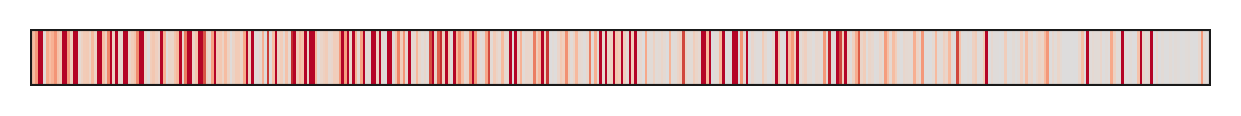

In [42]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

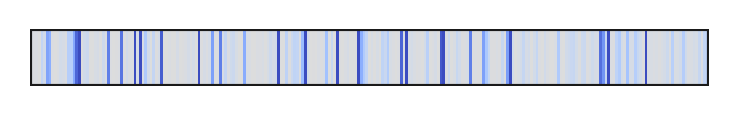

In [43]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

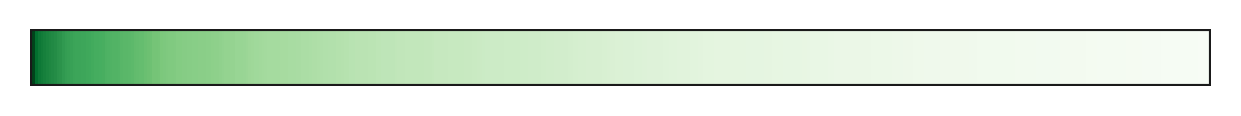

In [44]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

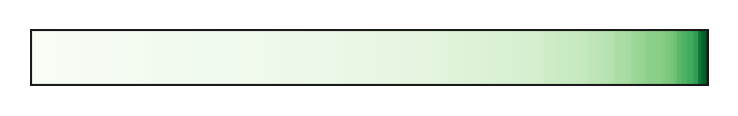

In [45]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

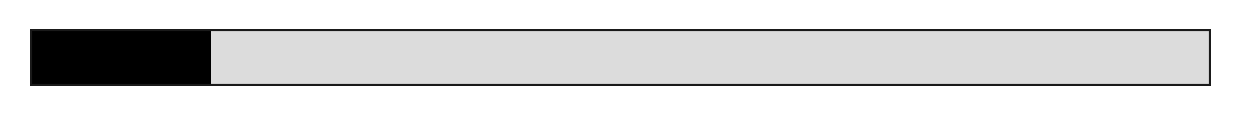

In [46]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

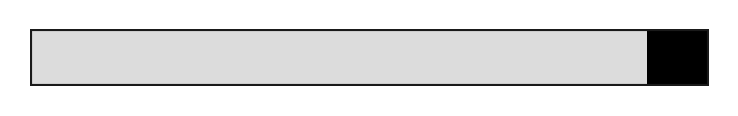

In [47]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [48]:
counter=Counter(df_cor_pn['drug_anno']).most_common()

In [49]:
a=[x[0] for x in counter]
a

['Others',
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'ERK MAPK signaling',
 'DNA inhibitor',
 'Antimetabolite',
 'EGFR signaling',
 'Antimicrotubule',
 'Cell cycle',
 'Apoptosis regulation',
 'Hormone-related',
 'Protein stability and degradation',
 'DNA alkylator',
 'PARP inhibitor',
 'Topoisomerase inhibitor',
 'WNT signaling',
 'Platinum',
 'Metabolism',
 'Genome integrity',
 'p53 pathway',
 'IGF1R signaling',
 'Cytoskeleton',
 'JNK and p38 signaling']

In [50]:
drug_order=[ 'Platinum',  'PARP inhibitor',  'Topoisomerase inhibitor',
 'DNA alkylator','DNA inhibitor', 'Antimetabolite', 
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'ERK MAPK signaling',
 'Cell cycle',
 'Antimicrotubule', 
 'Protein stability and degradation',
 'Apoptosis regulation',
 'EGFR signaling',
 'WNT signaling',
 'Genome integrity',
 'Metabolism',
 'Hormone-related',
 'IGF1R signaling',
 'p53 pathway',
 'Cytoskeleton',
 'JNK and p38 signaling']

In [51]:
anno_platinum=[]
for index in df_cor_pn.index:
    if 'isplatin' in index:
        anno_platinum.append(1)
    elif 'arboplatin' in index:
        anno_platinum.append(3)
    elif 'xaliplatin' in index:
        anno_platinum.append(2)
    else:
        anno_platinum.append(0)
df_cor_pn['platinum_color']=anno_platinum

In [52]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

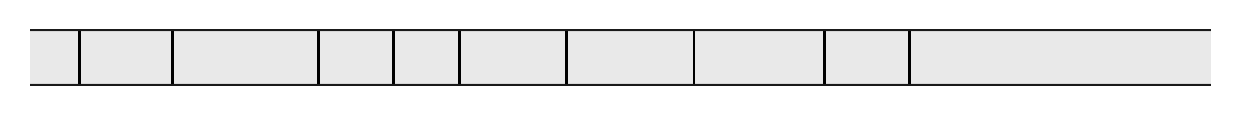

In [53]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [54]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

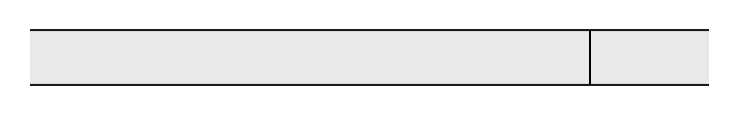

In [55]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [56]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

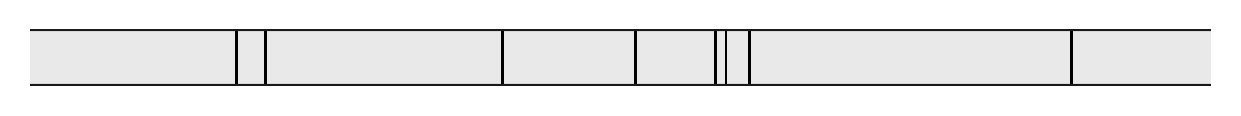

In [57]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


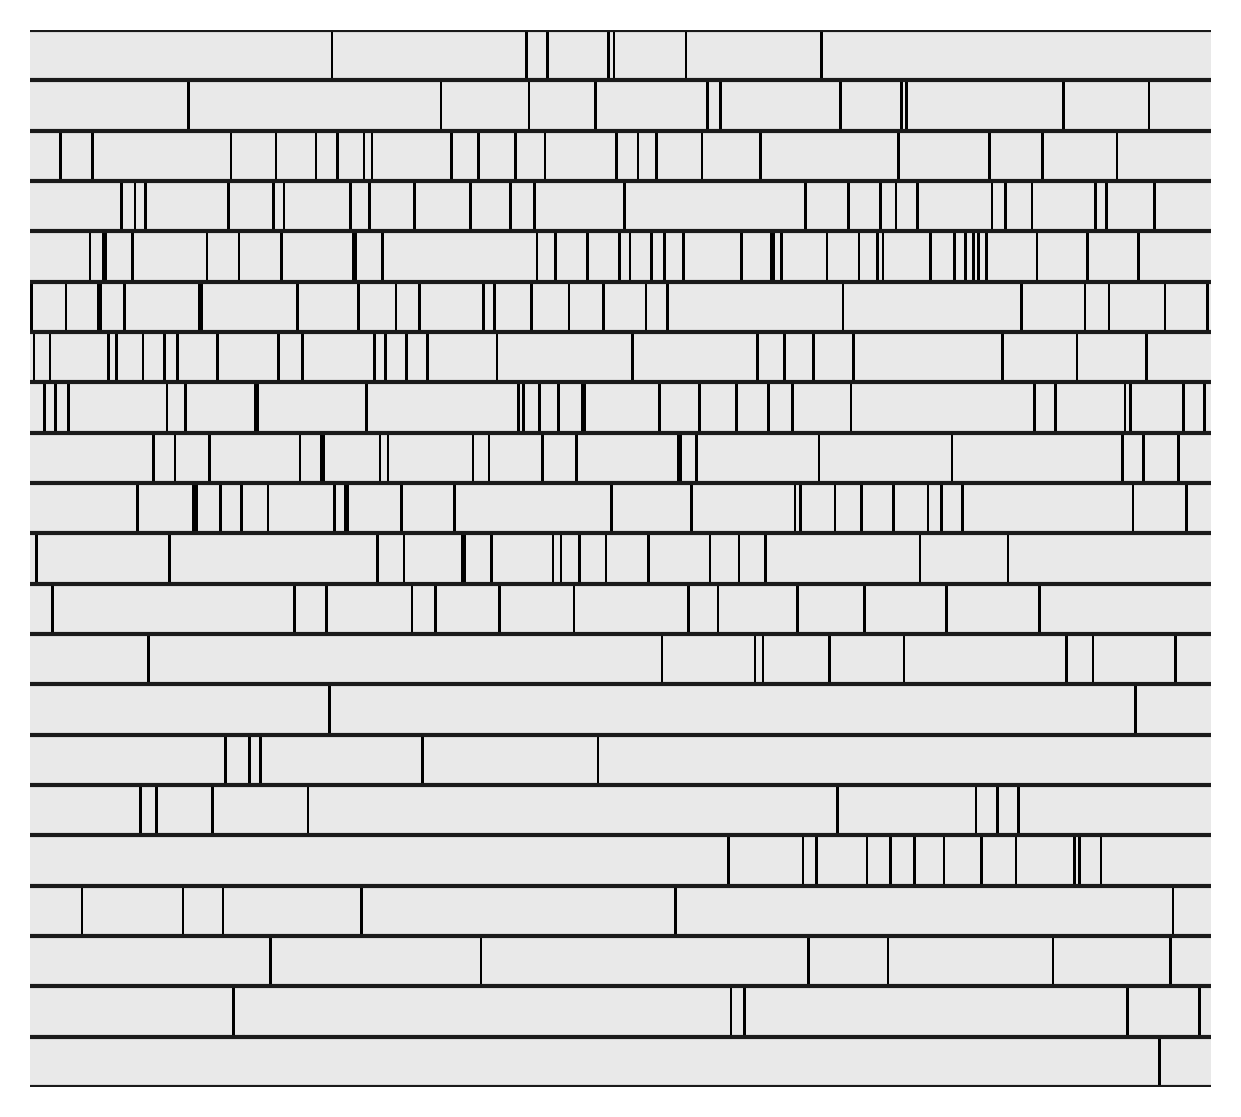

In [58]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [59]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

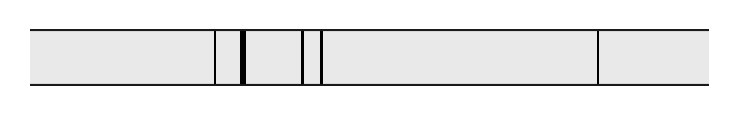

In [60]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


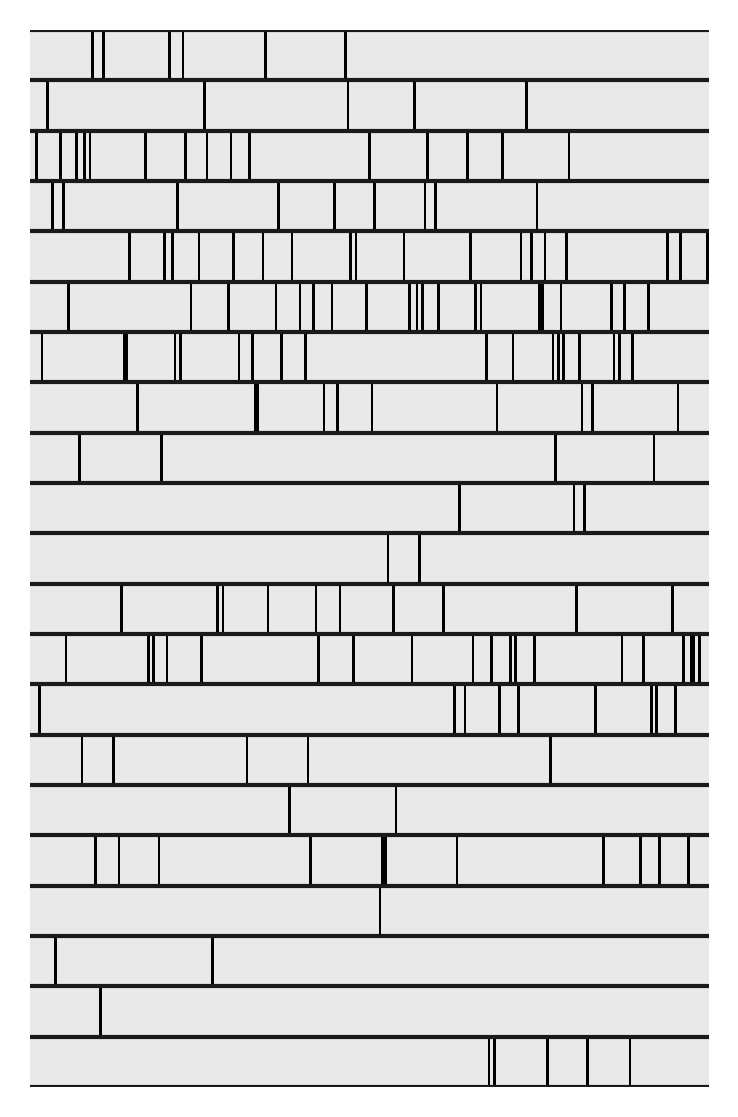

In [61]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

In [62]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_25472/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,platinum_color,FDR
GDSC2_Oxaliplatin_1089,16.0,0.017722,0.043411,0.011562,1.936967,1,Platinum,5310940,2,0.115620
GDSC2_Cisplatin_1005,17.0,0.031376,0.039406,0.039501,1.403389,1,Platinum,84691,1,0.197506
GDSC2_Oxaliplatin_1806,15.0,0.009080,0.028683,0.101070,0.995380,0,Platinum,5310940,2,0.293613
GDSC1_Cisplatin_1005,20.0,0.009872,0.028787,0.146806,0.833255,0,Platinum,84691,1,0.293613
CTRP2_carboplatin_26979,18.0,0.166000,0.256969,0.177170,0.751610,0,Platinum,38904,3,0.295283
CTRP2_oxaliplatin_375582,18.0,0.163000,0.464937,0.245012,0.610813,0,Platinum,24197464,2,0.350017
gCSI_Cisplatin_CID24191118,10.0,0.052556,0.020534,0.384477,0.415130,0,Platinum,24191118,1,0.480596
PRISM_carboplatin_BRD-K90947825-001-02-7,10.0,0.148143,0.076457,0.514545,0.288576,0,Platinum,426756,3,0.571717
PRISM_oxaliplatin_BRD-K78960041-001-05-7,11.0,0.018087,0.012186,0.642571,0.192079,0,Platinum,24197464,2,0.642571
PRISM_cisplatin_BRD-K69172251-001-08-9,11.0,-0.013422,-0.091784,0.146546,0.834026,0,Platinum,24191118,1,0.293613


In [63]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_25472/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,platinum_color,FDR
PRISM_olaparib_BRD-K02113016-001-19-6,11.0,0.059524,0.043416,0.062463,1.204377,0,PARP inhibitor,23725625,0,0.563420
GDSC2_Niraparib_1177,15.0,0.005434,0.028097,0.080489,1.094266,0,PARP inhibitor,24958200,0,0.563420
PRISM_talazoparib_BRD-K95142244-001-01-5,12.0,0.095889,0.043518,0.209066,0.679716,0,PARP inhibitor,135565082,0,0.731732
CTRP2_olaparib_411867,18.0,0.339500,0.242052,0.323061,0.490716,0,PARP inhibitor,23725625,0,0.742701
PRISM_niraparib_BRD-K54955827-001-02-2,12.0,0.013989,0.027824,0.410650,0.386528,0,PARP inhibitor,24958200,0,0.742701
GDSC2_Talazoparib_1259,16.0,0.001030,0.065922,0.413839,0.383168,0,PARP inhibitor,44819241,0,0.742701
GDSC1_Rucaparib_1175,20.0,0.001260,0.000517,0.424401,0.372224,0,PARP inhibitor,9931953,0,0.742701
GDSC1_Talazoparib_1259,20.0,0.004271,0.040311,0.814607,0.089052,0,PARP inhibitor,44819241,0,0.814607
GDSC2_Olaparib_1017,17.0,-0.002356,0.003897,0.728996,0.137275,0,PARP inhibitor,23725625,0,0.785073
GDSC1_Veliparib_1018,20.0,-0.001277,0.001672,0.702937,0.153084,0,PARP inhibitor,11960529,0,0.785073


### HRR alteration

In [64]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH']).sum()

82

In [65]:
df_drug[~df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])].shape

(1100, 1035)

In [66]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
n_limit=7
for drug in drug_all:
    a=df[df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
#    b=df[~df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
    b=df[df['BRCA_status'].isin(['wt'])][drug].dropna().values
    n=len(a)
    if n> n_limit:
        r,p=stats.mannwhitneyu(a,b)
#        r,p=stats.brunnermunzel(a,b)
        m=np.median(a)-np.median(b)
        m2=np.mean(a)-np.mean(b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
        ms.append(m)
        ms2.append(m2)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)
        ms.append(np.nan)
        ms2.append(np.nan)

In [67]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps

In [68]:
df_cor=df_cor.dropna()

In [69]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [70]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
CTRP1_2-deoxyglucose_347781,8.0,-0.108900,0.014045,0.962055,0.016800,0,Others,439268
CTRP1_ABT-737_411738,15.0,0.030400,0.208758,0.936654,0.028421,0,Apoptosis regulation,11228183
CTRP1_ABT-751_417983,14.0,-0.854150,-0.197553,0.667641,0.175457,0,Antimicrotubule,3035714
CTRP1_BI-2536_347813,9.0,-1.171300,-0.816788,0.140279,0.853007,0,Cell cycle,11364421
CTRP1_BMS-641988_411807,15.0,-0.140200,-0.048310,0.390704,0.408153,0,Hormone-related,24768935
...,...,...,...,...,...,...,...,...
gCSI_TGX221_CID9907093,11.0,0.073444,0.030786,0.259578,0.585732,0,PI3K/MTOR signaling,9907093
gCSI_Tivantinib_CID11494412,36.0,-0.014444,-0.009588,0.640069,0.193773,0,Others,11494412
gCSI_Vincaleukoblastine_CID241902,10.0,0.042500,0.009649,0.525638,0.279313,0,Antimicrotubule,241902
gCSI_Vincristine_CID5978,36.0,-0.025167,-0.003510,0.993737,0.002729,0,Others,5978


In [71]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
GDSC2_Buparlisib_1873,56.0,0.032389,0.030116,0.000450,3.346926,1,PI3K/MTOR signaling,16654980
GDSC1_Vorinostat_1012,64.0,0.050680,0.056461,0.000873,3.059176,1,Chromatin-related,5311
GDSC2_BMS-536924_1091,56.0,0.030580,0.048086,0.000883,3.053816,1,IGF1R signaling,10390396
CTRP2_COL-3_665914,45.0,0.683000,0.670939,0.001235,2.908296,1,Others,54678924
GDSC2_MG-132_1862,57.0,0.037413,0.047152,0.001311,2.882503,1,Protein stability and degradation,462382
...,...,...,...,...,...,...,...,...
GDSC1_Cetuximab_1114,56.0,-0.008850,-0.002537,0.018021,1.744215,1,EGFR signaling,85668777
GDSC1_CGP-082996_54,21.0,-0.042919,-0.029612,0.016716,1.776858,1,Cell cycle,24825971
GDSC1_Sorafenib_30,23.0,-0.050612,-0.025775,0.012357,1.908071,1,RTK signaling,216239
GDSC1_Doramapimod_1042,64.0,-0.010748,-0.005039,0.004896,2.310169,1,JNK and p38 signaling,156422


In [72]:
NP=len(df_cor_p)
NN=len(df_cor_n)

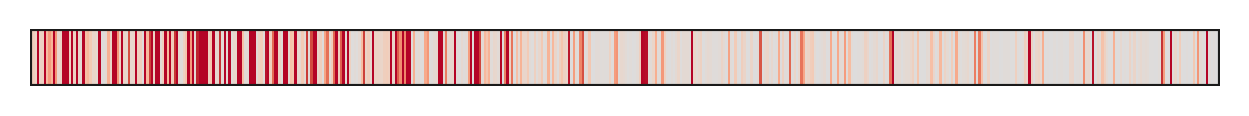

In [73]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

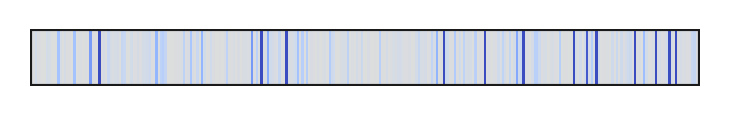

In [74]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

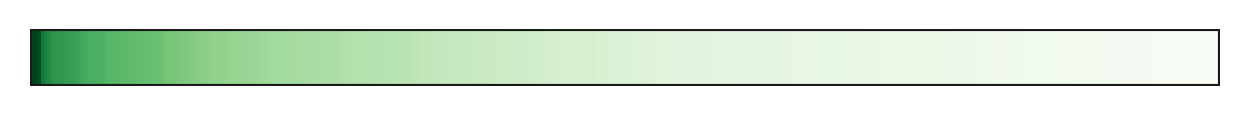

In [75]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

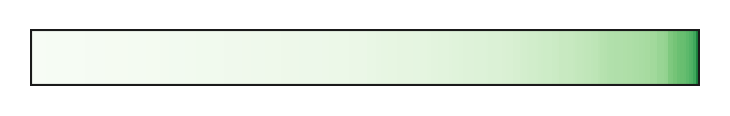

In [76]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

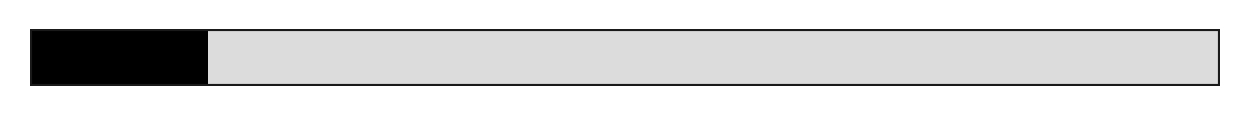

In [77]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

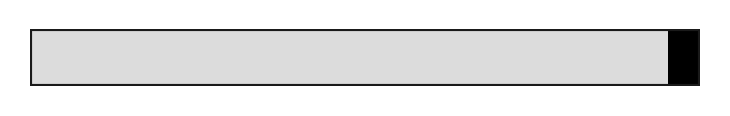

In [78]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [79]:
counter=Counter(df_cor_pn['drug_anno']).most_common()

In [80]:
a=[x[0] for x in counter]
a

['Others',
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'DNA inhibitor',
 'ERK MAPK signaling',
 'Antimetabolite',
 'Cell cycle',
 'Antimicrotubule',
 'EGFR signaling',
 'Apoptosis regulation',
 'Hormone-related',
 'Protein stability and degradation',
 'DNA alkylator',
 'PARP inhibitor',
 'Topoisomerase inhibitor',
 'Genome integrity',
 'WNT signaling',
 'Metabolism',
 'Platinum',
 'IGF1R signaling',
 'Cytoskeleton',
 'p53 pathway',
 'JNK and p38 signaling']

In [81]:
drug_order=[ 'Platinum',  'PARP inhibitor',  'Topoisomerase inhibitor',
 'DNA alkylator','DNA inhibitor', 'Antimetabolite', 
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'ERK MAPK signaling',
 'Cell cycle',
 'Antimicrotubule', 
 'Protein stability and degradation',
 'Apoptosis regulation',
 'EGFR signaling',
 'WNT signaling',
 'Genome integrity',
 'Metabolism',
 'Hormone-related',
 'IGF1R signaling',
 'p53 pathway',
 'Cytoskeleton',
 'JNK and p38 signaling']

In [82]:
anno_platinum=[]
for index in df_cor_pn.index:
    if 'isplatin' in index:
        anno_platinum.append(1)
    elif 'arboplatin' in index:
        anno_platinum.append(3)
    elif 'xaliplatin' in index:
        anno_platinum.append(2)
    else:
        anno_platinum.append(0)
df_cor_pn['platinum_color']=anno_platinum

In [83]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

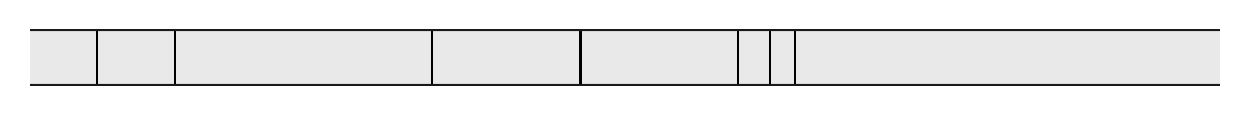

In [84]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [85]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

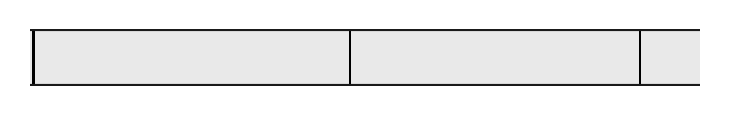

In [86]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [87]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

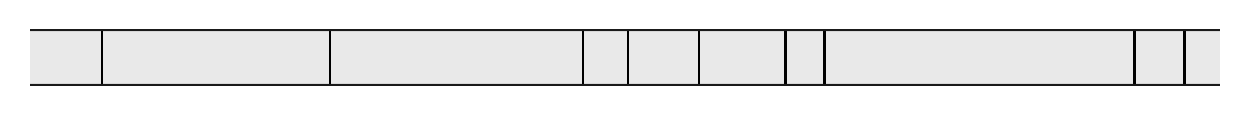

In [88]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


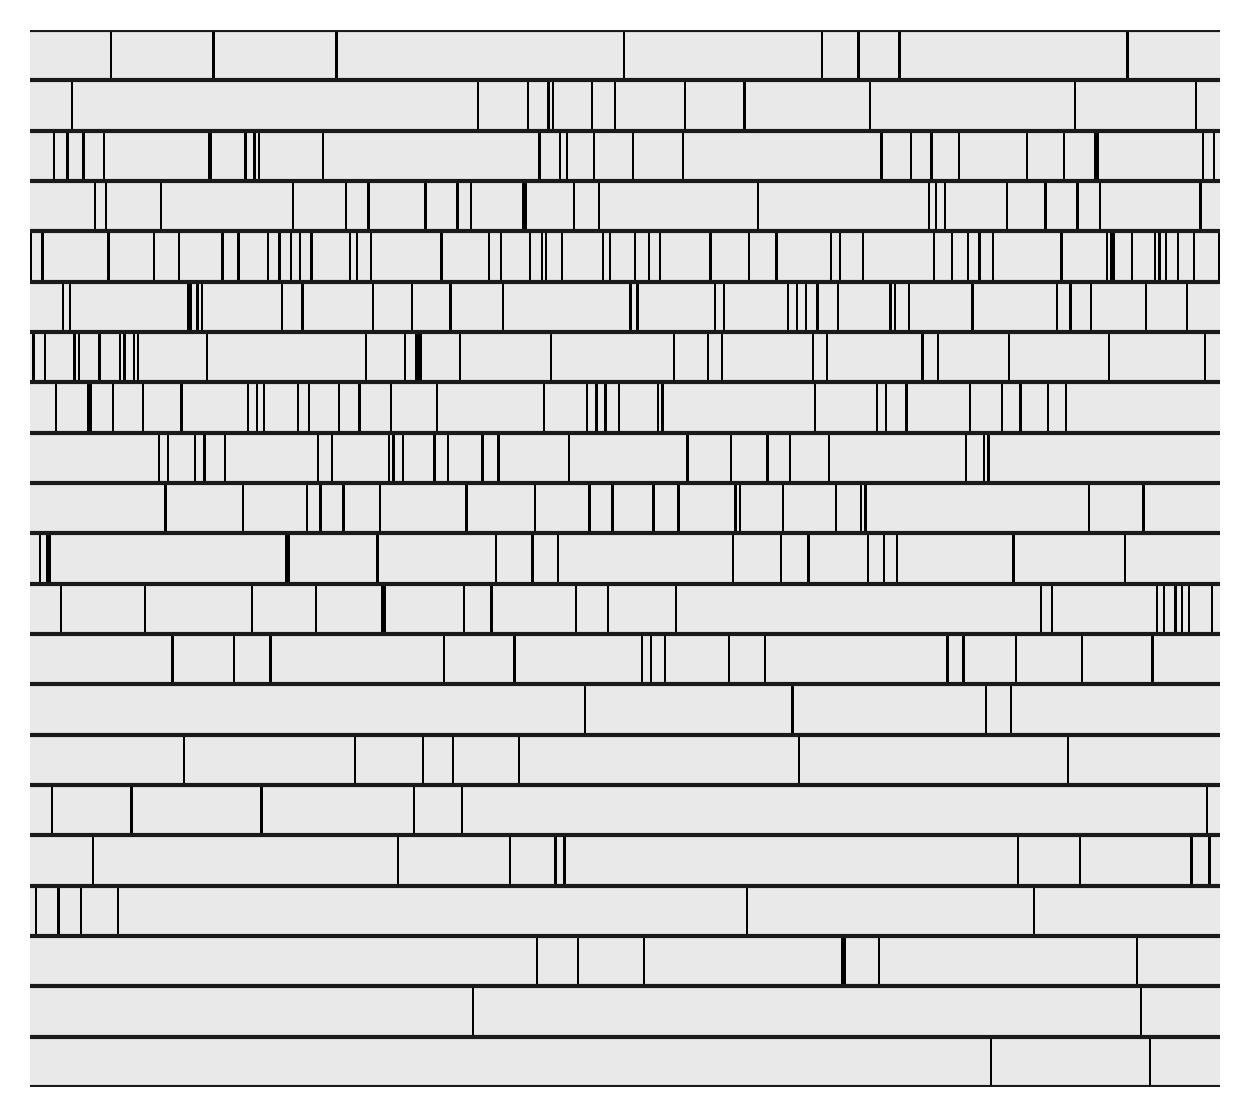

In [89]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [90]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

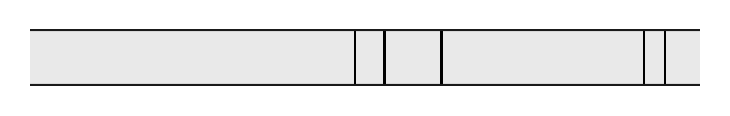

In [91]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


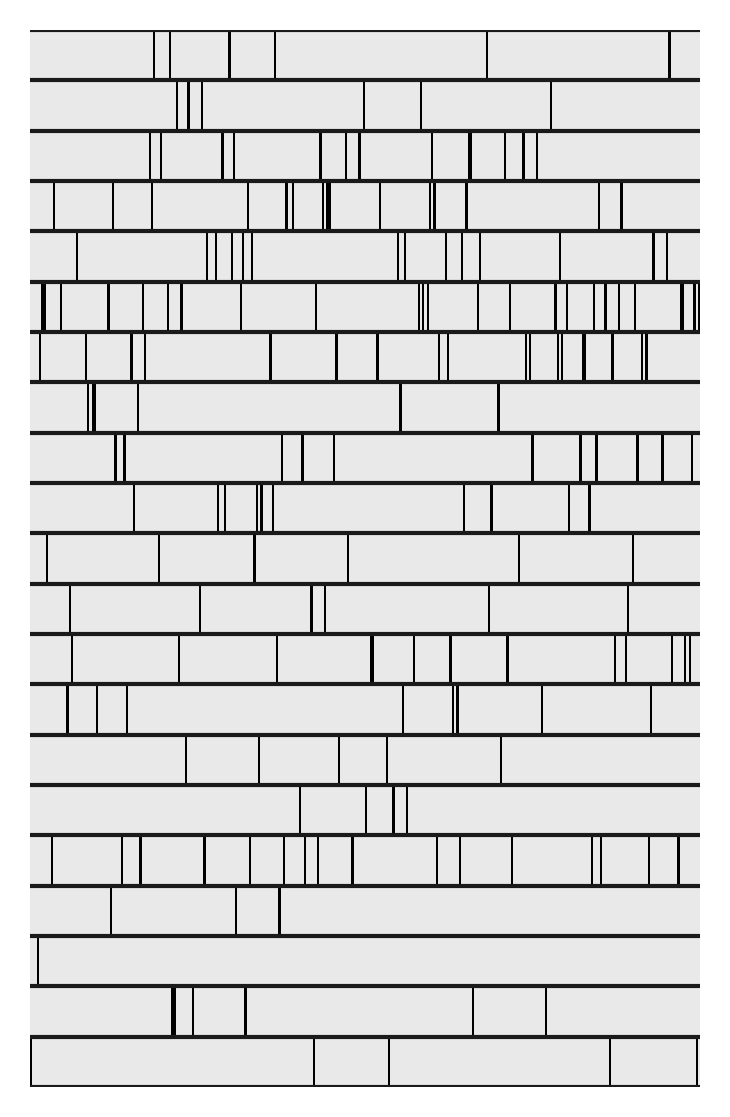

In [92]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [93]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_25472/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,platinum_color,FDR
GDSC2_Cisplatin_1005,57.0,0.018483,0.026100,0.016176,1.791137,1,Platinum,84691,1,0.161757
CTRP2_oxaliplatin_375582,55.0,0.266000,0.434020,0.034474,1.462503,1,Platinum,24197464,2,0.172372
GDSC2_Oxaliplatin_1089,58.0,0.006920,0.019415,0.157080,0.803879,0,Platinum,5310940,2,0.392700
PRISM_carboplatin_BRD-K90947825-001-02-7,38.0,0.176583,0.047341,0.274666,0.561196,0,Platinum,426756,3,0.549331
CTRP2_carboplatin_26979,59.0,0.007000,0.113893,0.422557,0.374115,0,Platinum,38904,3,0.590576
GDSC1_Cisplatin_1005,64.0,0.005509,0.010835,0.451014,0.345810,0,Platinum,84691,1,0.590576
gCSI_Cisplatin_CID24191118,22.0,0.032722,0.015302,0.472460,0.325635,0,Platinum,24191118,1,0.590576
PRISM_oxaliplatin_BRD-K78960041-001-05-7,39.0,-0.005493,-0.005011,0.996620,0.001470,0,Platinum,24197464,2,0.996620
GDSC2_Oxaliplatin_1806,53.0,-0.000440,0.012289,0.566322,0.246937,0,Platinum,5310940,2,0.629247
PRISM_cisplatin_BRD-K69172251-001-08-9,40.0,-0.011916,-0.019781,0.090395,1.043854,0,Platinum,24191118,1,0.301317


In [94]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_25472/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,platinum_color,FDR
GDSC2_Niraparib_1177,53.0,0.006844,0.019611,0.016287,1.788167,1,PARP inhibitor,24958200,0,0.228014
GDSC2_Talazoparib_1259,55.0,0.014545,0.046702,0.096331,1.016234,0,PARP inhibitor,44819241,0,0.337159
CTRP2_olaparib_411867,59.0,0.243000,0.076579,0.276868,0.557727,0,PARP inhibitor,23725625,0,0.626698
GDSC2_Olaparib_1017,57.0,0.003092,0.008316,0.326239,0.486464,0,PARP inhibitor,23725625,0,0.626698
PRISM_olaparib_BRD-K02113016-001-19-6,38.0,0.028760,0.004135,0.396206,0.402079,0,PARP inhibitor,23725625,0,0.626698
CTRP2_veliparib_606034,59.0,0.009000,0.145919,0.462486,0.334901,0,PARP inhibitor,11960529,0,0.626698
PRISM_niraparib_BRD-K54955827-001-02-2,40.0,0.020144,0.000672,0.492405,0.307677,0,PARP inhibitor,24958200,0,0.626698
PRISM_talazoparib_BRD-K95142244-001-01-5,41.0,0.034146,-0.011490,0.897895,0.046774,0,PARP inhibitor,135565082,0,0.948613
GDSC1_Olaparib_1017,64.0,0.000315,0.004148,0.948613,0.022911,0,PARP inhibitor,23725625,0,0.948613
GDSC1_Veliparib_1018,64.0,-0.001262,0.001761,0.560090,0.251742,0,PARP inhibitor,11960529,0,0.653438


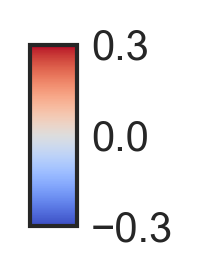

In [95]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap("coolwarm")
vmin=-0.3
vmax=0.3
bounds=[-0.3,0,0.3]
fontsize=10
label=""
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.2,0.8))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label,)
ax.tick_params(labelsize=fontsize)#,labelleft=True,labelright=False)

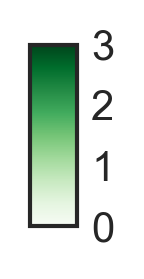

In [96]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap("Greens")
vmin=0
vmax=3
bounds=[0,1,2,3]
fontsize=10
label=''
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.2,0.8))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label)
ax.tick_params(labelsize=fontsize)#,labelleft=True,labelright=False)

## Correlations with HRD score and Signature 3

In [97]:
df=df0.copy()

(914, 2)
r = 0.475, p = 1.25e-52


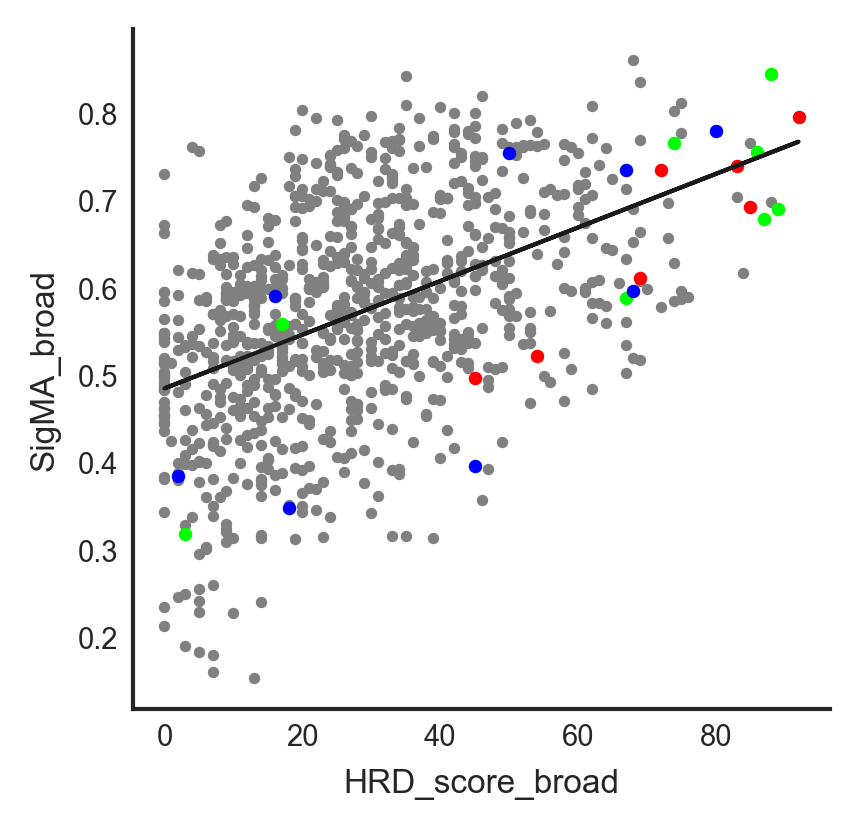

In [98]:
in_df=df.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2,val3='HRD_score_broad','SigMA_broad','BRCA_status'
plt_df=in_df[[val1,val2]].dropna()
print(plt_df.shape)
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=3,c='grey')
ax.set_xlabel(val1)
ax.set_ylabel(val2)
# linear regression, Pearson correlation
lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,c='k')

plt_df2=in_df[[val1,val2,val3]].dropna()
plt_df3=plt_df2[plt_df2[val3]=='BRCA1_methylation']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='lime')

plt_df3=plt_df2[plt_df2[val3]=='BRCA1_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='red')

plt_df3=plt_df2[plt_df2[val3]=='BRCA2_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='blue')

ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)

print('r = {:.3f}, p = {:.2e}'.format(r,p))

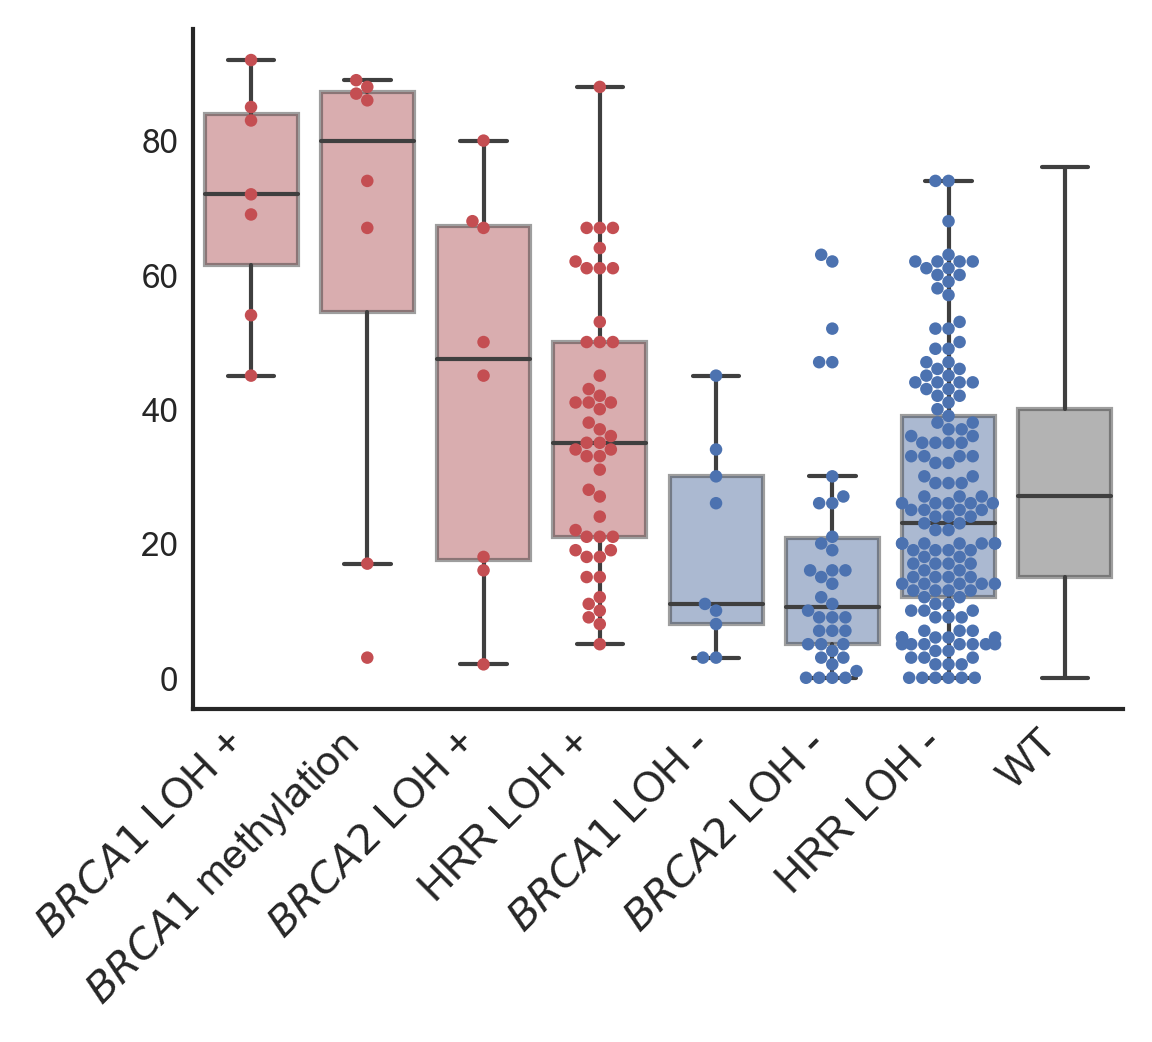

In [99]:
plt_df=df
cat='BRCA_status'
val='HRD_score_broad'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


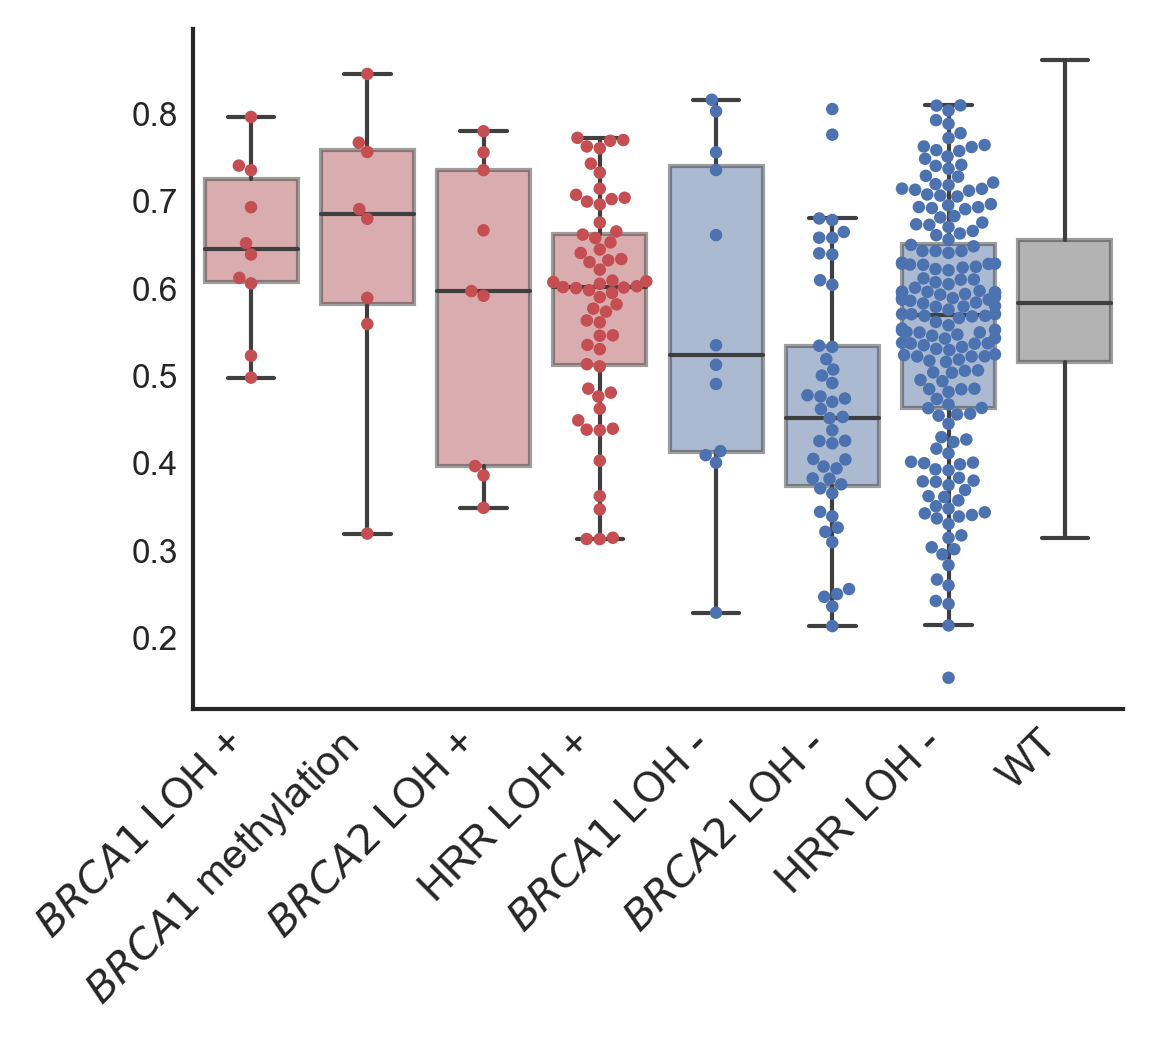

In [100]:
plt_df=df
cat='BRCA_status'
val='SigMA_broad'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

## Genomic scar and Drug sensitivity

In [101]:
df=df0.copy()

In [102]:
len(drug_all)

882

### HRD score

In [103]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df[['HRD_score_broad',drug]].dropna()
    a=plt_df['HRD_score_broad'].values
    b=plt_df[drug].values
    n=len(a)
    if n>= 10:
        r,p=stats.spearmanr(a,b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)

In [104]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs

In [105]:
df_cor=df_cor.dropna()

In [106]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['FDR']=multipletests(df_cor['pvalues'],method='fdr_bh')[1]
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [107]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(882, 8)

In [108]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Cytarabine_1006,520,2.013454e-20,0.390824,19.696058,1.775867e-17,1,Antimetabolite,6253
GDSC2_Oxaliplatin_1089,547,3.934597e-17,0.349203,16.405100,1.735157e-14,1,Platinum,5310940
GDSC2_Gemcitabine_1190,524,2.529287e-15,0.336328,14.597002,7.436105e-13,1,Antimetabolite,60750
GDSC2_Palbociclib_1054,533,8.500994e-15,0.327569,14.070530,1.874469e-12,1,Cell cycle,5330286
GDSC1_Lestaurtinib_1024,611,1.343798e-14,0.304755,13.871666,2.079063e-12,1,Others,126565
...,...,...,...,...,...,...,...,...
gCSI_Gemcitabine_CID356653,266,3.259199e-05,-0.251802,4.486889,1.955519e-04,1,Antimetabolite,356653
GDSC2_AZD3759_1915,525,2.225128e-05,-0.183950,4.652645,1.422147e-04,1,EGFR signaling,78209992
GDSC2_Gefitinib_1010,520,6.620194e-06,-0.196131,5.179129,4.990608e-05,1,EGFR signaling,123631
GDSC2_GDC0810_1925,520,4.165356e-06,-0.200286,5.380348,3.443443e-05,1,Hormone-related,56941241


In [109]:
NP=len(df_cor_p)
NN=len(df_cor_n)

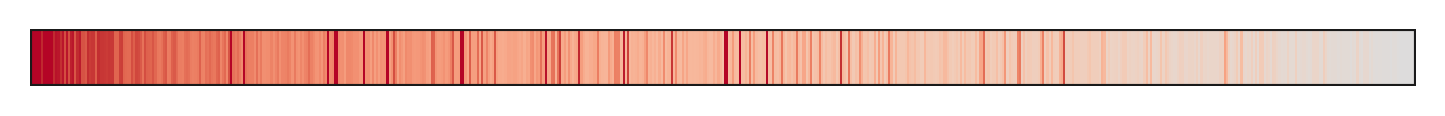

In [110]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

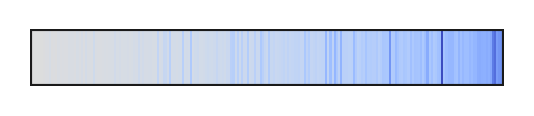

In [111]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

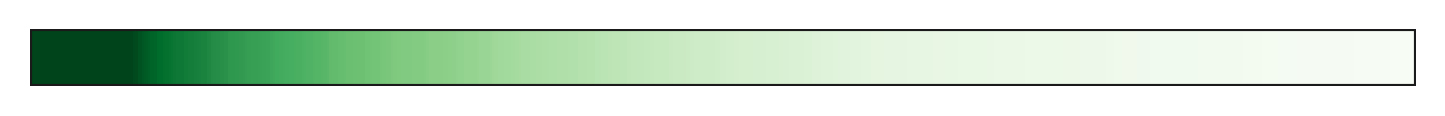

In [112]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

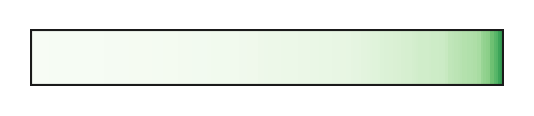

In [113]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

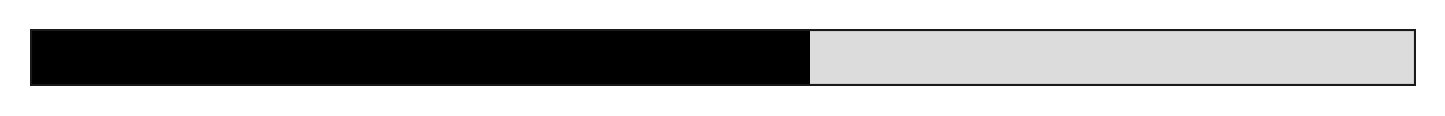

In [114]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

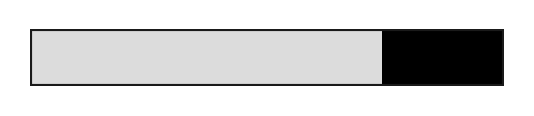

In [115]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [116]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

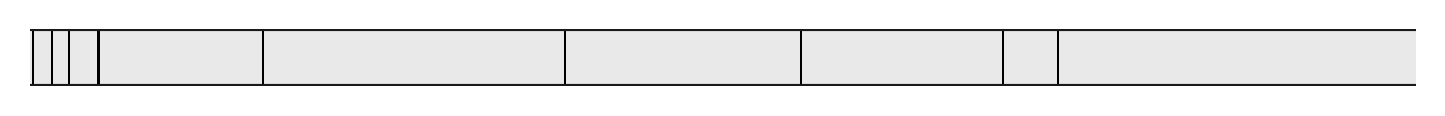

In [117]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

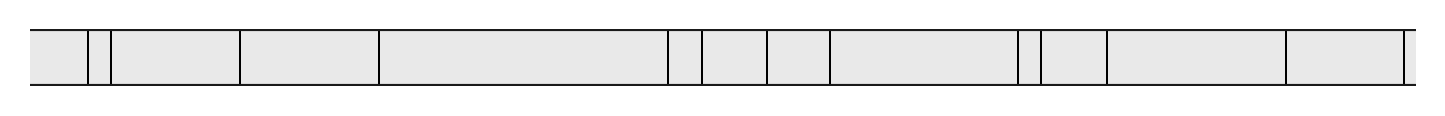

In [118]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


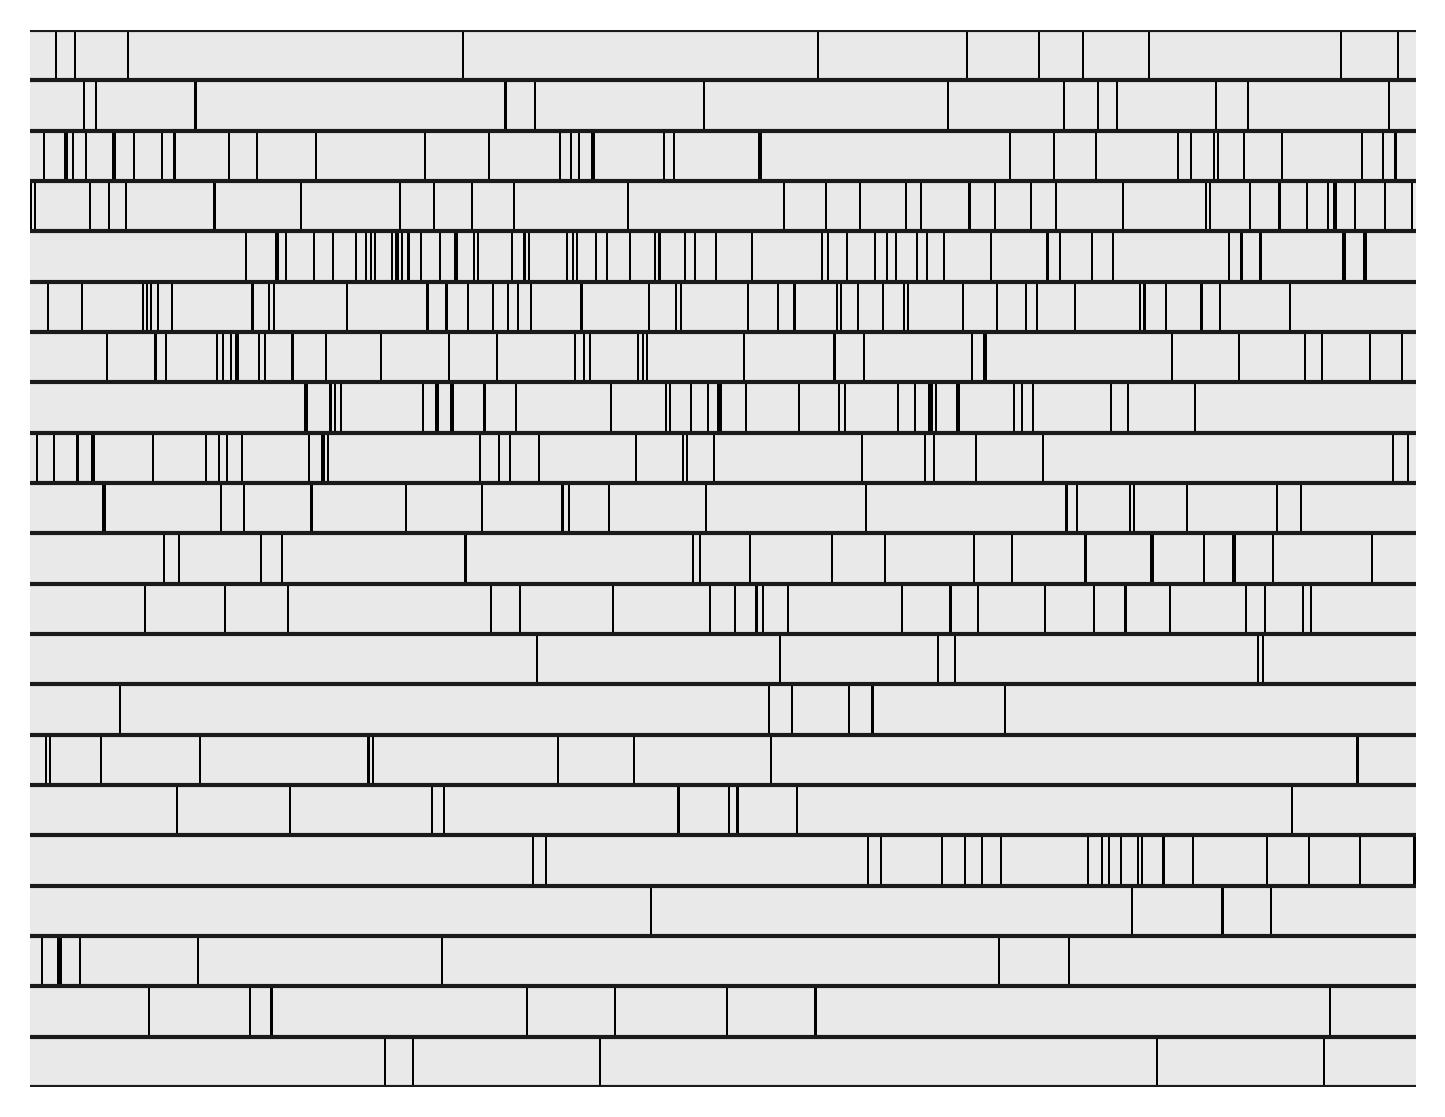

In [119]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [120]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

In [121]:
in_df['p53 pathway']=0
in_df['Cytoskeleton']=0

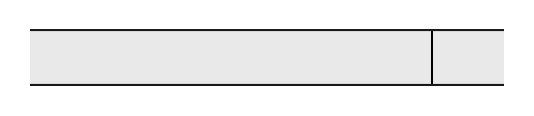

In [122]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

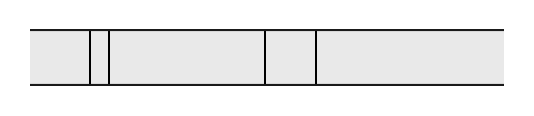

In [123]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


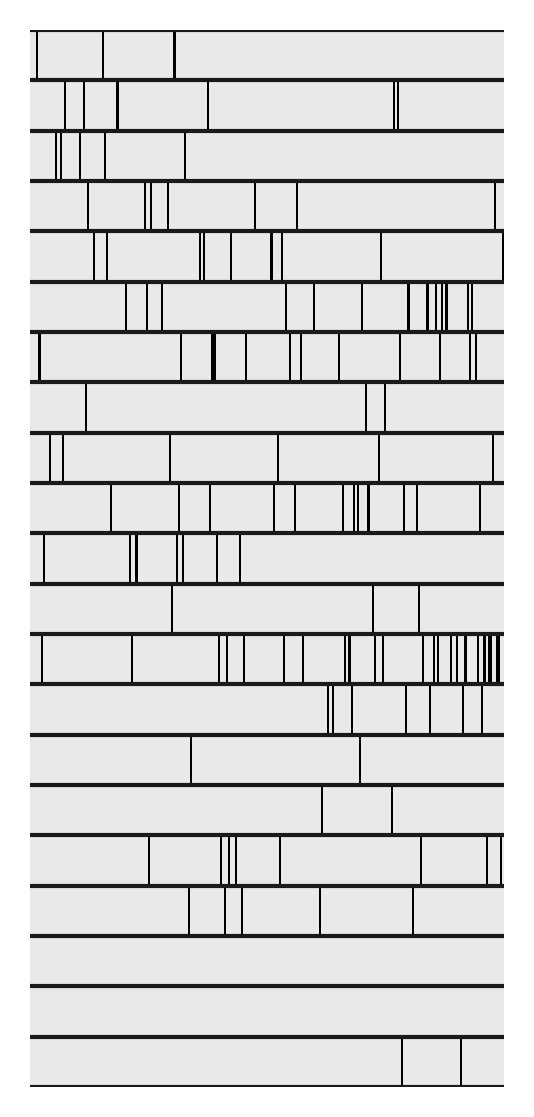

In [124]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [125]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_25472/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Oxaliplatin_1089,547,3.934597e-17,0.349203,16.405100,3.934597e-16,1,Platinum,5310940
GDSC2_Cisplatin_1005,530,2.019840e-12,0.299180,11.694683,1.009920e-11,1,Platinum,84691
CTRP2_oxaliplatin_375582,729,3.122994e-11,0.242681,10.505429,1.040998e-10,1,Platinum,24197464
GDSC2_Oxaliplatin_1806,495,4.752044e-10,0.275161,9.323120,1.188011e-09,1,Platinum,5310940
CTRP2_carboplatin_26979,744,5.273959e-06,0.166061,5.277863,1.054792e-05,1,Platinum,38904
PRISM_oxaliplatin_BRD-K78960041-001-05-7,431,2.524657e-03,0.145137,2.597798,4.207762e-03,1,Platinum,24197464
GDSC1_Cisplatin_1005,612,4.585888e-02,0.080745,1.338577,5.732360e-02,1,Platinum,84691
gCSI_Cisplatin_CID24191118,263,1.971092e-01,0.079788,0.705293,2.190103e-01,0,Platinum,24191118
PRISM_carboplatin_BRD-K90947825-001-02-7,426,2.524674e-01,0.055566,0.597795,2.524674e-01,0,Platinum,426756
PRISM_cisplatin_BRD-K69172251-001-08-9,429,1.643623e-02,-0.115777,1.784198,2.348032e-02,1,Platinum,24191118


In [126]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_25472/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Talazoparib_1259,516,2.138063e-10,0.274855,9.669980,3.634707e-09,1,PARP inhibitor,44819241
GDSC2_Niraparib_1177,498,1.607727e-09,0.266131,8.793788,1.366568e-08,1,PARP inhibitor,24958200
GDSC1_Olaparib_1017,611,2.994965e-06,0.187678,5.523608,1.697147e-05,1,PARP inhibitor,23725625
CTRP2_olaparib_411867,741,9.918360e-05,0.142508,4.003560,4.215303e-04,1,PARP inhibitor,23725625
GDSC1_Talazoparib_1259,588,9.937452e-03,0.106240,2.002725,3.378734e-02,1,PARP inhibitor,44819241
GDSC2_Olaparib_1017,528,1.561959e-02,0.105174,1.806330,4.425551e-02,1,PARP inhibitor,23725625
CTRP1_rucaparib_628605,51,3.468023e-02,0.296416,1.459918,8.422340e-02,1,PARP inhibitor,9931954
GDSC1_Veliparib_1018,612,6.365140e-02,0.075016,1.196192,1.352592e-01,0,PARP inhibitor,11960529
CTRP1_veliparib_606034,51,2.126428e-01,0.177532,0.672349,3.614927e-01,0,PARP inhibitor,11960529
CTRP1_olaparib_411867,109,2.345472e-01,0.114806,0.629770,3.624821e-01,0,PARP inhibitor,23725625


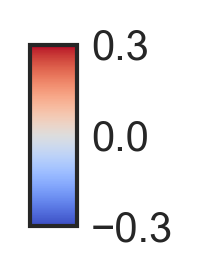

In [127]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap("coolwarm")
vmin=-0.3
vmax=0.3
bounds=[-0.3,0,0.3]
fontsize=10
label=""
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.2,0.8))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label,)
ax.tick_params(labelsize=fontsize)#,labelleft=True,labelright=False)

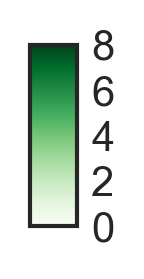

In [128]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap("Greens")
vmin=0
vmax=8
bounds=[0,2,4,6,8]
fontsize=10
label=''
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.2,0.8))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label)
ax.tick_params(labelsize=fontsize)#,labelleft=True,labelright=False)

### Signature 3 broad

In [129]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df[['SigMA_broad',drug]].dropna()
    a=plt_df['SigMA_broad'].values
    b=plt_df[drug].values
    n=len(a)
    if n>= 50:
        r,p=stats.spearmanr(a,b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)

In [130]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs

In [131]:
df_cor=df_cor.dropna()

In [132]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['FDR']=multipletests(df_cor['pvalues'],method='fdr_bh')[1]
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [133]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(866, 8)

In [134]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC1_VX-11e_262,876.0,3.749505e-10,0.209589,9.426026,1.830789e-07,1,ERK MAPK signaling,11634725
GDSC1_(5Z)-7-Oxozeaenol_1242,869.0,3.496054e-09,0.198648,8.456422,9.307890e-07,1,Others,9863776
GDSC1_Refametinib_1014,882.0,9.725182e-09,0.191602,8.012102,1.684402e-06,1,ERK MAPK signaling,44182295
GDSC1_NVP-BHG712_295,876.0,1.240118e-08,0.190887,7.906537,1.789904e-06,1,Others,16747388
GDSC1_CI-1040_1015,885.0,3.077220e-08,0.184780,7.511841,3.298664e-06,1,ERK MAPK signaling,6918454
...,...,...,...,...,...,...,...,...
gCSI_Vincaleukoblastine_CID241902,183.0,7.811361e-05,-0.287772,4.107273,1.537418e-03,1,Antimicrotubule,241902
gCSI_Vincristine_CID5978,449.0,1.024263e-05,-0.206541,4.989589,3.365418e-04,1,Others,5978
gCSI_Crizotinib_CID54613769,452.0,4.645823e-06,-0.213535,5.332937,1.749253e-04,1,RTK signaling,54613769
gCSI_Gemcitabine_CID356653,285.0,4.299256e-09,-0.338979,8.366607,9.307890e-07,1,Antimetabolite,356653


In [135]:
NP=len(df_cor_p)
NN=len(df_cor_n)

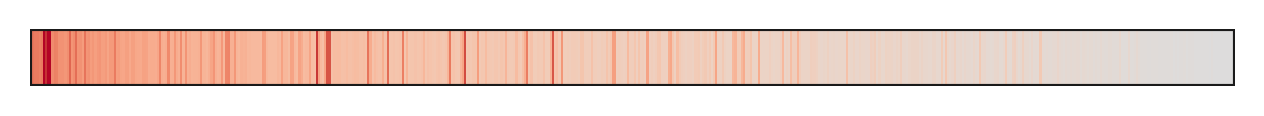

In [136]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

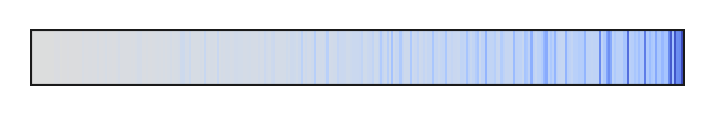

In [137]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

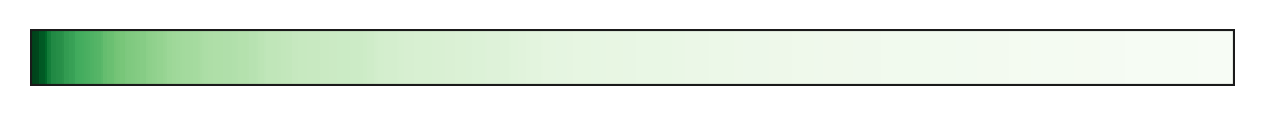

In [138]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

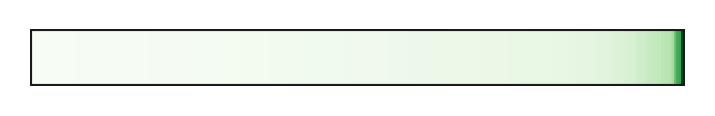

In [139]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

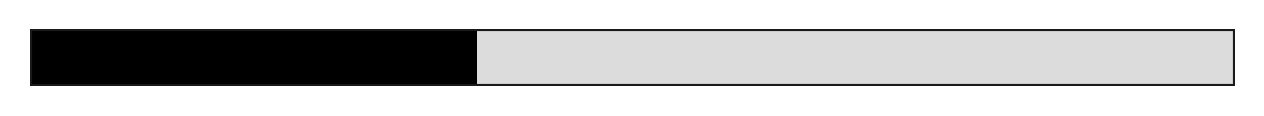

In [140]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

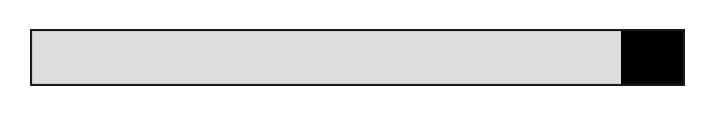

In [141]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [142]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

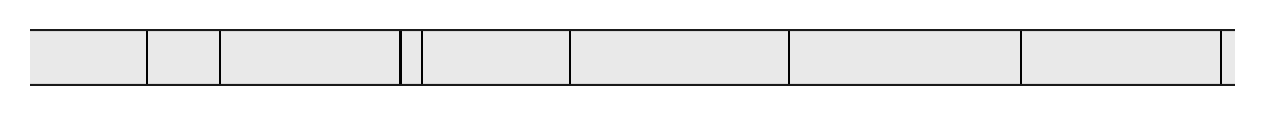

In [143]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

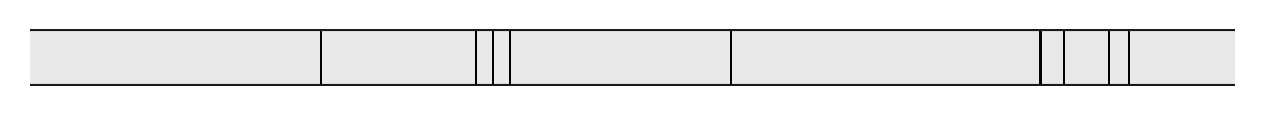

In [144]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


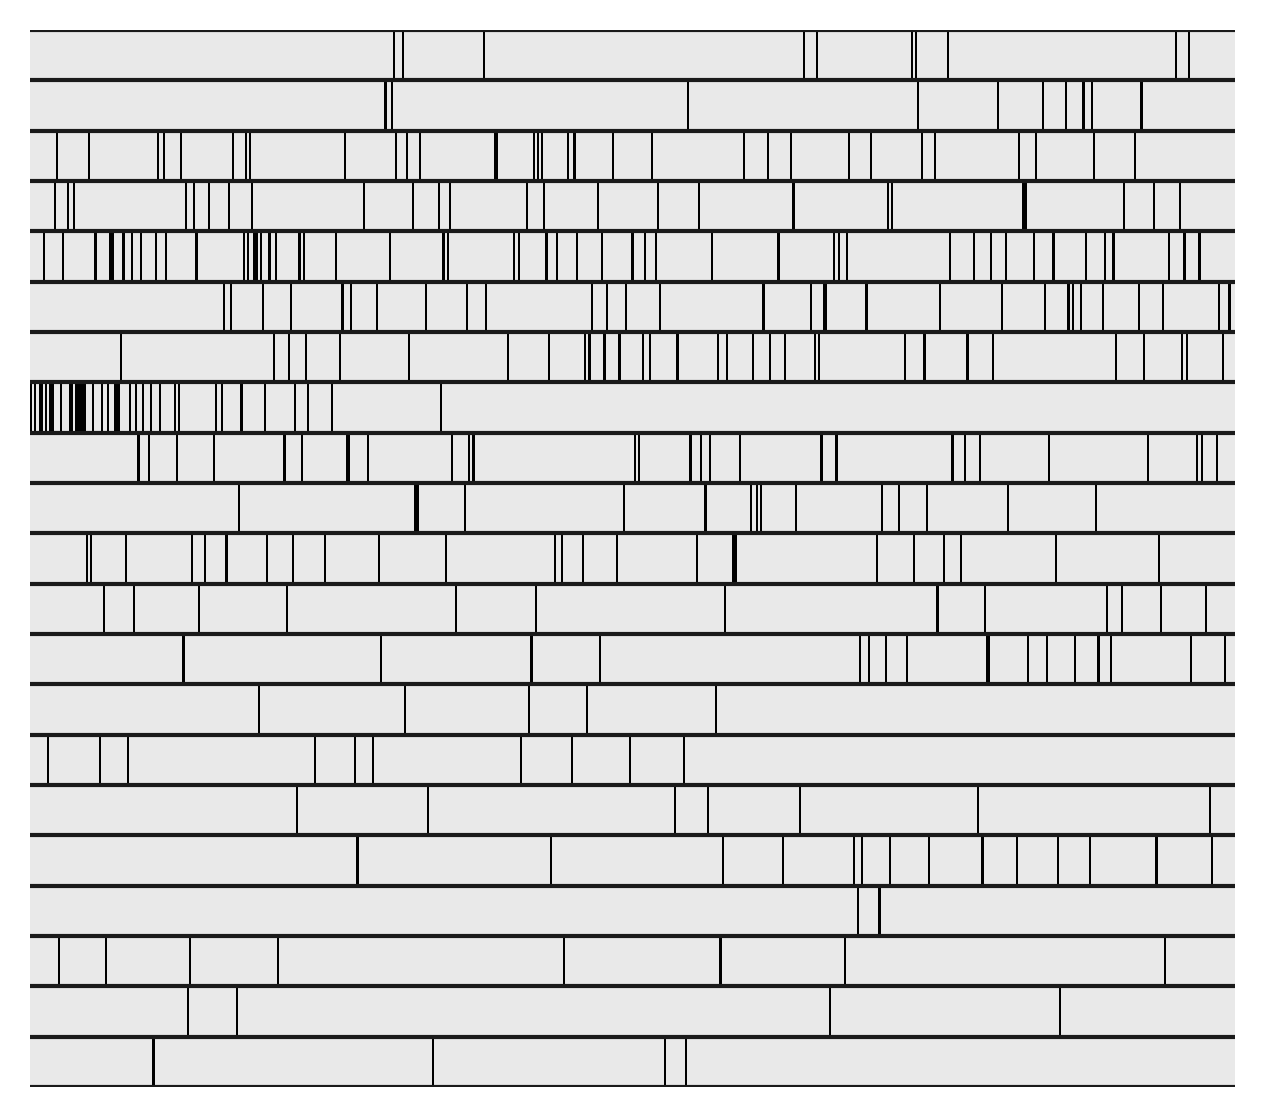

In [145]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [146]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

In [147]:
in_df['p53 pathway']=0
#in_df['Cytoskeleton']=0
in_df['Genome integrity']=0

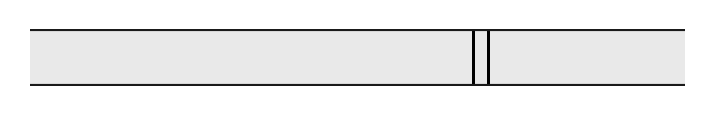

In [148]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

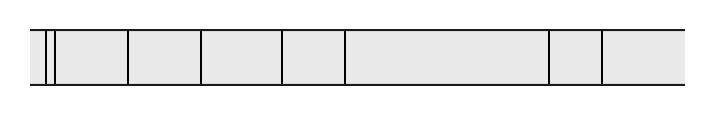

In [149]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


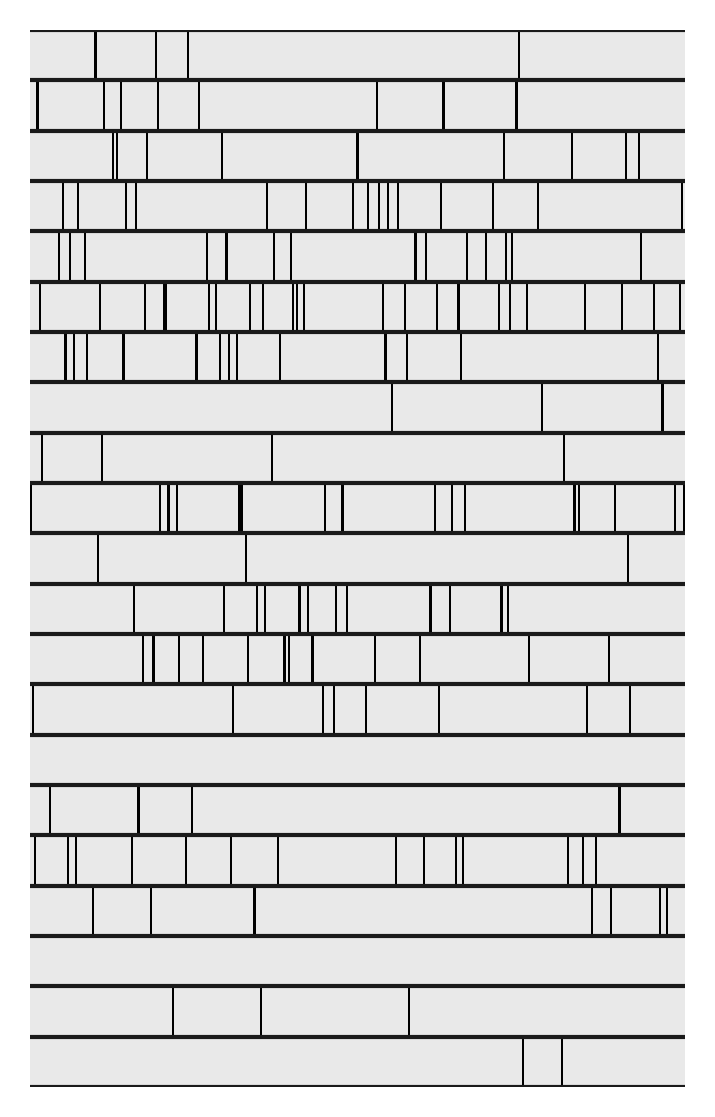

In [150]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [151]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_25472/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Oxaliplatin_1806,701.0,0.000319,0.135572,3.496760,0.003186,1,Platinum,5310940
GDSC2_Oxaliplatin_1089,770.0,0.002280,0.109798,2.641999,0.011402,1,Platinum,5310940
CTRP2_carboplatin_26979,766.0,0.029960,0.078435,1.523457,0.086361,1,Platinum,38904
GDSC2_Cisplatin_1005,737.0,0.034544,0.077872,1.461621,0.086361,1,Platinum,84691
GDSC1_Cisplatin_1005,901.0,0.114076,0.052679,0.942807,0.228152,0,Platinum,84691
CTRP2_oxaliplatin_375582,755.0,0.314028,0.036690,0.503031,0.392535,0,Platinum,24197464
PRISM_oxaliplatin_BRD-K78960041-001-05-7,441.0,0.633329,0.022778,0.198371,0.703699,0,Platinum,24197464
gCSI_Cisplatin_CID24191118,283.0,0.975764,0.001814,0.010655,0.975764,0,Platinum,24191118
PRISM_cisplatin_BRD-K69172251-001-08-9,438.0,0.226744,-0.057875,0.644465,0.323920,0,Platinum,24191118
PRISM_carboplatin_BRD-K90947825-001-02-7,436.0,0.216191,-0.059346,0.665162,0.323920,0,Platinum,426756


In [152]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_25472/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Talazoparib_1259,719.0,0.011784,0.093882,1.928723,0.200321,1,PARP inhibitor,44819241
GDSC2_Niraparib_1177,701.0,0.049834,0.074111,1.302474,0.266403,1,PARP inhibitor,24958200
GDSC1_Talazoparib_1259,867.0,0.057129,0.064632,1.243146,0.266403,0,PARP inhibitor,44819241
GDSC1_Olaparib_1017,899.0,0.062683,0.062109,1.202850,0.266403,0,PARP inhibitor,23725625
GDSC1_Veliparib_1018,900.0,0.253318,0.038117,0.596333,0.615202,0,PARP inhibitor,11960529
CTRP1_veliparib_606034,51.0,0.661965,0.062715,0.179165,0.953437,0,PARP inhibitor,11960529
GDSC1_Olaparib_1495,864.0,0.692911,0.013454,0.159322,0.953437,0,PARP inhibitor,23725625
PRISM_olaparib_BRD-K02113016-001-19-6,425.0,0.772159,0.014086,0.112293,0.953437,0,PARP inhibitor,23725625
CTRP1_olaparib_411867,111.0,0.812412,0.022780,0.090224,0.953437,0,PARP inhibitor,23725625
CTRP2_veliparib_606034,783.0,0.984998,-0.000673,0.006565,0.984998,0,PARP inhibitor,11960529


# COSMIC

In [153]:
df2=pd.read_csv('../processed/CCLE_integrated_cosmic.txt',sep='\t',index_col=0)
df2

,ID_tumour,Sample name,stripped_cell_line_name,SigMA_cosmic,BRCA1,BRCA2,ATM,ATR,BARD1,BLM,BRIP1,CDK12,CHEK1,CHEK2,FANCA,FANCC,FANCD2,FANCE,FANCF,FANCI,FANCL,FANCM,MRE11,NBN,PALB2,RAD50,RAD51,RAD51B,RAD51C,RAD51D,RAD52,RAD54L,RPA1,BRCA1_LOH,BRCA1_nonLOH,BRCA2_LOH,BRCA2_nonLOH,ATM_LOH,ATM_nonLOH,ATR_LOH,ATR_nonLOH,BARD1_nonLOH,BLM_nonLOH,BRIP1_LOH,BRIP1_nonLOH,CDK12_LOH,CDK12_nonLOH,CHEK1_nonLOH,CHEK2_LOH,CHEK2_nonLOH,...,CTRP2_tretinoin_23151,CTRP2_trifluoperazine_26914,CTRP2_triptolide_411720,CTRP2_valdecoxib_32372,CTRP2_vandetanib_349002,CTRP2_veliparib_606034,CTRP2_vincristine_62602,CTRP2_vorapaxar_660136,CTRP2_vorinostat_56554,gCSI_Tanespimycin_CID6505803,gCSI_5-Fluorouracil_CID3385,gCSI_AZ-628_CID11676786,gCSI_AZD7762_CID11152667,gCSI_AZD8055_CID25262965,gCSI_Azacitidine_CID9444,gCSI_Bortezomib_CID387447,gCSI_Bosutinib_CID5328940,gCSI_Chir-99021_CID9956119,gCSI_Cisplatin_CID24191118,gCSI_Crizotinib_CID54613769,gCSI_Dabrafenib_CID44462760,gCSI_Dasatinib_CID3062316,gCSI_Docetaxel_CID148124,gCSI_Erastin_CID11214940,gCSI_Erlotinib_CID176871,gCSI_Etoposide_CID36462,gCSI_GSK2636771_CID56949517,gCSI_Gefitinib_CID123631,gCSI_Gemcitabine_CID356653,gCSI_Ibrutinib_CID24821094,gCSI_JQ1 compound_CID71300862,gCSI_Lapatinib_CID208908,gCSI_Lenalidomide_CID216326,gCSI_MI-2_CID54765302,gCSI_MK-2206_CID46930998,gCSI_MLN2480_CID25161177,gCSI_Methotrexate_CID126941,gCSI_NU-7441_CID11327430,gCSI_Narciclasine_CID72376,gCSI_Nilotinib_CID644241,gCSI_Oligomycin A_CID5472285,gCSI_PF-4708671_CID51371303,gCSI_PLX4720_CID24180719,gCSI_Paclitaxel_CID36314,gCSI_Palbociclib_CID5330286,gCSI_TGX221_CID9907093,gCSI_Tivantinib_CID11494412,gCSI_Vincaleukoblastine_CID241902,gCSI_Vincristine_CID5978,gCSI_Vorinostat_CID5311
ID_sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1287381,1198659,201T,201T,0.641314,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
924100,840876,22RV1,22RV1,0.303776,wt,nonLOH,wt,wt,nonLOH,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,13.652,13.715,12.3470,12.451,12.847,13.509,4.9409,13.320,10.418,NaN,0.279667,0.166333,NaN,NaN,NaN,NaN,NaN,NaN,0.428333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108222,NaN,NaN,NaN,NaN,-0.096111,0.763111,NaN,NaN,NaN,NaN,0.014222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
910924,828408,23132-87,2313287,0.326533,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,nonLOH,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12.093,13.560,12.2960,11.631,12.657,14.614,4.8413,14.438,11.638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687561,615721,42-MG-BA,42MGBA,0.562599,wt,wt,wt,wt,wt,wt,nonLOH,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,14.879,14.385,5.2984,13.313,12.770,14.746,8.2146,13.306,12.319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1287706,1198893,451Lu,451Lu,0.390768,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [880]:
brca1_met=[]
for idx in df2.index:
    if df2.loc[idx,'BRCA1_methylation_cosmic_likely']==1:
        brca1_met.append(1)
    elif df2.loc[idx,'BRCA1_methylation_broad']==1:
        brca1_met.append(1)
    elif df2.loc[idx,'BRCA1_methylation_cosmic_likely']==0:
        brca1_met.append(0)
    elif df2.loc[idx,'BRCA1_methylation_broad']==0:
        brca1_met.append(0)
    else:
        brca1_met.append(np.nan)
df2['BRCA1_methylation']=brca1_met

In [881]:
df2=df2.rename(columns={'HRD_score':'HRD_score_cosmic'})

In [882]:
brca_status=[]
for idx in df2.index:
    if df2.loc[idx,'BRCA1']=='LOH':
        brca_status.append('BRCA1_LOH')
    elif df2.loc[idx,'BRCA2']=='LOH':
        brca_status.append('BRCA2_LOH')
    elif df2.loc[idx,'BRCA2']=='LOH':
        brca_status.append('BRCA2_LOH')
    elif df2.loc[idx,'BRCA1_methylation']==1:
        brca_status.append('BRCA1_methylation')
    elif df2.loc[idx,'otherHRR_LOH']==1:
        brca_status.append('HRR_LOH')
    elif df2.loc[idx,'BRCA1']=='unknown':
        brca_status.append('BRCA1_unknown')
    elif df2.loc[idx,'otherHRR_unknown']==1:
        brca_status.append('HRR_unknown')
    elif df2.loc[idx,'BRCA1']=='nonLOH':
        brca_status.append('BRCA1_nonLOH')
    elif df2.loc[idx,'BRCA2']=='nonLOH':
        brca_status.append('BRCA2_nonLOH')
    elif df2.loc[idx,'otherHRR_nonLOH']==1:
        brca_status.append('HRR_nonLOH')
    elif (df2.loc[idx,'BRCA1']=='wt')&(df2.loc[idx,'BRCA2']=='wt')&(df2.loc[idx,'BRCA1_methylation']==0):
        brca_status.append('wt')
    else:
        brca_status.append(np.nan)

In [883]:
df2['BRCA_status']=brca_status

In [884]:
Counter(df2['BRCA_status']).most_common()

[('wt', 777),
 ('HRR_nonLOH', 119),
 (nan, 38),
 ('HRR_LOH', 32),
 ('BRCA2_nonLOH', 27),
 ('BRCA2_LOH', 10),
 ('BRCA1_nonLOH', 8),
 ('BRCA1_methylation', 5),
 ('BRCA1_LOH', 4)]

In [885]:
df2=df2[(df2['BRCA_status'].isna()==False)]
df2.shape

(982, 977)

In [886]:
df2['BRCA_alteration']=((df2['BRCA1_LOH']==1)|(df2['BRCA1_methylation']==1)|(df2['BRCA2_LOH']==1)).astype(int)

In [887]:
(df2['BRCA_alteration']==1).sum()

19

In [888]:
(~df2['HRD_score_cosmic'].isna()).sum()

978

In [889]:
(~df2['SigMA_cosmic'].isna()).sum()

977

## BRCA status vs Drug sensitivity

In [890]:
drug_gdsc1=set(df.columns[df.columns.str.startswith('GDSC1')])
drug_gdsc2=set(df.columns[df.columns.str.contains('GDSC2')])
drug_ctrp1=set(df.columns[df.columns.str.contains('CTRP1')])
drug_ctrp2=set(df.columns[df.columns.str.contains('CTRP2')])
drug_prism=set(df.columns[df.columns.str.startswith("PRISM")])
drug_gcsi=set(df.columns[df.columns.str.contains('gCSI')])

In [891]:
drug_all_set=drug_gdsc1|drug_gdsc2|drug_ctrp1|drug_ctrp2|drug_prism|drug_gcsi
len(drug_all_set)

882

In [892]:
drug_anno=pd.read_csv('../processed/Drug_annotaion_integrated.txt'
                      ,sep='\t',index_col=0)
drug_anno['cid']=drug_anno['cid'].astype(int)

In [893]:
from statsmodels.stats.multitest import multipletests

In [894]:
drug_all=[]
for x in drug_all_set:
    if 'C50' in x:
        continue
    else:
        drug_all.append(x)

In [895]:
drug_all=sorted(drug_all)

In [896]:
len(drug_all)

882

In [897]:
df_drug=df2[~df2[drug_all_set].isna().all(axis=1)]

In [898]:
df_drug.shape

(970, 978)

### BRCA12 altaration

In [899]:
Counter(df_drug['BRCA_status']).most_common()

[('wt', 769),
 ('HRR_nonLOH', 118),
 ('HRR_LOH', 30),
 ('BRCA2_nonLOH', 27),
 ('BRCA2_LOH', 9),
 ('BRCA1_nonLOH', 8),
 ('BRCA1_methylation', 5),
 ('BRCA1_LOH', 4)]

In [900]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH']).sum() 

18

In [901]:
df_drug['BRCA_status'].isin(['wt']).sum() 

769

In [902]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
n_limit=7
for drug in drug_all:
    a=df_drug[df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH'])][drug].dropna().values
#    b=df[~df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH'])][drug].dropna().values
    b=df_drug[df_drug['BRCA_status'].isin(['wt']#,'HRR_nonLOH','HRR_LOH','BRCA2_nonLOH','HRR_unknown','BRCA1_nonLOH']
                                )][drug].dropna().values
    n=len(a)
    if n> n_limit:
        r,p=stats.mannwhitneyu(a,b)
#        r,p=stats.brunnermunzel(a,b)
        m=np.median(a)-np.median(b)
        m2=np.mean(a)-np.mean(b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
        ms.append(m)
        ms2.append(m2)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)
        ms.append(np.nan)
        ms2.append(np.nan)

In [903]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps


In [904]:
df_cor=df_cor.dropna()

In [905]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['FDR']=multipletests(df_cor['pvalues'],method='fdr_bh')[1]
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [906]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,FDR,significant,drug_anno,cid
CTRP2_ABT-737_411738,10.0,0.195000,0.841180,0.440120,0.356428,0.806035,0,Apoptosis regulation,11228183
CTRP2_AZD4547_660325,10.0,0.708500,0.934010,0.034217,1.465755,0.396348,1,RTK signaling,51039095
CTRP2_AZD6482_639390,11.0,0.157000,0.155658,0.716693,0.144667,0.959992,0,PI3K/MTOR signaling,44137675
CTRP2_AZD7762_660777,11.0,-0.023100,0.233390,0.880499,0.055271,0.980445,0,Cell cycle,11152667
CTRP2_AZD8055_609639,11.0,0.042000,-0.340099,0.758900,0.119816,0.962320,0,PI3K/MTOR signaling,25262965
...,...,...,...,...,...,...,...,...,...
gCSI_PF-4708671_CID51371303,9.0,-0.040278,-0.020059,0.246690,0.607849,0.710520,0,PI3K/MTOR signaling,51371303
gCSI_Paclitaxel_CID36314,9.0,0.006000,-0.035198,0.843571,0.073878,0.973663,0,Antimicrotubule,36314
gCSI_Tivantinib_CID11494412,9.0,-0.121222,-0.105861,0.034943,1.456635,0.396348,1,Others,11494412
gCSI_Vincristine_CID5978,9.0,-0.067333,-0.030630,0.541252,0.266601,0.887992,0,Others,5978


In [907]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Foretinib_2040,16.0,0.102123,0.110268,0.000050,4.297930,0.031726,1,RTK signaling,42642645
GDSC1_Vorinostat_1012,17.0,0.086639,0.099654,0.001536,2.813618,0.228604,1,Chromatin-related,5311
GDSC2_AZ960_1250,15.0,0.074491,0.089214,0.001553,2.808936,0.228604,1,Others,25099184
GDSC2_Vorinostat_1012,16.0,0.092132,0.062154,0.001658,2.780322,0.228604,1,Chromatin-related,5311
GDSC2_Dabrafenib_1373,16.0,0.013306,0.039756,0.001814,2.741287,0.228604,1,ERK MAPK signaling,44462760
...,...,...,...,...,...,...,...,...,...
gCSI_JQ1 compound_CID71300862,10.0,-0.042389,-0.059813,0.012865,1.890595,0.352385,1,Others,71300862
GDSC1_Afatinib_1377,17.0,-0.040271,-0.030164,0.012539,1.901752,0.352385,1,EGFR signaling,10184653
gCSI_Vorinostat_CID5311,9.0,-0.107667,-0.119774,0.010033,1.998575,0.352385,1,Chromatin-related,5311
GDSC2_OSI-027_1594,8.0,-0.064367,-0.040667,0.004146,2.382419,0.326462,1,PI3K/MTOR signaling,44224160


In [908]:
NP=len(df_cor_p)
NN=len(df_cor_n)

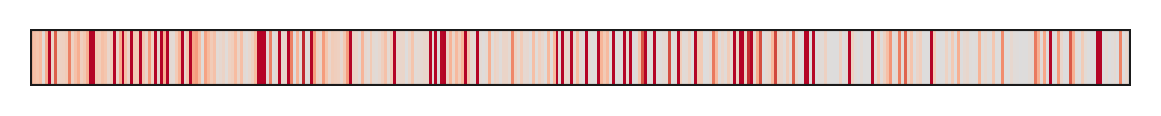

In [909]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

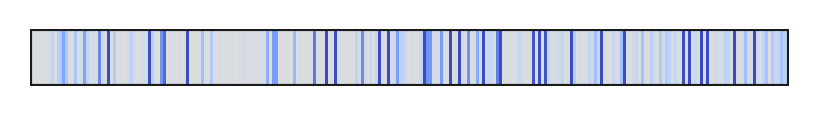

In [910]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

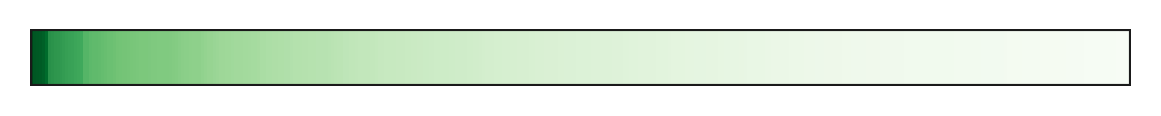

In [911]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

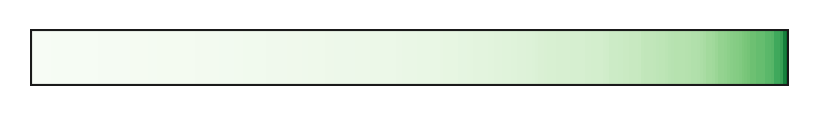

In [912]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

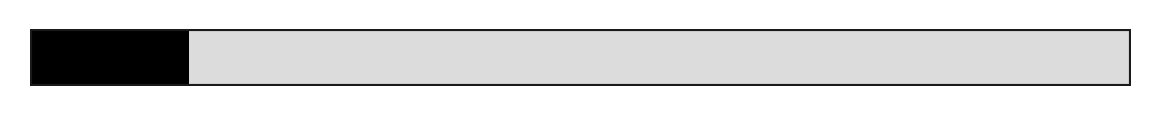

In [913]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

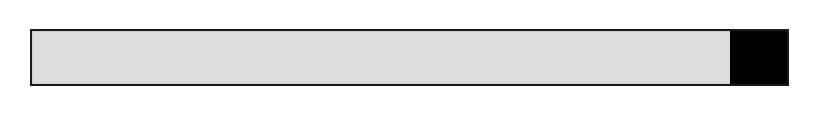

In [914]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [915]:
counter=Counter(df_cor_pn['drug_anno']).most_common()

In [916]:
a=[x[0] for x in counter]
a

['Others',
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'ERK MAPK signaling',
 'DNA inhibitor',
 'Antimetabolite',
 'EGFR signaling',
 'Antimicrotubule',
 'Apoptosis regulation',
 'Cell cycle',
 'Protein stability and degradation',
 'Hormone-related',
 'DNA alkylator',
 'PARP inhibitor',
 'WNT signaling',
 'Genome integrity',
 'Metabolism',
 'Platinum',
 'p53 pathway',
 'Topoisomerase inhibitor',
 'IGF1R signaling',
 'Cytoskeleton',
 'JNK and p38 signaling']

In [917]:
drug_order=[ 'Platinum',  'PARP inhibitor',  'Topoisomerase inhibitor',
 'DNA alkylator','DNA inhibitor', 'Antimetabolite', 
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'ERK MAPK signaling',
 'Cell cycle',
 'Antimicrotubule', 
 'Protein stability and degradation',
 'Apoptosis regulation',
 'EGFR signaling',
 'WNT signaling',
 'Genome integrity',
 'Metabolism',
 'Hormone-related',
 'IGF1R signaling',
 'p53 pathway',
 'Cytoskeleton',
 'JNK and p38 signaling']

In [918]:
anno_platinum=[]
for index in df_cor_pn.index:
    if 'isplatin' in index:
        anno_platinum.append(1)
    elif 'arboplatin' in index:
        anno_platinum.append(3)
    elif 'xaliplatin' in index:
        anno_platinum.append(2)
    else:
        anno_platinum.append(0)
df_cor_pn['platinum_color']=anno_platinum

In [919]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

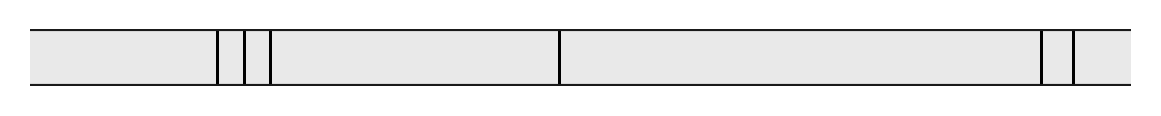

In [920]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [921]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

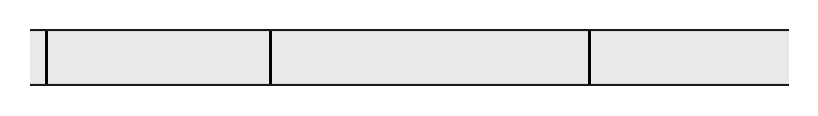

In [922]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [923]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

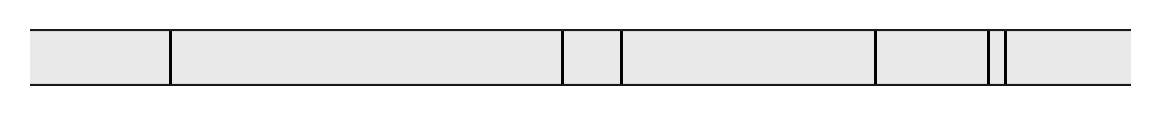

In [924]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


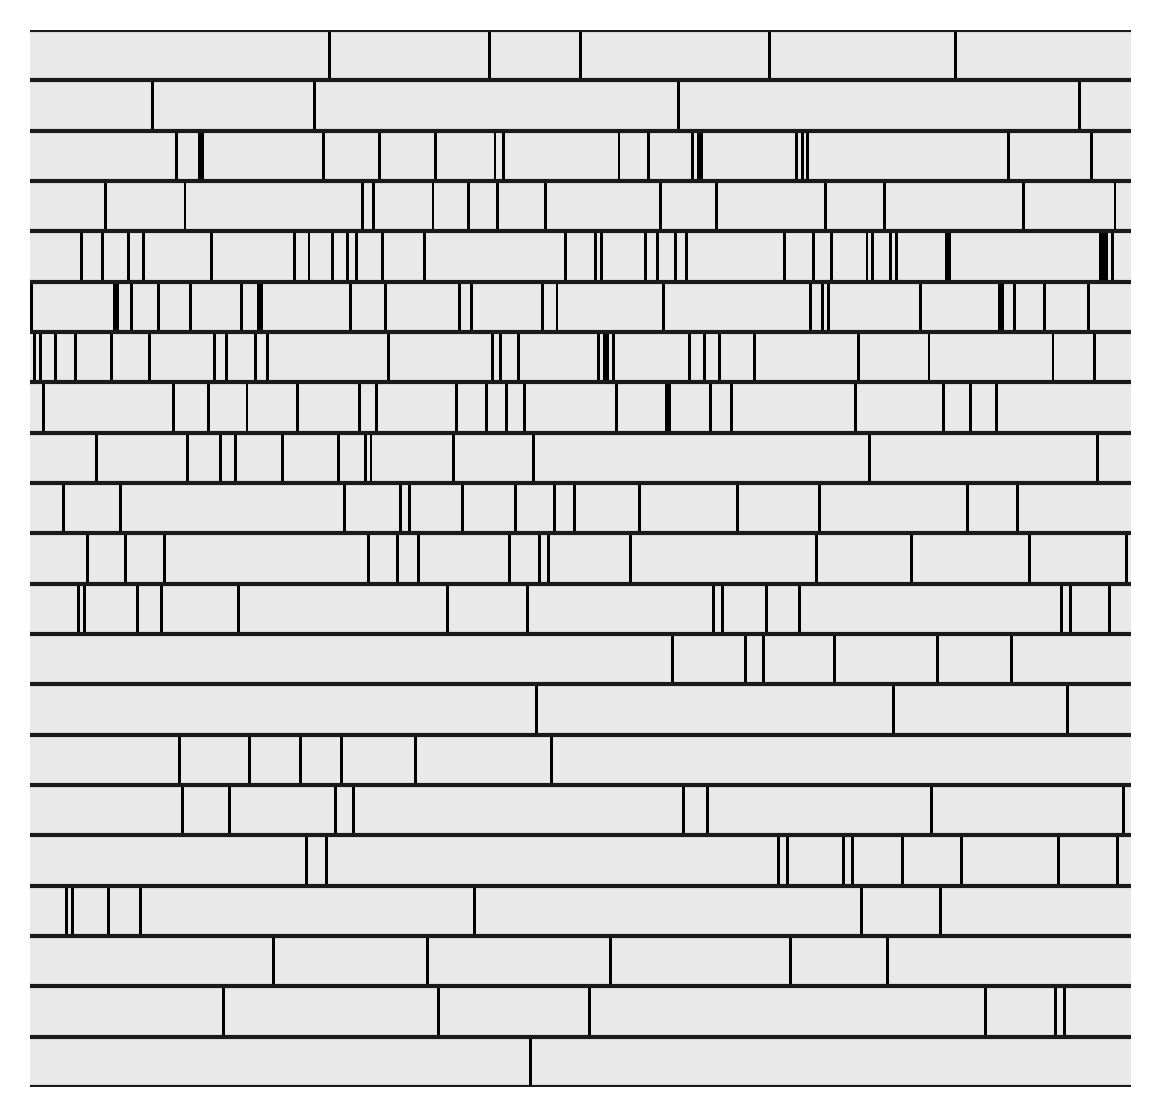

In [925]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [926]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

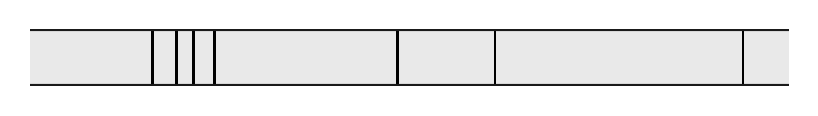

In [927]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [930]:
sns_df=in_df.reindex(columns=drug_order[2:])

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


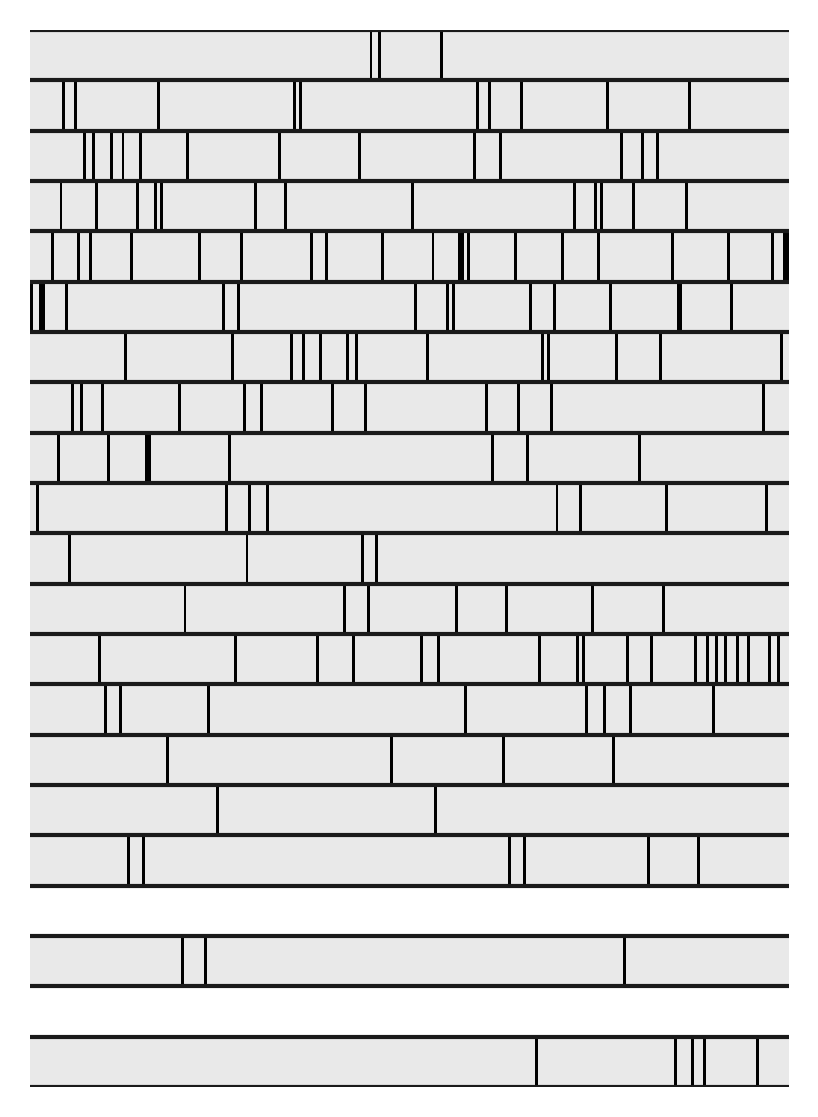

In [931]:
sns_df=in_df.reindex(columns=drug_order[2:])
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')/
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [932]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,FDR,significant,drug_anno,cid,platinum_color
GDSC2_Oxaliplatin_1089,15.0,0.013566,0.029292,0.066229,1.178950,0.294387,0,Platinum,5310940,2
GDSC2_Cisplatin_1005,16.0,0.016060,0.036034,0.077843,1.108779,0.294387,0,Platinum,84691,1
gCSI_Cisplatin_CID24191118,9.0,0.184000,0.065652,0.098129,1.008202,0.294387,0,Platinum,24191118,1
GDSC1_Cisplatin_1005,17.0,0.006537,0.023233,0.306221,0.513964,0.551199,0,Platinum,84691,1
CTRP2_carboplatin_26979,11.0,0.011000,0.034989,0.879898,0.055568,0.977609,0,Platinum,38904,3
CTRP2_oxaliplatin_375582,11.0,0.113000,0.165289,0.905944,0.042898,0.977609,0,Platinum,24197464,2
PRISM_cisplatin_BRD-K69172251-001-08-9,8.0,-0.001717,0.074962,0.977609,0.009835,0.977609,0,Platinum,24191118,1
GDSC2_Oxaliplatin_1806,15.0,-0.002216,0.014826,0.717220,0.144348,0.977609,0,Platinum,5310940,2
PRISM_oxaliplatin_BRD-K78960041-001-05-7,8.0,-0.057976,-0.081453,0.254603,0.594137,0.551199,0,Platinum,24197464,2


In [933]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,FDR,significant,drug_anno,cid,platinum_color
GDSC2_Niraparib_1177,15.0,0.014121,0.027691,0.040916,1.388109,0.265953,1,PARP inhibitor,24958200,0
CTRP2_olaparib_411867,11.0,0.341000,0.361484,0.309765,0.508968,0.865334,0,PARP inhibitor,23725625,0
GDSC2_Talazoparib_1259,14.0,0.004896,0.059593,0.347126,0.459512,0.865334,0,PARP inhibitor,44819241,0
PRISM_olaparib_BRD-K02113016-001-15-4,8.0,0.018475,-0.040218,0.693500,0.158953,0.865334,0,PARP inhibitor,23725625,0
GDSC2_Olaparib_1017,16.0,0.005442,-0.003520,0.794255,0.100040,0.865334,0,PARP inhibitor,23725625,0
GDSC1_Rucaparib_1175,17.0,0.003012,-0.002023,0.813879,0.089440,0.865334,0,PARP inhibitor,9931953,0
PRISM_talazoparib_BRD-K95142244-001-01-5,8.0,-0.070417,-0.010799,0.865334,0.062816,0.865334,0,PARP inhibitor,135565082,0
GDSC1_Olaparib_1017,17.0,-0.001055,0.003797,0.836275,0.077651,0.865334,0,PARP inhibitor,23725625,0
GDSC1_Veliparib_1018,17.0,-0.000687,0.005568,0.827898,0.082023,0.865334,0,PARP inhibitor,11960529,0
GDSC1_Talazoparib_1259,17.0,-0.006942,-0.005047,0.809560,0.091751,0.865334,0,PARP inhibitor,44819241,0


### HRR alteration

In [934]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH']).sum()

48

In [935]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
n_limit=7
for drug in drug_all:
    a=df_drug[df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
#    b=df[~df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
    b=df_drug[df_drug['BRCA_status'].isin(['wt']#,'HRR_nonLOH','BRCA2_nonLOH','BRCA1_nonLOH']
                               )][drug].dropna().values
    n=len(a)
    if n> n_limit:
#        r,p=stats.mannwhitneyu(a,b)
        r,p=stats.brunnermunzel(a,b)
        m=np.median(a)-np.median(b)
        m2=np.mean(a)-np.mean(b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
        ms.append(m)
        ms2.append(m2)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)
        ms.append(np.nan)
        ms2.append(np.nan)

In [936]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps


In [937]:
df_cor=df_cor.dropna()

In [938]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['FDR']=multipletests(df_cor['pvalues'],method='fdr_bh')[1]
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [939]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,FDR,significant,drug_anno,cid
CTRP1_ABT-737_411738,10.0,0.180200,0.095582,0.841397,0.074999,0.966998,0,Apoptosis regulation,11228183
CTRP1_ABT-751_417983,9.0,-0.102550,0.193665,0.764209,0.116788,0.940998,0,Antimicrotubule,3035714
CTRP1_BMS-641988_411807,10.0,-0.116050,0.099806,0.773341,0.111629,0.941957,0,Hormone-related,24768935
CTRP1_MLN-4924_411809,10.0,0.605050,0.195584,0.706865,0.150664,0.920142,0,Others,16720766
CTRP1_TG-101348_411808,10.0,-0.408450,0.012072,0.782387,0.106578,0.941957,0,Others,16722836
...,...,...,...,...,...,...,...,...,...
gCSI_Palbociclib_CID5330286,15.0,-0.052222,-0.040538,0.052405,1.280624,0.471487,0,Cell cycle,5330286
gCSI_Tivantinib_CID11494412,22.0,-0.042556,-0.060125,0.052454,1.280224,0.471487,0,Others,11494412
gCSI_Vincaleukoblastine_CID241902,9.0,0.022944,-0.016447,0.956511,0.019310,0.991548,0,Antimicrotubule,241902
gCSI_Vincristine_CID5978,22.0,-0.040222,-0.041721,0.222504,0.652661,0.703987,0,Others,5978


In [940]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,FDR,significant,drug_anno,cid
GDSC2_BMS-536924_1091,40.0,0.043135,0.055848,0.000079,4.100128,0.031480,1,IGF1R signaling,10390396
CTRP2_AZD4547_660325,25.0,0.837000,0.940510,0.000080,4.099110,0.031480,1,RTK signaling,51039095
GDSC2_Foretinib_2040,40.0,0.071592,0.067456,0.000132,3.879638,0.034787,1,RTK signaling,42642645
PRISM_brigatinib_BRD-K56981171-001-01-0,20.0,0.148992,0.071815,0.000342,3.465341,0.054183,1,Others,68165256
CTRP2_KW-2449_660413,28.0,1.002500,0.884322,0.000454,3.342918,0.059856,1,Others,11427553
...,...,...,...,...,...,...,...,...,...
GDSC1_Afatinib_1032,46.0,-0.019109,-0.000684,0.004421,2.354447,0.164596,1,EGFR signaling,10184653
GDSC1_NSC-87877_147,41.0,-0.002963,-0.004830,0.003526,2.452682,0.144899,1,Others,5459322
GDSC1_Avagacestat_1072,46.0,-0.008990,-0.016172,0.003266,2.485979,0.144899,1,Others,46883536
GDSC1_PHA-665752_6,18.0,-0.012144,-0.001449,0.002810,2.551232,0.144899,1,RTK signaling,10461815


In [941]:
NP=len(df_cor_p)
NN=len(df_cor_n)

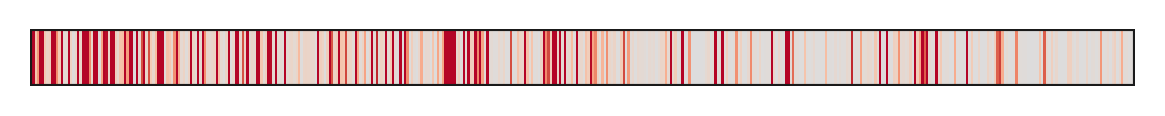

In [942]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

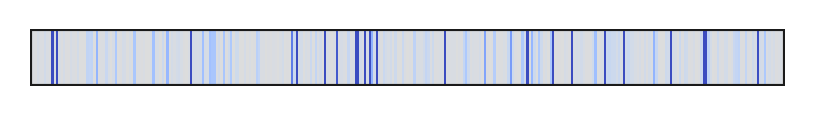

In [943]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

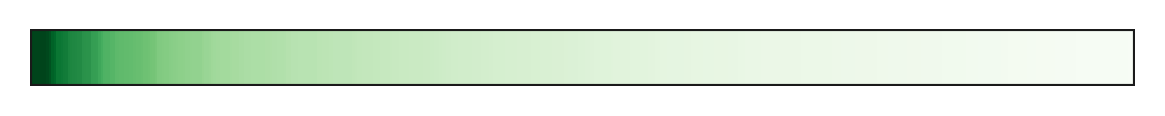

In [944]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

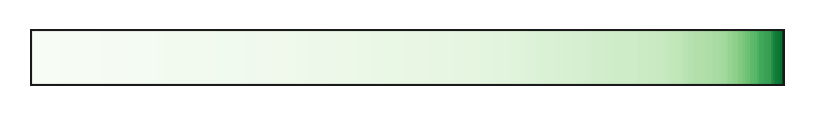

In [945]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

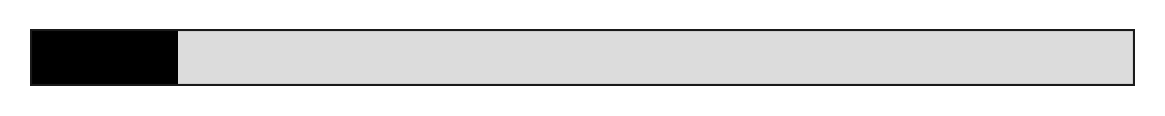

In [946]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

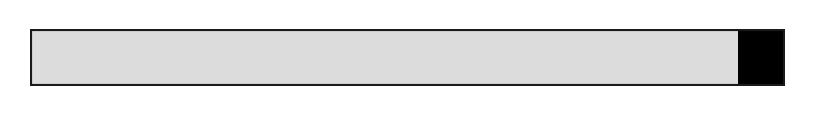

In [947]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [948]:
counter=Counter(df_cor_pn['drug_anno']).most_common()

In [949]:
a=[x[0] for x in counter]
a

['Others',
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'DNA inhibitor',
 'ERK MAPK signaling',
 'Antimetabolite',
 'Cell cycle',
 'Antimicrotubule',
 'EGFR signaling',
 'Apoptosis regulation',
 'Hormone-related',
 'Protein stability and degradation',
 'DNA alkylator',
 'PARP inhibitor',
 'Topoisomerase inhibitor',
 'Genome integrity',
 'WNT signaling',
 'Platinum',
 'Metabolism',
 'IGF1R signaling',
 'Cytoskeleton',
 'p53 pathway',
 'JNK and p38 signaling']

In [950]:
drug_order=[ 'Platinum',  'PARP inhibitor',  'Topoisomerase inhibitor',
 'DNA alkylator','DNA inhibitor', 'Antimetabolite', 
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'ERK MAPK signaling',
 'Cell cycle',
 'Antimicrotubule', 
 'Protein stability and degradation',
 'Apoptosis regulation',
 'EGFR signaling',
 'WNT signaling',
 'Genome integrity',
 'Metabolism',
 'Hormone-related',
 'IGF1R signaling',
 'p53 pathway',
 'Cytoskeleton',
 'JNK and p38 signaling']

In [951]:
anno_platinum=[]
for index in df_cor_pn.index:
    if 'isplatin' in index:
        anno_platinum.append(1)
    elif 'arboplatin' in index:
        anno_platinum.append(3)
    elif 'xaliplatin' in index:
        anno_platinum.append(2)
    else:
        anno_platinum.append(0)
df_cor_pn['platinum_color']=anno_platinum

In [952]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

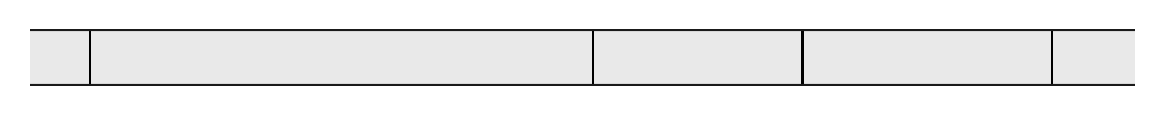

In [953]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [954]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

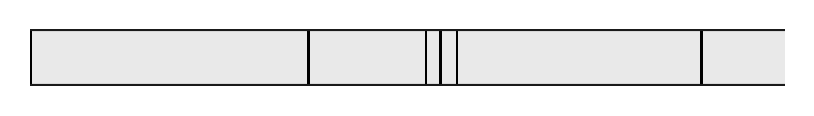

In [955]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [956]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

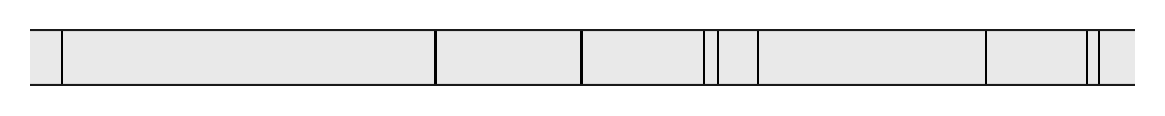

In [957]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


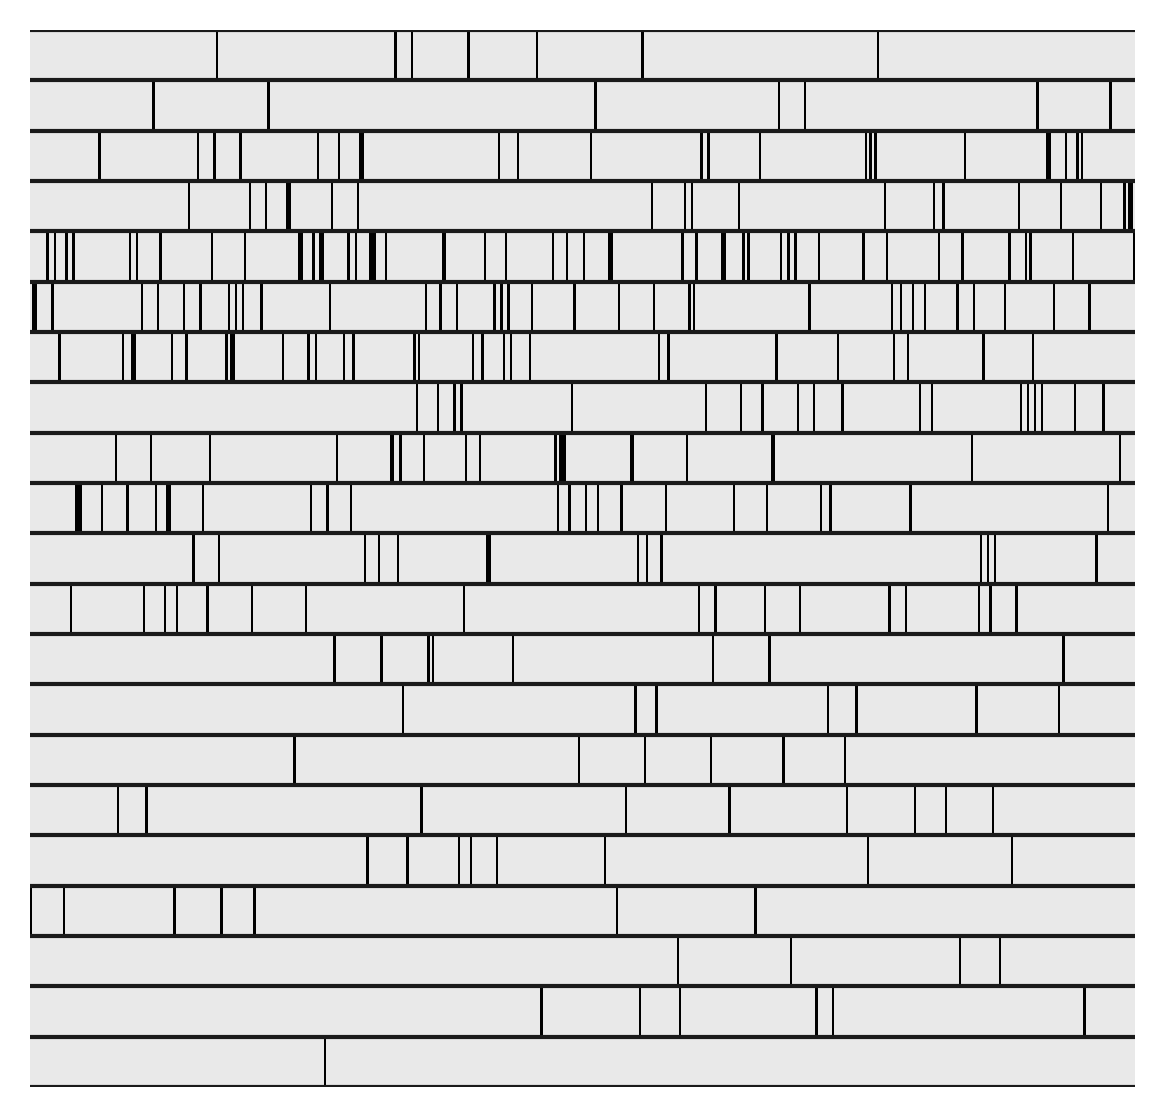

In [958]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [959]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

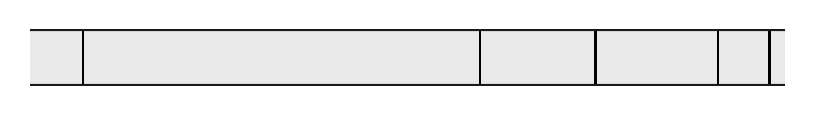

In [960]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


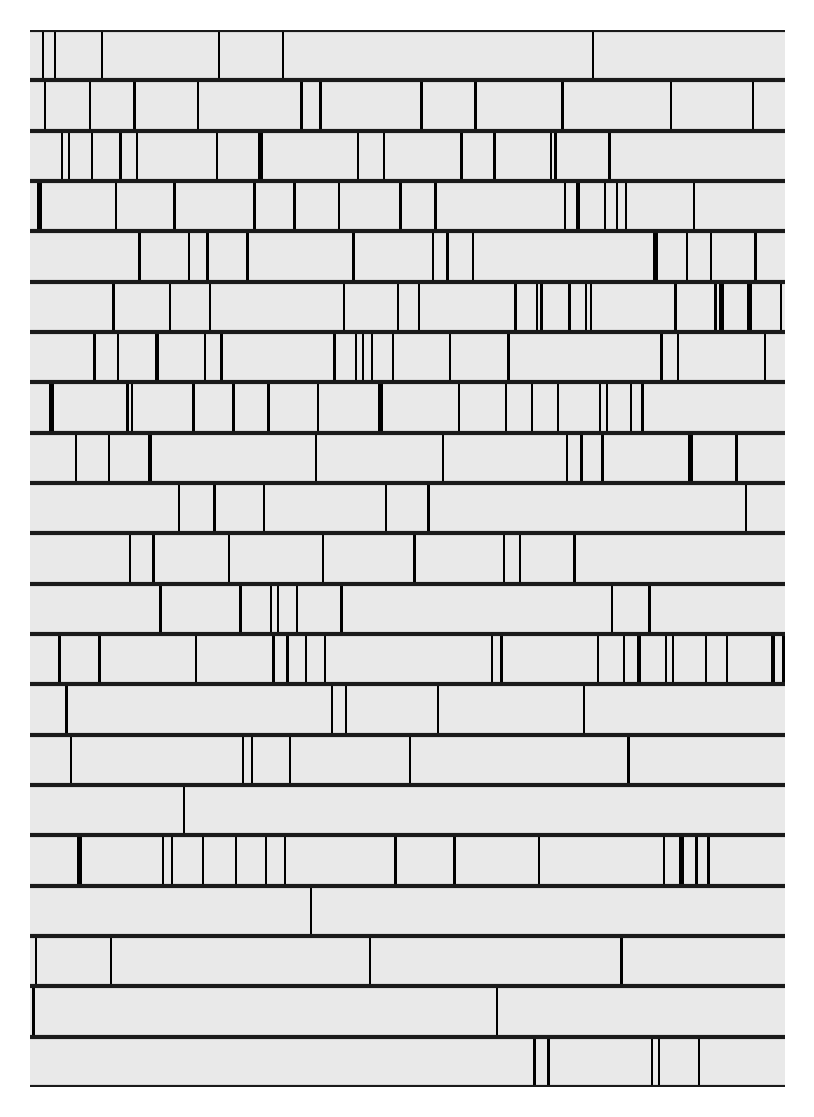

In [961]:
sns_df=in_df.reindex(columns=drug_order[2:])
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')/
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')   
#ax.set_yticklabels(sns_df.columns,fontsize=12)

In [962]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,FDR,significant,drug_anno,cid,platinum_color
gCSI_Cisplatin_CID24191118,16.0,0.171222,0.052806,0.007166,2.144747,0.071656,1,Platinum,24191118,1
CTRP2_oxaliplatin_375582,27.0,0.134000,0.267010,0.346556,0.460226,0.787749,0,Platinum,24197464,2
GDSC1_Cisplatin_1005,46.0,0.003748,0.008687,0.567847,0.245768,0.809740,0,Platinum,84691,1
PRISM_carboplatin_BRD-K90947825-001-02-7,20.0,0.048052,0.046391,0.891601,0.049830,0.990667,0,Platinum,426756,3
GDSC2_Oxaliplatin_1089,41.0,-0.002895,0.007149,0.998641,0.000591,0.998641,0,Platinum,5310940,2
GDSC2_Oxaliplatin_1806,40.0,-0.009265,0.005315,0.647792,0.188565,0.809740,0,Platinum,5310940,2
CTRP2_carboplatin_26979,28.0,-0.052500,-0.080187,0.472650,0.325461,0.787749,0,Platinum,38904,3
PRISM_cisplatin_BRD-K69172251-001-08-9,21.0,-0.009665,0.034235,0.457374,0.339729,0.787749,0,Platinum,24191118,1
GDSC2_Cisplatin_1005,41.0,-0.000736,0.014469,0.424225,0.372404,0.787749,0,Platinum,84691,1
PRISM_oxaliplatin_BRD-K78960041-001-05-7,21.0,-0.039756,-0.071567,0.105299,0.977576,0.526495,0,Platinum,24197464,2


In [963]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,FDR,significant,drug_anno,cid,platinum_color
CTRP2_olaparib_411867,27.0,0.493000,0.539656,0.003355,2.474299,0.046971,1,PARP inhibitor,23725625,0
GDSC2_Niraparib_1177,40.0,0.003406,0.014887,0.207438,0.683111,0.684507,0,PARP inhibitor,24958200,0
PRISM_olaparib_BRD-K02113016-001-19-6,18.0,0.027995,0.022187,0.328193,0.483871,0.731642,0,PARP inhibitor,23725625,0
GDSC1_Rucaparib_1175,46.0,0.002502,-0.006129,0.457317,0.339782,0.731642,0,PARP inhibitor,9931953,0
GDSC2_Olaparib_1017,41.0,0.004278,0.005306,0.470341,0.327587,0.731642,0,PARP inhibitor,23725625,0
GDSC1_Veliparib_1018,46.0,0.001044,0.003714,0.535149,0.271525,0.749209,0,PARP inhibitor,11960529,0
GDSC2_Talazoparib_1259,39.0,0.002555,0.029400,0.797523,0.098257,0.949887,0,PARP inhibitor,44819241,0
CTRP2_veliparib_606034,27.0,0.034000,0.061764,0.929565,0.031720,0.949887,0,PARP inhibitor,11960529,0
PRISM_niraparib_BRD-K54955827-001-02-2,21.0,0.012780,-0.006024,0.949887,0.022328,0.949887,0,PARP inhibitor,24958200,0
GDSC1_Olaparib_1017,46.0,-0.001048,0.005341,0.945684,0.024254,0.949887,0,PARP inhibitor,23725625,0


## Correlations with HRD score and Signature 3

(973, 2)
r = 0.403, p = 3.42e-39


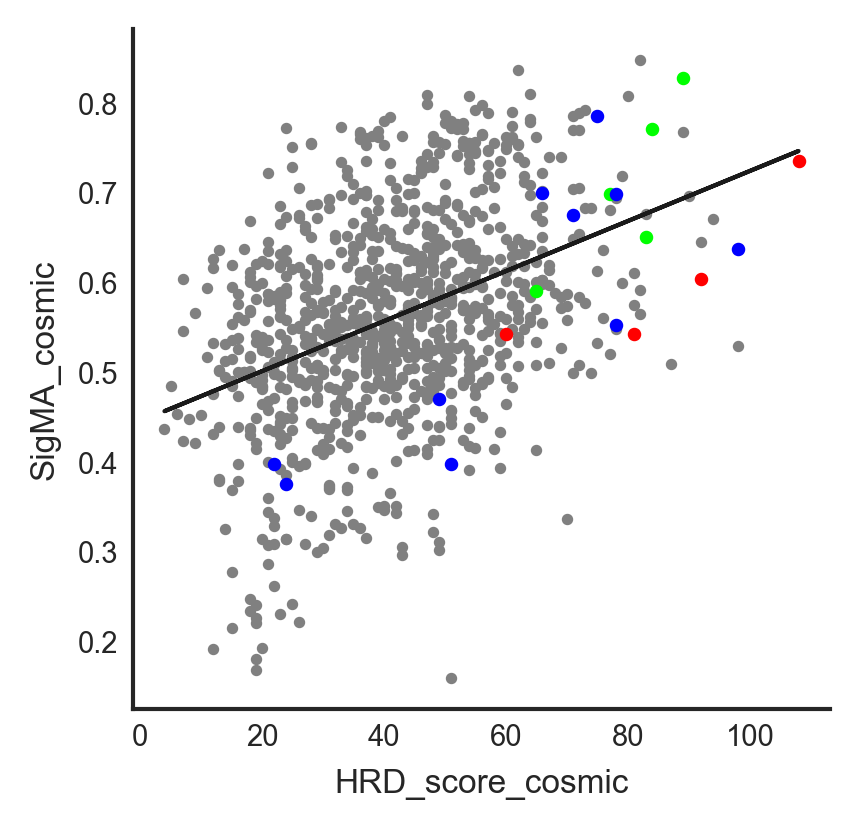

In [964]:
in_df=df2.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2,val3='HRD_score_cosmic','SigMA_cosmic','BRCA_status'
plt_df=in_df[[val1,val2]].dropna()
print(plt_df.shape)
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=3,c='grey')
ax.set_xlabel(val1)
ax.set_ylabel(val2)
# linear regression, Pearson correlation
lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,c='k')

plt_df2=in_df[[val1,val2,val3]].dropna()
plt_df3=plt_df2[plt_df2[val3]=='BRCA1_methylation']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='lime')

plt_df3=plt_df2[plt_df2[val3]=='BRCA1_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='red')

plt_df3=plt_df2[plt_df2[val3]=='BRCA2_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='blue')

ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)

print('r = {:.3f}, p = {:.2e}'.format(r,p))

In [965]:
df2['BRCA2_LOH'].sum()

10

In [966]:
df2['BRCA1_LOH'].sum()

4

/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


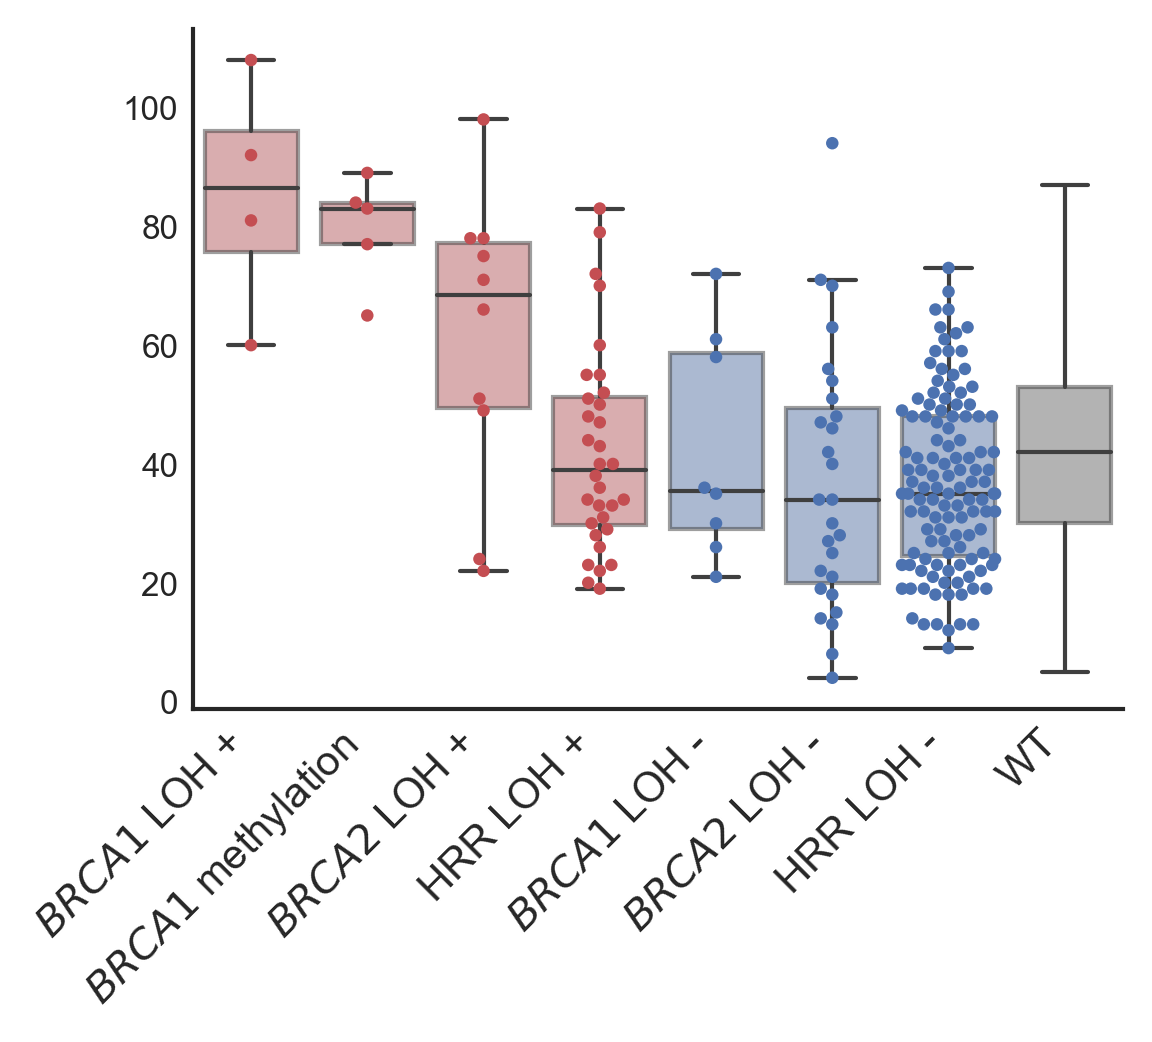

In [967]:
plt_df=df2
cat='BRCA_status'
val='HRD_score_cosmic'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


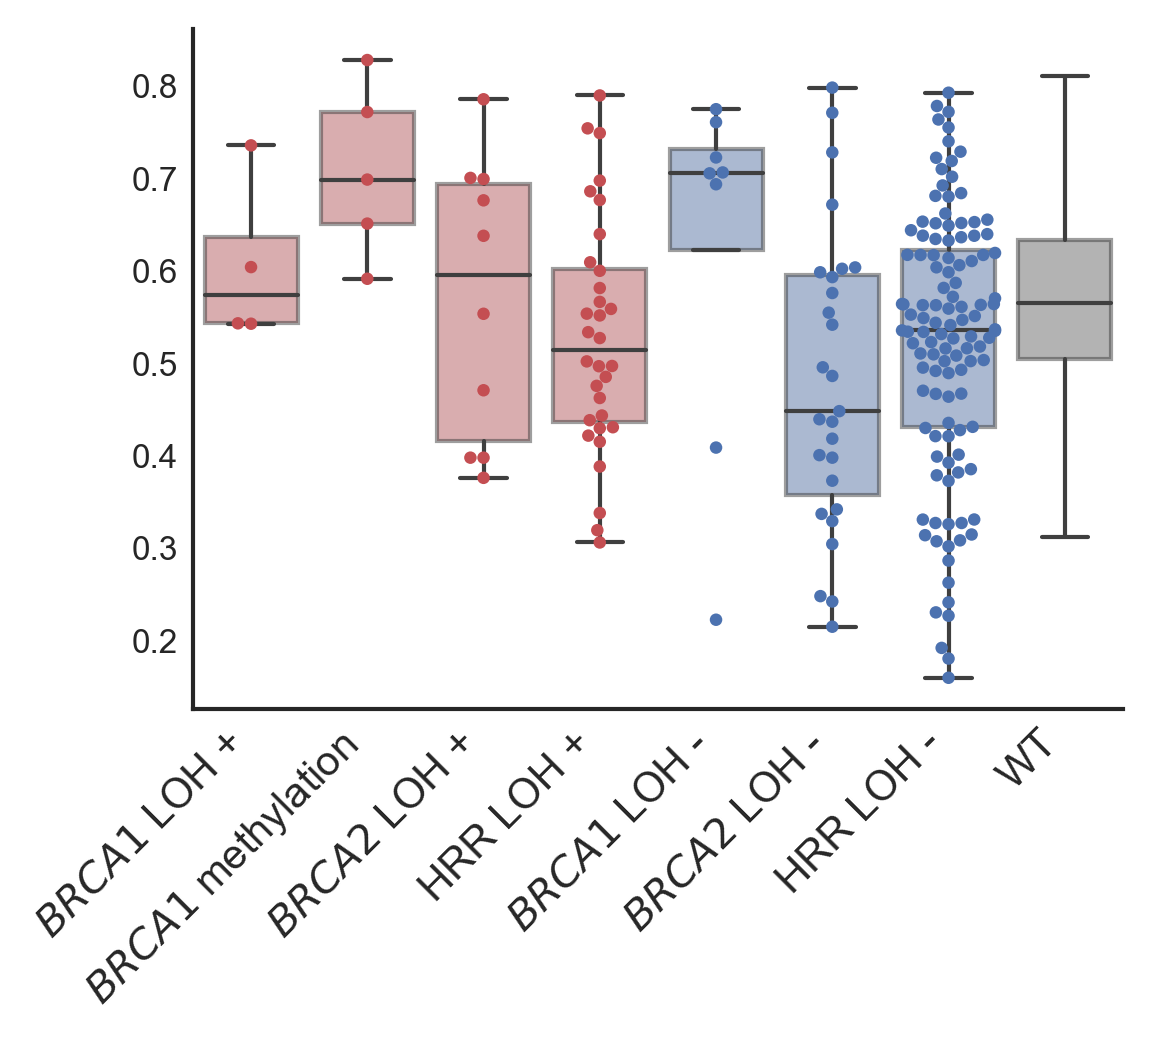

In [968]:
plt_df=df2
cat='BRCA_status'
val='SigMA_cosmic'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

## Genomic scar score and Drug sensitivity

### HRD score

In [969]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df2[['HRD_score_cosmic',drug]].dropna()
    a=plt_df['HRD_score_cosmic'].values
    b=plt_df[drug].values
    n=len(a)
    if n>= 50:
        r,p=stats.spearmanr(a,b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)

In [970]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs

In [971]:
df_cor=df_cor.dropna()

In [972]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['FDR']=multipletests(df_cor['pvalues'],method='fdr_bh')[1]
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [973]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(861, 8)

In [974]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Cytarabine_1006,743.0,3.496451e-26,0.374720,25.456373,3.010444e-23,1,Antimetabolite,6253
GDSC2_Oxaliplatin_1089,792.0,7.015871e-25,0.354609,24.153918,3.020333e-22,1,Platinum,5310940
GDSC2_Epirubicin_1511,743.0,1.593496e-22,0.347593,21.797649,4.573334e-20,1,DNA inhibitor,41867
GDSC2_Nutlin-3a (-)_1047,763.0,4.063605e-22,0.340127,21.391089,8.746910e-20,1,p53 pathway,11433190
GDSC2_Palbociclib_1054,760.0,1.343404e-19,0.320355,18.871793,2.313341e-17,1,Cell cycle,5330286
...,...,...,...,...,...,...,...,...
GDSC2_Picolinici-acid_1635,720.0,3.639639e-06,-0.171602,5.438942,2.103174e-05,1,Others,1018
GDSC1_Cetuximab_1114,853.0,1.192727e-07,-0.180064,6.923459,8.349087e-07,1,EGFR signaling,85668777
GDSC2_GDC0810_1925,743.0,7.100110e-08,-0.196097,7.148735,5.180673e-07,1,Hormone-related,56941241
GDSC2_AZD3759_1915,751.0,9.796967e-09,-0.207312,8.008908,8.435189e-08,1,EGFR signaling,78209992


In [975]:
NP=len(df_cor_p)
NN=len(df_cor_n)

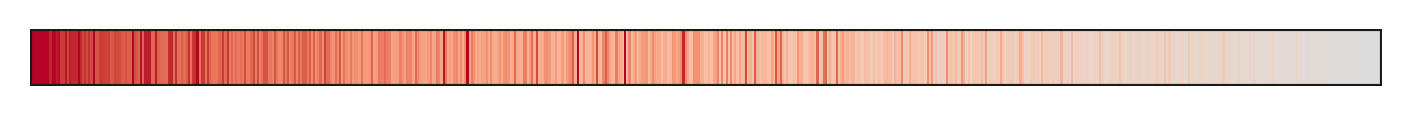

In [976]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

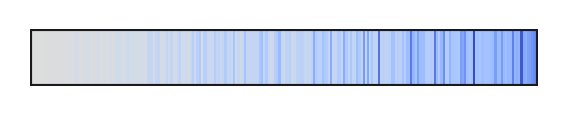

In [977]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

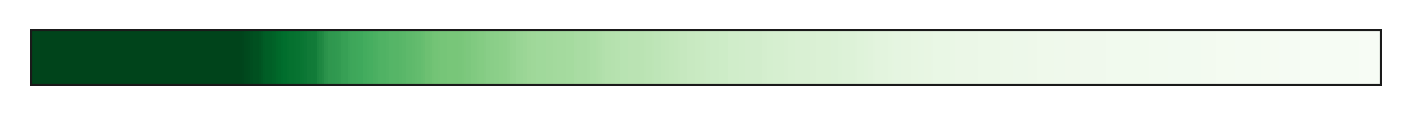

In [978]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

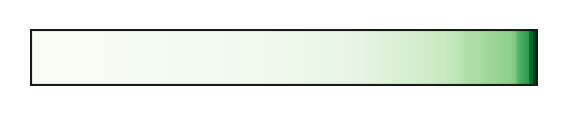

In [979]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

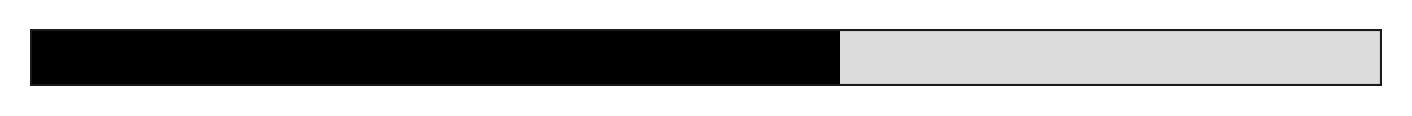

In [980]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

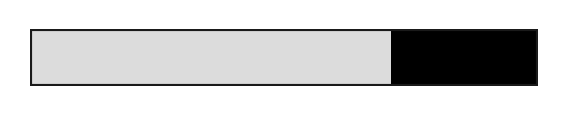

In [981]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [982]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

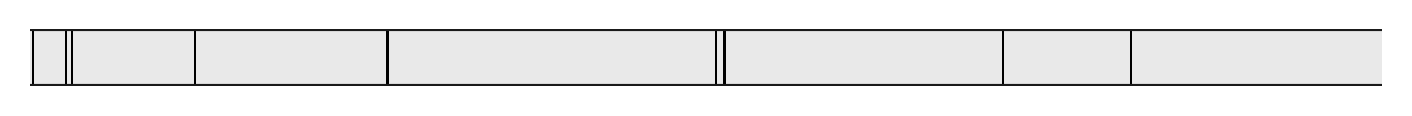

In [983]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

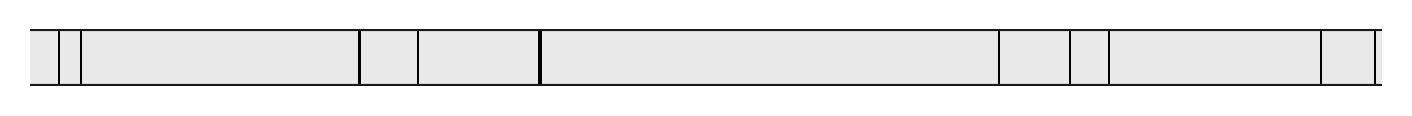

In [984]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


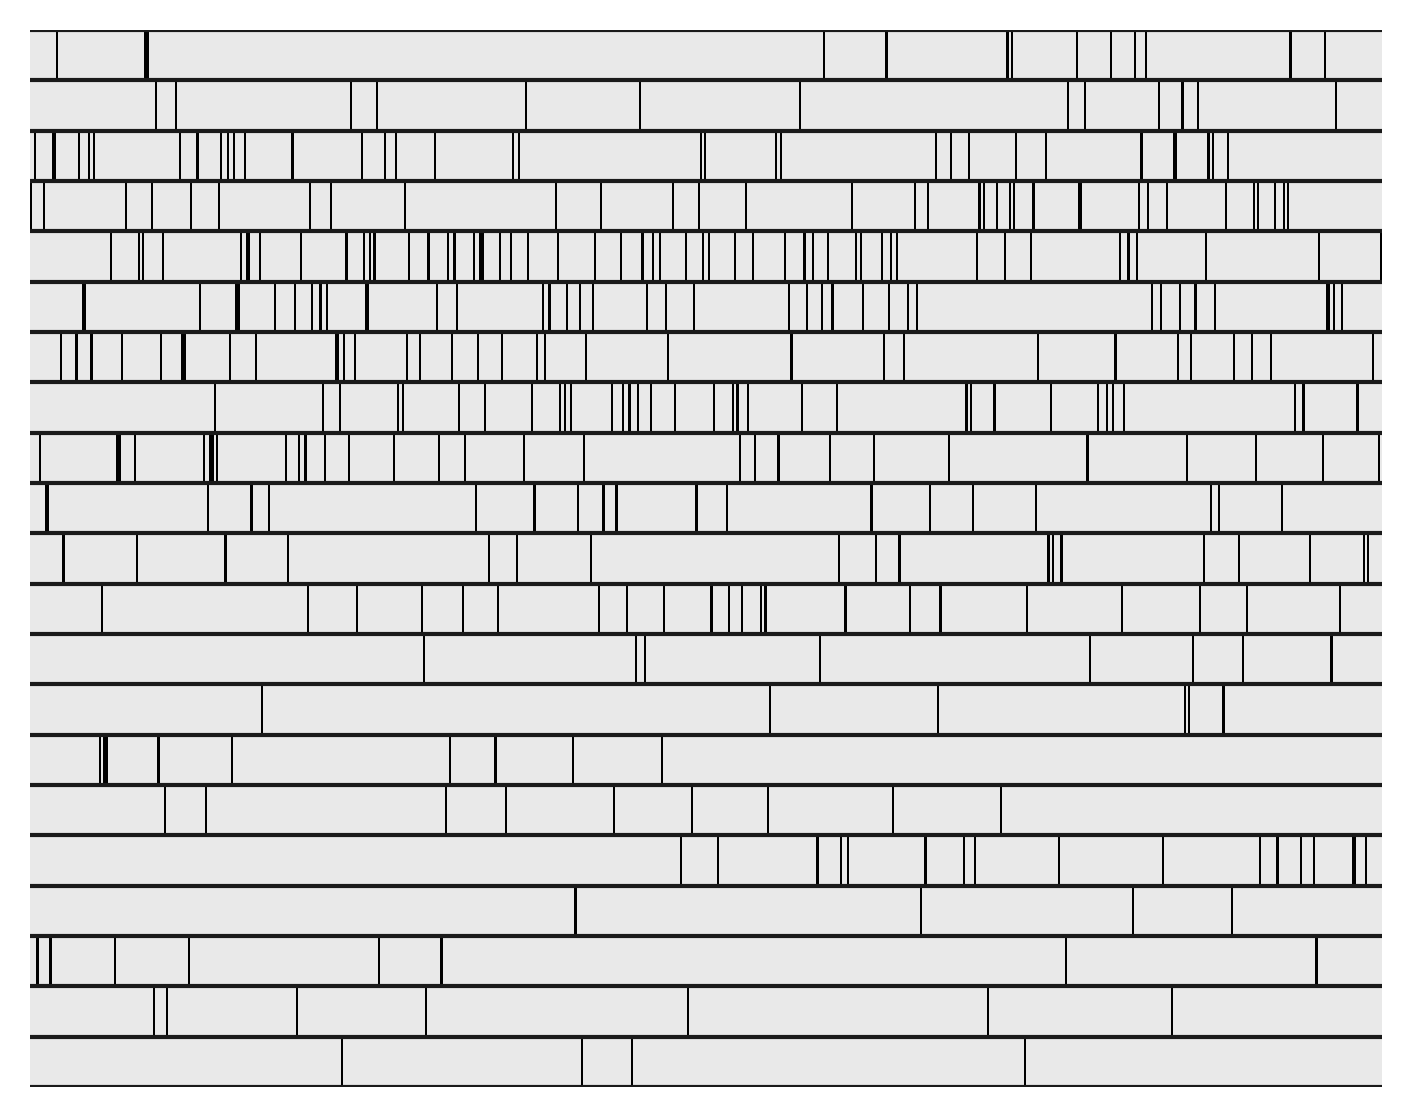

In [985]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [986]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

In [987]:
in_df['p53 pathway']=0
in_df['Cytoskeleton']=0

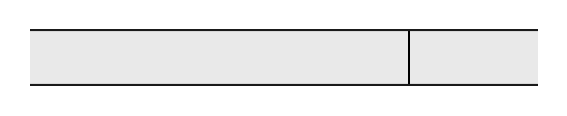

In [988]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

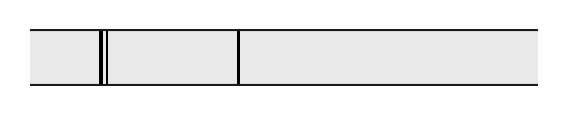

In [989]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


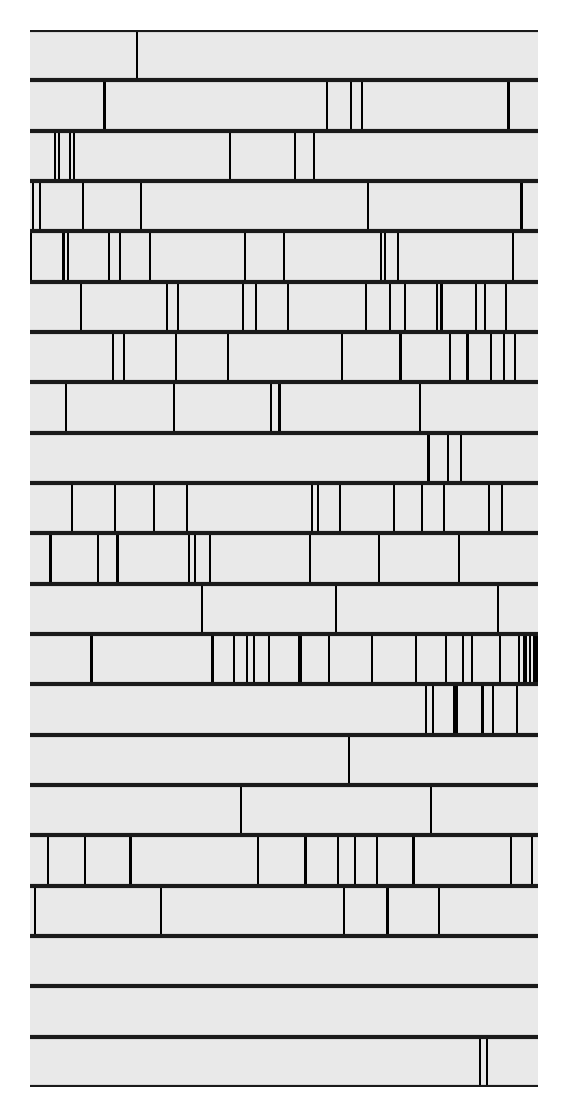

In [990]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [991]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Oxaliplatin_1089,792.0,7.015871e-25,0.354609,24.153918,7.015871e-24,1,Platinum,5310940
GDSC2_Oxaliplatin_1806,720.0,2.140423e-15,0.289780,14.669500,1.070212e-14,1,Platinum,5310940
GDSC2_Cisplatin_1005,758.0,6.159011e-15,0.278180,14.210489,2.053004e-14,1,Platinum,84691
CTRP2_oxaliplatin_375582,501.0,5.732359e-10,0.272320,9.241667,1.433090e-09,1,Platinum,24197464
CTRP2_carboplatin_26979,514.0,2.085719e-05,0.186507,4.680744,4.171438e-05,1,Platinum,38904
PRISM_oxaliplatin_BRD-K78960041-001-05-7,321.0,1.505342e-02,0.135592,1.822365,2.284357e-02,1,Platinum,24197464
GDSC1_Cisplatin_1005,923.0,1.599050e-02,0.079280,1.796138,2.284357e-02,1,Platinum,84691
gCSI_Cisplatin_CID24191118,231.0,2.623387e-01,0.074049,0.581138,2.914875e-01,0,Platinum,24191118
PRISM_carboplatin_BRD-K90947825-001-02-7,318.0,4.713720e-01,0.040533,0.326636,4.713720e-01,0,Platinum,426756
PRISM_cisplatin_BRD-K69172251-001-08-9,319.0,3.233564e-02,-0.119868,1.490319,4.041955e-02,1,Platinum,24191118


In [992]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Talazoparib_1259,739.0,3.592479e-16,0.293719,15.444606,5.388719e-15,1,PARP inhibitor,44819241
GDSC2_Niraparib_1177,720.0,1.777250e-14,0.280423,13.750251,1.332938e-13,1,PARP inhibitor,24958200
GDSC1_Olaparib_1017,921.0,8.957121e-06,0.145749,5.047832,4.478561e-05,1,PARP inhibitor,23725625
CTRP2_olaparib_411867,510.0,4.695854e-05,0.179213,4.328285,1.760945e-04,1,PARP inhibitor,23725625
GDSC1_Talazoparib_1259,888.0,9.662019e-04,0.110563,3.014932,2.447220e-03,1,PARP inhibitor,44819241
GDSC2_Olaparib_1017,752.0,9.788880e-04,0.119977,3.009267,2.447220e-03,1,PARP inhibitor,23725625
CTRP2_veliparib_606034,525.0,2.475046e-01,0.050559,0.606417,5.303671e-01,0,PARP inhibitor,11960529
GDSC1_Veliparib_1018,922.0,3.779559e-01,0.029070,0.422559,6.362857e-01,0,PARP inhibitor,11960529
PRISM_talazoparib_BRD-K95142244-001-01-5,343.0,4.241905e-01,0.043289,0.372439,6.362857e-01,0,PARP inhibitor,135565082
CTRP1_olaparib_411867,84.0,8.466380e-01,0.021421,0.072302,9.071121e-01,0,PARP inhibitor,23725625


### Signature 3 cosmic

In [993]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df2[['SigMA_cosmic',drug]].dropna()
    a=plt_df['SigMA_cosmic'].values
    b=plt_df[drug].values
    n=len(a)
    if n>= 50:
        r,p=stats.spearmanr(a,b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)

In [994]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs

In [995]:
df_cor=df_cor.dropna()

In [996]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['FDR']=multipletests(df_cor['pvalues'],method='fdr_bh')[1]
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [997]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(861, 8)

In [998]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC1_(5Z)-7-Oxozeaenol_1242,889.0,1.715645e-11,0.223126,10.765572,1.477171e-08,1,Others,9863776
GDSC1_VX-11e_262,897.0,5.680254e-11,0.216465,10.245632,2.445349e-08,1,ERK MAPK signaling,11634725
GDSC1_Dabrafenib_1373,847.0,5.113706e-10,0.211462,9.291264,1.100725e-07,1,ERK MAPK signaling,44462760
GDSC1_NVP-BHG712_295,897.0,1.073185e-09,0.201794,8.969326,1.848024e-07,1,Others,16747388
GDSC1_CI-1040_1015,906.0,1.343794e-09,0.199644,8.871667,1.928345e-07,1,ERK MAPK signaling,6918454
...,...,...,...,...,...,...,...,...
CTRP1_lonidamine_345379,84.0,3.930225e-05,-0.432783,4.405583,7.356356e-04,1,Others,39562
gCSI_Dabrafenib_CID44462760,348.0,2.325133e-05,-0.224714,4.633552,4.655673e-04,1,ERK MAPK signaling,44462760
gCSI_Crizotinib_CID54613769,355.0,1.454781e-06,-0.252417,5.837202,5.010267e-05,1,RTK signaling,54613769
gCSI_Paclitaxel_CID36314,354.0,4.385183e-09,-0.305523,8.358012,4.719553e-07,1,Antimicrotubule,36314


In [999]:
NP=len(df_cor_p)
NN=len(df_cor_n)

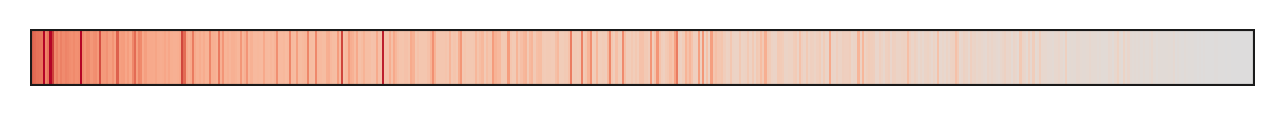

In [1000]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

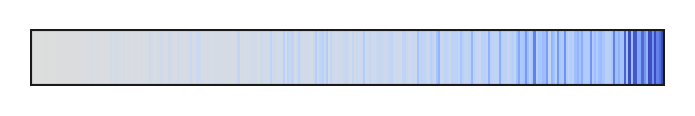

In [1001]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

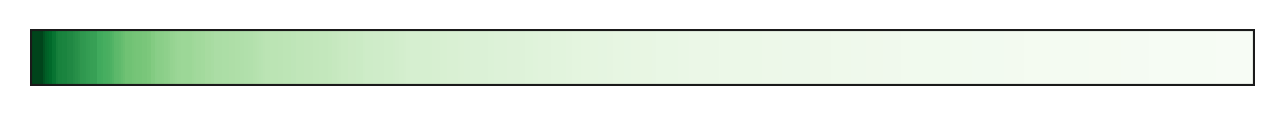

In [1002]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

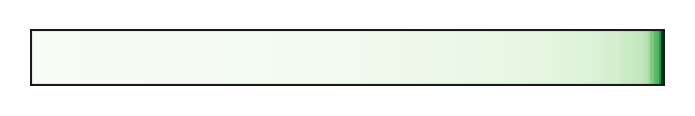

In [1003]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

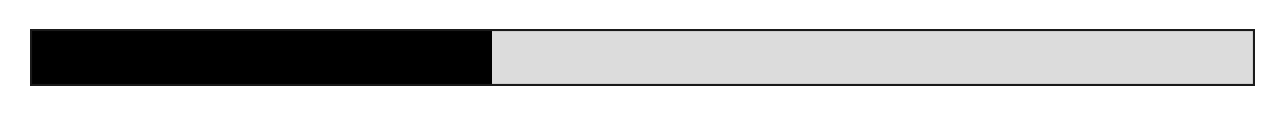

In [1004]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

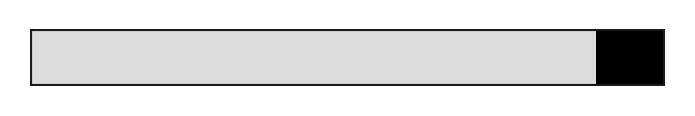

In [1005]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [1006]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

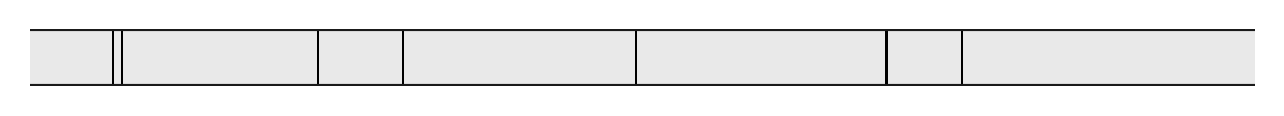

In [1007]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

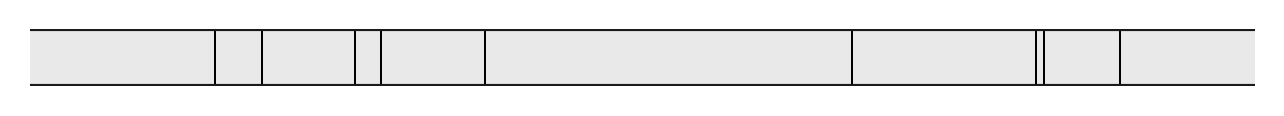

In [1008]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


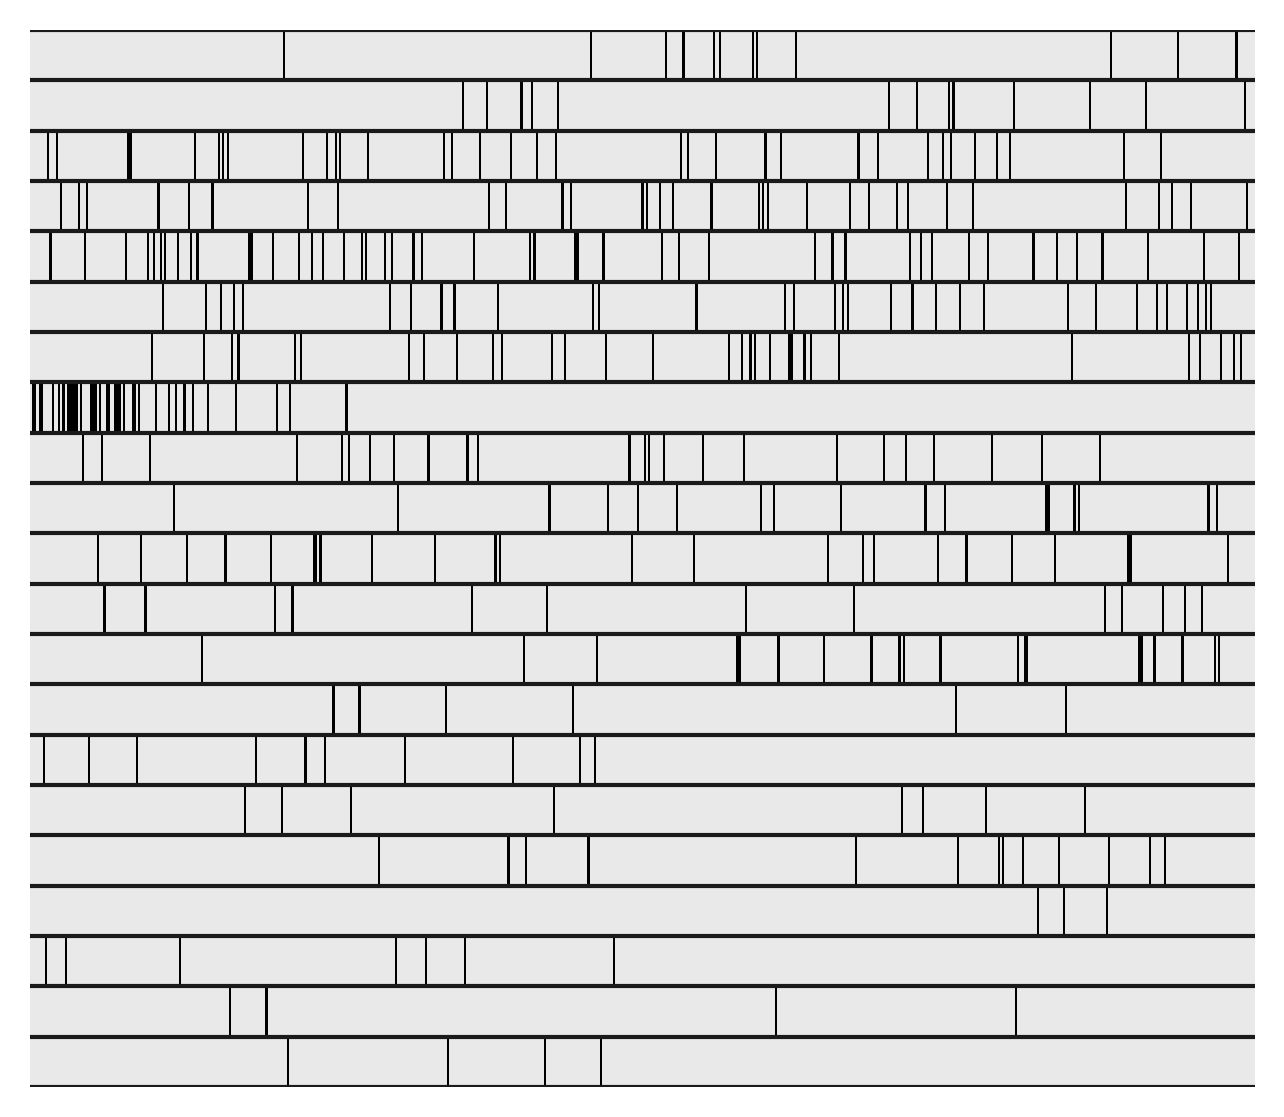

In [1009]:
sns_df=in_df[drug_order[2:]]
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [1010]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

In [1011]:
in_df['p53 pathway']=0
in_df['Cytoskeleton']=0

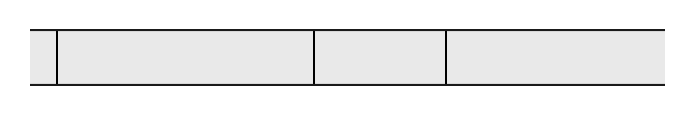

In [1012]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

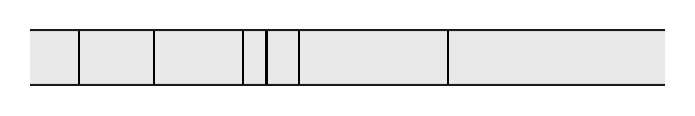

In [1013]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

Topoisomerase inhibitor
DNA alkylator
DNA inhibitor
Antimetabolite
PI3K/MTOR signaling
RTK signaling
Chromatin-related
ERK MAPK signaling
Cell cycle
Antimicrotubule
Protein stability and degradation
Apoptosis regulation
EGFR signaling
WNT signaling
Genome integrity
Metabolism
Hormone-related
IGF1R signaling
p53 pathway
Cytoskeleton
JNK and p38 signaling


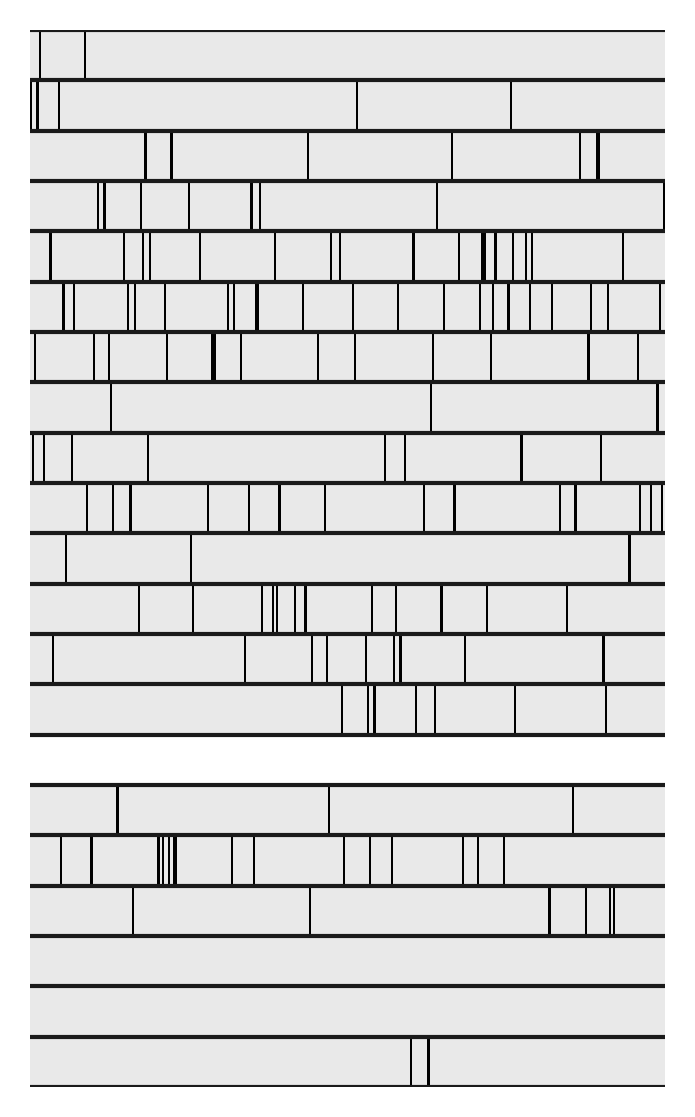

In [1014]:
sns_df=in_df.reindex(columns=drug_order[2:])
N=sns_df.shape[0]
M=sns_df.shape[1]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),M/4.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
for i,x in enumerate(sns_df.columns):
    print(x)
    ax.hlines(y=i+1,xmin=0,xmax=sns_df.shape[0],color='k')
    if i==0:
        ax.hlines(y=i,xmin=0,xmax=sns_df.shape[0],color='k')    

#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')
    

In [1015]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Oxaliplatin_1806,720.0,0.000022,0.157393,4.655382,0.000221,1,Platinum,5310940
GDSC2_Oxaliplatin_1089,791.0,0.000050,0.143759,4.305224,0.000248,1,Platinum,5310940
GDSC2_Cisplatin_1005,757.0,0.007348,0.097359,2.133817,0.024494,1,Platinum,84691
GDSC1_Cisplatin_1005,922.0,0.025371,0.073629,1.595667,0.063427,1,Platinum,84691
CTRP2_carboplatin_26979,514.0,0.136679,0.065734,0.864298,0.273358,0,Platinum,38904
PRISM_oxaliplatin_BRD-K78960041-001-05-7,320.0,0.403777,0.046830,0.393858,0.576824,0,Platinum,24197464
CTRP2_oxaliplatin_375582,501.0,0.508819,0.029584,0.293437,0.586047,0,Platinum,24197464
gCSI_Cisplatin_CID24191118,231.0,0.964023,-0.002984,0.015912,0.964023,0,Platinum,24191118
PRISM_carboplatin_BRD-K90947825-001-02-7,317.0,0.527442,-0.035621,0.277825,0.586047,0,Platinum,426756
PRISM_cisplatin_BRD-K69172251-001-08-9,318.0,0.241178,-0.065913,0.617662,0.401964,0,Platinum,24191118


In [1016]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Talazoparib_1259,738.0,0.001799,0.114721,2.744986,0.026984,1,PARP inhibitor,44819241
GDSC1_Olaparib_1017,920.0,0.004032,0.094722,2.394464,0.030241,1,PARP inhibitor,23725625
GDSC2_Niraparib_1177,720.0,0.012993,0.092534,1.886296,0.064964,1,PARP inhibitor,24958200
GDSC1_Talazoparib_1259,887.0,0.018907,0.078805,1.723370,0.070902,1,PARP inhibitor,44819241
GDSC1_Veliparib_1018,921.0,0.046852,0.065513,1.329269,0.140557,1,PARP inhibitor,11960529
GDSC1_Olaparib_1495,883.0,0.340985,0.032082,0.467265,0.730682,0,PARP inhibitor,23725625
GDSC2_Olaparib_1017,751.0,0.633154,0.017444,0.198490,0.835490,0,PARP inhibitor,23725625
PRISM_niraparib_BRD-K54955827-001-02-2,336.0,0.642378,0.025424,0.192209,0.835490,0,PARP inhibitor,24958200
PRISM_olaparib_BRD-K02113016-001-19-6,308.0,0.745015,0.018605,0.127835,0.835490,0,PARP inhibitor,23725625
PRISM_talazoparib_BRD-K95142244-001-01-5,342.0,0.925515,-0.005074,0.033617,0.925515,0,PARP inhibitor,135565082


# Broad vs COSMIC

In [1017]:
df12=df0.merge(df2[['SigMA_cosmic','HRD_score_cosmic']],left_on='COSMICID',right_index=True,how='outer')

(636, 2)
r = 0.870, p = 9.80e-197


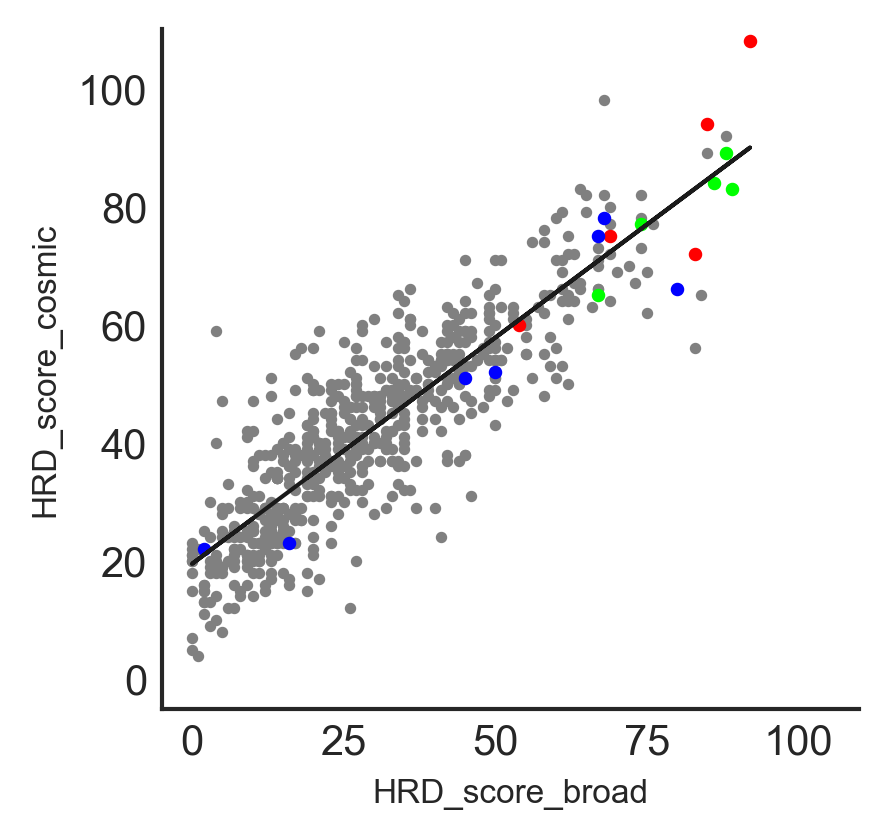

In [1018]:
in_df=df12.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2,val3='HRD_score_broad','HRD_score_cosmic','BRCA_status'
plt_df=in_df[[val1,val2]].dropna()
print(plt_df.shape)
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=3,c='grey')
ax.set_xlabel(val1)
ax.set_ylabel(val2)
# linear regression, Pearson correlation
lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,c='k')

plt_df2=in_df[[val1,val2,val3]].dropna()
plt_df3=plt_df2[plt_df2[val3]=='BRCA1_methylation']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='lime')

plt_df3=plt_df2[plt_df2[val3]=='BRCA1_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='red')

plt_df3=plt_df2[plt_df2[val3]=='BRCA2_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='blue')

ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)

print('r = {:.3f}, p = {:.2e}'.format(r,p))

ax.set_xlim(-5,110)
ax.set_ylim(-5,110)
ax.tick_params(labelsize=10)

(941, 2)
r = 0.959, p = 0.00e+00


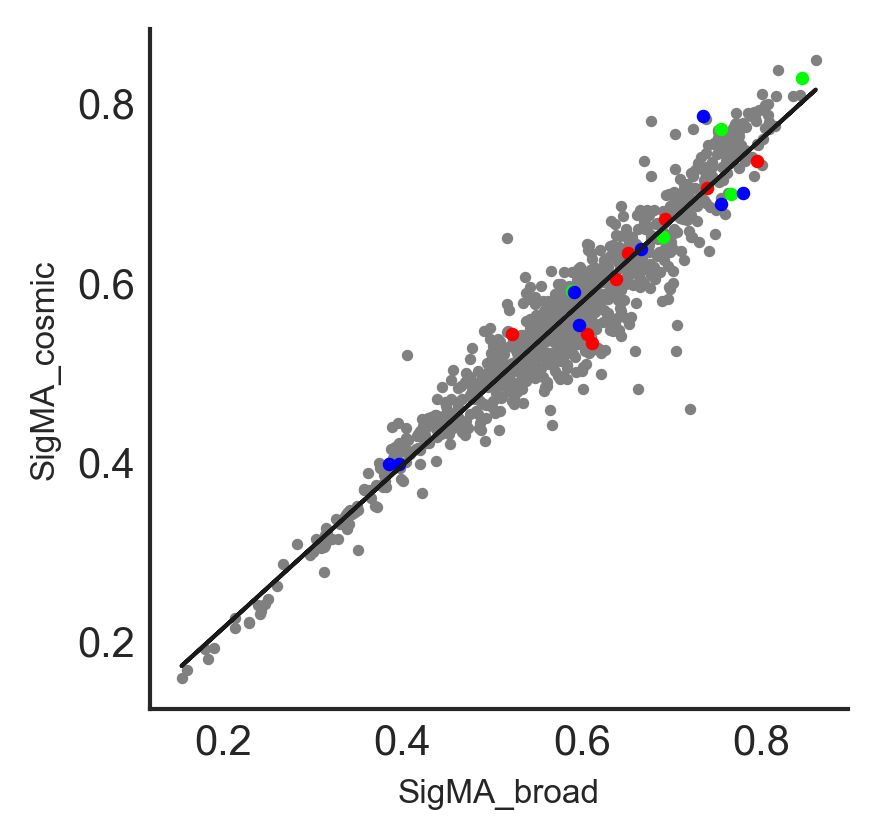

In [1019]:
in_df=df12.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2,val3='SigMA_broad','SigMA_cosmic','BRCA_status'
plt_df=in_df[[val1,val2]].dropna()
print(plt_df.shape)
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=3,c='grey')
ax.set_xlabel(val1)
ax.set_ylabel(val2)
# linear regression, Pearson correlation
lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,c='k')

plt_df2=in_df[[val1,val2,val3]].dropna()
plt_df3=plt_df2[plt_df2[val3]=='BRCA1_methylation']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='lime')

plt_df3=plt_df2[plt_df2[val3]=='BRCA1_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='red')

plt_df3=plt_df2[plt_df2[val3]=='BRCA2_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='blue')

ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)

print('r = {:.3f}, p = {:.2e}'.format(r,p))

ax.set_xticks([0.2,0.4,0.6,0.8])
ax.set_yticks([0.2,0.4,0.6,0.8])
ax.tick_params(labelsize=10)

# Exclusive with in Breast and Ovarysel_cancer

In [1020]:
df_sel=df0[df0['primary_disease'].isin(['Ovarian Cancer','Breast Cancer'])]
df_sel

,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,sample_collection_site,primary_or_metastasis,primary_disease,Subtype,age,Sanger_Model_ID,depmap_public_comments,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues,PLOIDY,PURITY,MUTATION_RATE,DOUBLING_TIME_FROM_VENDOR,DOUBLING_TIME,GENOME_DOUBLINGS,SigMA_broad,BRCA1,BRCA2,ATM,ATR,BARD1,BLM,BRIP1,CDK12,CHEK1,CHEK2,FANCA,FANCC,FANCD2,FANCE,FANCF,...,CTRP2_vandetanib_349002,CTRP2_veliparib_606034,CTRP2_vincristine_62602,CTRP2_vorapaxar_660136,CTRP2_vorinostat_56554,gCSI_Tanespimycin_CID6505803,gCSI_5-Fluorouracil_CID3385,gCSI_AZ-628_CID11676786,gCSI_AZD7762_CID11152667,gCSI_AZD8055_CID25262965,gCSI_Azacitidine_CID9444,gCSI_Bortezomib_CID387447,gCSI_Bosutinib_CID5328940,gCSI_Chir-99021_CID9956119,gCSI_Cisplatin_CID24191118,gCSI_Crizotinib_CID54613769,gCSI_Dabrafenib_CID44462760,gCSI_Dasatinib_CID3062316,gCSI_Docetaxel_CID148124,gCSI_Erastin_CID11214940,gCSI_Erlotinib_CID176871,gCSI_Etoposide_CID36462,gCSI_GSK2636771_CID56949517,gCSI_Gefitinib_CID123631,gCSI_Gemcitabine_CID356653,gCSI_Ibrutinib_CID24821094,gCSI_JQ1 compound_CID71300862,gCSI_Lapatinib_CID208908,gCSI_Lenalidomide_CID216326,gCSI_MI-2_CID54765302,gCSI_MK-2206_CID46930998,gCSI_MLN2480_CID25161177,gCSI_Methotrexate_CID126941,gCSI_NU-7441_CID11327430,gCSI_Narciclasine_CID72376,gCSI_Nilotinib_CID644241,gCSI_Oligomycin A_CID5472285,gCSI_PF-4708671_CID51371303,gCSI_PLX4720_CID24180719,gCSI_Paclitaxel_CID36314,gCSI_Palbociclib_CID5330286,gCSI_TGX221_CID9907093,gCSI_Tivantinib_CID11494412,gCSI_Vincaleukoblastine_CID241902,gCSI_Vincristine_CID5978,gCSI_Vorinostat_CID5311,HRD_score_broad,BRCA1_methylation,BRCA_status,BRCA_alteration
DepMap_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACH-000288,BT-549,BT549,BT549_BREAST,NaN,905951,Female,ATCC,CVCL_1092,1835.0,breast,Primary,Breast Cancer,Breast Ductal Carcinoma,72,SIDM00122,NaN,breast,breast_ductal_carcinoma,ERneg_HER2neg,basal_B,2D: adherent,NaN,NaN,PT-hgWgpg,NaN,Invasive breast carcinoma of no special type,C4194,NaN,1.34,1.00,100.467969,NaN,98.4,0.0,0.585270,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,...,13.512,14.589,9.5835,13.323,13.623,NaN,NaN,-0.065000,NaN,NaN,0.506444,NaN,NaN,NaN,0.353556,0.001889,0.111111,0.139,0.641000,0.199222,0.079778,NaN,0.228111,NaN,0.620889,0.032000,0.041000,0.152778,0.011444,0.207667,NaN,0.037333,0.860333,0.199222,0.908222,NaN,0.530444,0.051333,NaN,0.796556,0.014333,0.211778,0.516778,0.343222,0.384444,0.212000,19.0,0.0,wt,0
ACH-000333,JHOM-2B,JHOM2B,JHOM2B_OVARY,NaN,-1,Female,RIKEN,CVCL_4645,NaN,ovary,Primary,Ovarian Cancer,"Adenocarcinoma, mucinous",56,NaN,NaN,ovary,ovary_adenocarcinoma,mucinous,NaN,NaN,NaN,NaN,PT-60XjJv,NaN,Ovarian mucinous adenocarcinoma,C5243,NaN,2.05,1.00,142.741222,NaN,NaN,0.0,0.476021,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,0.0,wt,0
ACH-000635,SNU-119,SNU119,SNU119_OVARY,NaN,-1,Female,KCLB,CVCL_5014,NaN,ascites,Metastasis,Ovarian Cancer,"Cystadenocarcinoma, high grade serous",50,NaN,NaN,ovary,ovary_adenocarcinoma,high_grade_serous,NaN,NaN,NaN,NaN,PT-vHYCC2,NaN,High grade ovarian serous adenocarcinoma,C105555,NaN,3.12,0.99,171.736406,53 hrs,NaN,1.0,0.678921,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,...,10.976,14.526,7.6589,14.809,13.133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,1.0,BRCA1_methylation,1
ACH-001719,OCI-C4P,OCIC4P,OCIC4P_OVARY,NaN,-1,Female,Academic lab,CVCL_DH05,NaN,ovary,Primary,Ovarian Cancer,"Adenocarc

In [1021]:
Counter(df_sel['BRCA_alteration'])

Counter({0: 99, 1: 17})

In [1022]:
df_drug=df_sel[~df_sel[drug_all_set].isna().all(axis=1)]

In [1023]:
df_drug.shape

(108, 1035)

## BRCA status vs Drug sensitivity

### BRCA12 altaration

In [1024]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH']).sum()

16

In [1025]:
df_drug[~df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH'])].shape

(92, 1035)

In [1026]:
df_drug[df_drug['BRCA_status'].isin(['wt'])].shape

(68, 1035)

In [1027]:
df=df_drug.copy()

In [1028]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
n_limit=5
for drug in drug_all:
    a=df[df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH'])][drug].dropna().values
#    b=df[~df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_unknown','BRCA1_unknown'])][drug].dropna().values   
    b=df[df['BRCA_status'].isin(['wt']#,'HRR_nonLOH','HRR_LOH','BRCA2_nonLOH','HRR_unknown','BRCA1_nonLOH']
                                )][drug].dropna().values
    n=len(a)
    if n> n_limit:
        r,p=stats.mannwhitneyu(a,b)
#        r,p=stats.brunnermunzel(a,b)
        m=np.median(a)-np.median(b)
        m2=np.mean(a)-np.mean(b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
        ms.append(m)
        ms2.append(m2)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)
        ms.append(np.nan)
        ms2.append(np.nan)

In [1029]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps


In [1030]:
df_cor=df_cor.dropna()

In [1031]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [1032]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
CTRP2_ABT-199_666541,7.0,0.335000,-0.347117,0.648383,0.188168,0,Apoptosis regulation,49846579
CTRP2_ABT-737_411738,10.0,-0.055000,0.020748,0.772729,0.111973,0,Apoptosis regulation,11228183
CTRP2_AT13387_688229,6.0,-0.374700,-0.227617,0.781195,0.107241,0,Others,11955716
CTRP2_AZD1480_660306,6.0,0.070500,0.502545,0.764246,0.116767,0,Others,16659841
CTRP2_AZD4547_660325,11.0,-0.456500,-0.035041,0.360034,0.443656,0,RTK signaling,51039095
...,...,...,...,...,...,...,...,...
gCSI_PF-4708671_CID51371303,9.0,-0.027667,-0.036159,0.106069,0.974410,0,PI3K/MTOR signaling,51371303
gCSI_Paclitaxel_CID36314,7.0,-0.001944,0.007187,0.987786,0.005337,0,Antimicrotubule,36314
gCSI_Tivantinib_CID11494412,7.0,-0.041944,-0.029462,0.656608,0.182694,0,Others,11494412
gCSI_Vincristine_CID5978,7.0,-0.024778,-0.020479,0.794573,0.099866,0,Others,5978


In [1033]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
GDSC1_Vorinostat_1012,13.0,0.111457,0.121888,0.002021,2.694373,1,Chromatin-related,5311
GDSC1_AZD8055_1059,13.0,0.081386,0.071590,0.006866,2.163313,1,PI3K/MTOR signaling,25262965
GDSC2_Navitoclax_1011,10.0,0.077244,0.090903,0.017603,1.754406,1,Apoptosis regulation,24978538
GDSC1_Dactolisib_1057,13.0,0.112065,0.092064,0.017810,1.749340,1,PI3K/MTOR signaling,11977753
PRISM_abemaciclib_BRD-K33622447-066-01-9,7.0,0.060837,0.096869,0.019117,1.718581,1,Cell cycle,46220502
...,...,...,...,...,...,...,...,...
CTRP2_AZD7762_660777,11.0,-1.605200,-1.208549,0.041184,1.385270,1,Cell cycle,11152667
GDSC1_Vinorelbine_140,10.0,-0.171084,-0.137701,0.013642,1.865112,1,Antimicrotubule,5311497
GDSC2_AZD5582_1617,8.0,-0.262659,-0.173516,0.011261,1.948442,1,Apoptosis regulation,49847690
CTRP2_birinapant_660778,11.0,-1.352000,-1.458120,0.010527,1.977710,1,Others,49836020


In [1034]:
NP=len(df_cor_p)
NN=len(df_cor_n)

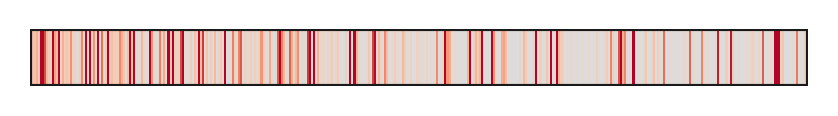

In [1035]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(6*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

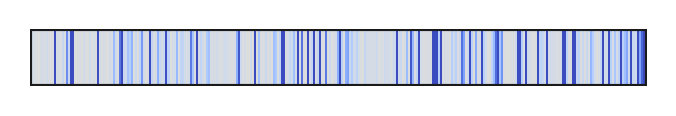

In [1036]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(6*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

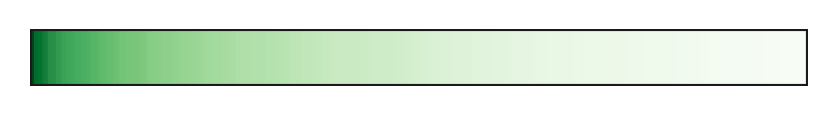

In [1037]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(6*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=2,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

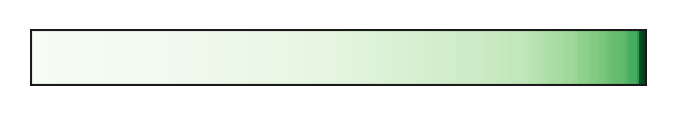

In [1038]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(6*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=2,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

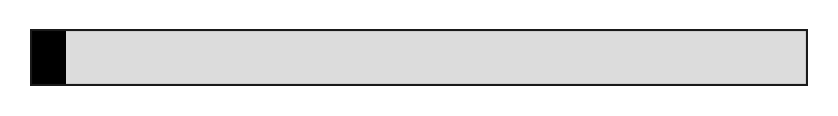

In [1039]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(6*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

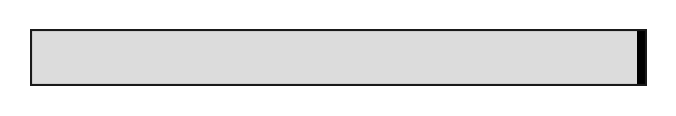

In [1040]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(6*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [1041]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

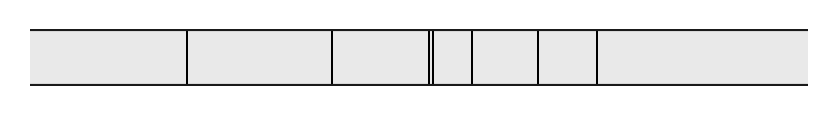

In [1042]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(6*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [1043]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

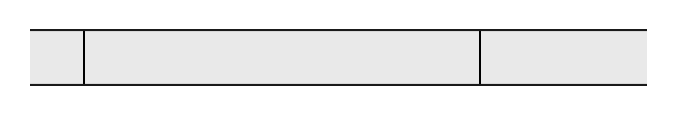

In [1044]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(6*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [1045]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

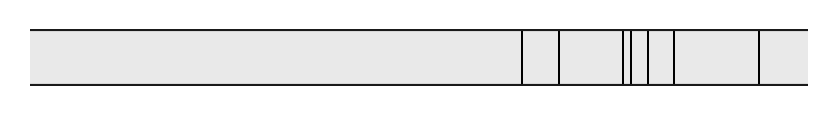

In [1046]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(6*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [1047]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

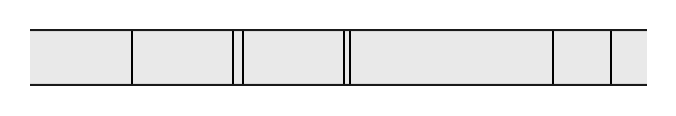

In [1048]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(6*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [1049]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,FDR
GDSC2_Oxaliplatin_1089,9.0,0.010165,0.023036,0.158084,0.801111,0,Platinum,5310940,0.749564
PRISM_oxaliplatin_BRD-K78960041-001-05-7,6.0,0.052101,0.070142,0.318137,0.497386,0,Platinum,24197464,0.749564
GDSC1_Cisplatin_1005,13.0,0.007052,0.016001,0.452705,0.344185,0,Platinum,84691,0.749564
CTRP2_oxaliplatin_375582,11.0,0.002000,0.365505,0.457829,0.339296,0,Platinum,24197464,0.749564
GDSC2_Oxaliplatin_1806,8.0,0.003053,0.015113,0.499709,0.301282,0,Platinum,5310940,0.749564
GDSC2_Cisplatin_1005,10.0,0.009957,0.011970,0.606429,0.217220,0,Platinum,84691,0.779694
CTRP2_carboplatin_26979,11.0,0.047000,-0.192754,0.695130,0.157934,0,Platinum,38904,0.782021
gCSI_Cisplatin_CID24191118,9.0,-0.025444,0.002227,0.911468,0.040259,0,Platinum,24191118,0.911468
PRISM_cisplatin_BRD-K69172251-001-08-9,6.0,-0.021881,-0.108718,0.347861,0.458594,0,Platinum,24191118,0.749564


In [1050]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,FDR
PRISM_niraparib_BRD-K54955827-001-02-2,7.0,0.000882,-0.006946,0.574478,0.240727,0,PARP inhibitor,24958200,0.918543
CTRP2_veliparib_606034,11.0,0.100500,0.004351,0.649024,0.187739,0,PARP inhibitor,11960529,0.918543
CTRP2_olaparib_411867,11.0,0.116000,-0.143277,0.740745,0.130331,0,PARP inhibitor,23725625,0.918543
GDSC1_Veliparib_1018,13.0,0.000513,0.002802,0.751204,0.124242,0,PARP inhibitor,11960529,0.918543
GDSC2_Niraparib_1177,8.0,0.001367,0.007262,0.765283,0.116178,0,PARP inhibitor,24958200,0.918543
GDSC1_Rucaparib_1175,13.0,0.005778,0.003404,0.795340,0.099447,0,PARP inhibitor,9931953,0.918543
PRISM_olaparib_BRD-K02113016-001-19-6,6.0,0.033195,-0.016343,0.938846,0.027406,0,PARP inhibitor,23725625,0.938846
PRISM_talazoparib_BRD-K95142244-001-01-5,7.0,-0.142761,-0.019207,0.852933,0.069085,0,PARP inhibitor,135565082,0.918543
GDSC2_Talazoparib_1259,9.0,-0.006032,0.014635,0.710365,0.148518,0,PARP inhibitor,44819241,0.918543
GDSC1_Olaparib_1017,13.0,-0.004335,0.004226,0.688798,0.161908,0,PARP inhibitor,23725625,0.918543


### HRR alteration

In [1051]:
df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH']).sum()

25

In [1052]:
df_drug[~df_drug['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])].shape

(83, 1035)

In [1053]:
ns,rs,ps,ms,ms2=[],[],[],[],[]
n_limit=5
for drug in drug_all:
    a=df[df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
#    b=df[~df['BRCA_status'].isin(['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH'])][drug].dropna().values
    b=df[df['BRCA_status'].isin(['wt'])][drug].dropna().values
    n=len(a)
    if n> n_limit:
        r,p=stats.mannwhitneyu(a,b)
#        r,p=stats.brunnermunzel(a,b)
        m=np.median(a)-np.median(b)
        m2=np.mean(a)-np.mean(b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
        ms.append(m)
        ms2.append(m2)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)
        ms.append(np.nan)
        ms2.append(np.nan)

In [1054]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['med_dif']=ms
df_cor['mean_dif']=ms2
df_cor['pvalues']=ps

In [1055]:
df_cor=df_cor.dropna()

In [1056]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [1057]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
CTRP1_ABT-737_411738,7.0,-1.115150,-0.179736,0.400258,0.397660,0,Apoptosis regulation,11228183
CTRP1_ABT-751_417983,7.0,-1.578300,-1.020021,0.148951,0.826957,0,Antimicrotubule,3035714
CTRP1_BI-2536_347813,6.0,-1.148100,-1.305378,0.028527,1.544741,1,Cell cycle,11364421
CTRP1_BMS-641988_411807,7.0,-0.164050,-0.129864,0.287169,0.541863,0,Hormone-related,24768935
CTRP1_BMS-754807_417981,6.0,-1.349500,-1.417009,0.016733,1.776426,1,RTK signaling,24785538
...,...,...,...,...,...,...,...,...
gCSI_Palbociclib_CID5330286,8.0,-0.031778,-0.029563,0.338829,0.470019,0,Cell cycle,5330286
gCSI_TGX221_CID9907093,8.0,0.044444,0.028153,0.512684,0.290150,0,PI3K/MTOR signaling,9907093
gCSI_Tivantinib_CID11494412,11.0,-0.041944,0.001013,0.876229,0.057382,0,Others,11494412
gCSI_Vincristine_CID5978,11.0,-0.024778,0.006644,0.876229,0.057382,0,Others,5978


In [1058]:
df_cor_p=df_cor[df_cor['med_dif']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['med_dif']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid
GDSC2_Buparlisib_1873,17.0,0.050812,0.056758,0.002875,2.541320,1,PI3K/MTOR signaling,16654980
GDSC1_TW 37_1149,20.0,0.153210,0.108045,0.003116,2.506339,1,Apoptosis regulation,11455910
GDSC1_Vorinostat_1012,20.0,0.088250,0.096527,0.004635,2.333971,1,Chromatin-related,5311
GDSC1_CCT-018159_1170,20.0,0.043502,0.034026,0.006062,2.217366,1,Protein stability and degradation,5327091
PRISM_abemaciclib_BRD-K33622447-066-01-9,11.0,0.060837,0.091808,0.007618,2.118175,1,Cell cycle,46220502
...,...,...,...,...,...,...,...,...
CTRP1_BMS-754807_417981,6.0,-1.349500,-1.417009,0.016733,1.776426,1,RTK signaling,24785538
gCSI_Dabrafenib_CID44462760,11.0,-0.033778,-0.107826,0.012348,1.908413,1,ERK MAPK signaling,44462760
CTRP2_cyanoquinoline 11_417415,8.0,-0.573000,-0.653835,0.005778,2.238204,1,Others,-1
CTRP2_birinapant_660778,16.0,-1.464500,-1.702507,0.001571,2.803799,1,Others,49836020


In [1059]:
NP=len(df_cor_p)
NN=len(df_cor_n)

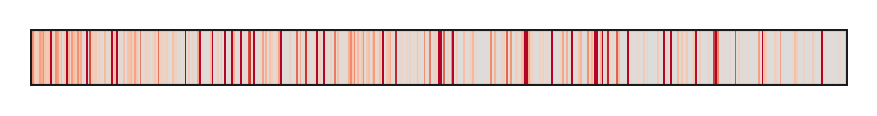

In [1060]:
sns_df=df_cor_p[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(6*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

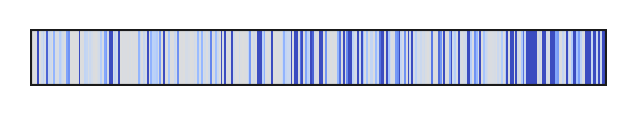

In [1061]:
sns_df=df_cor_n[['med_dif']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(6*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,
           yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

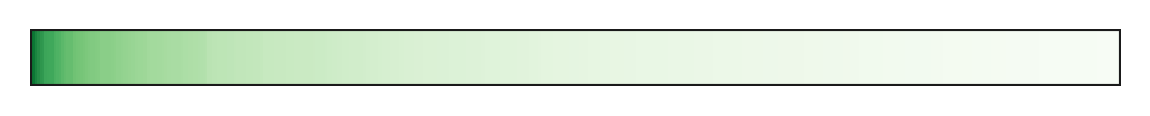

In [1062]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

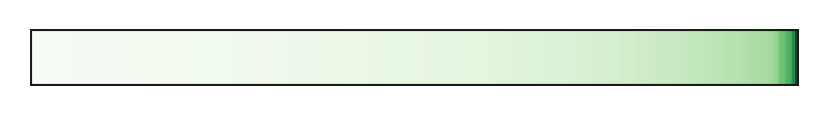

In [1063]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=3,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

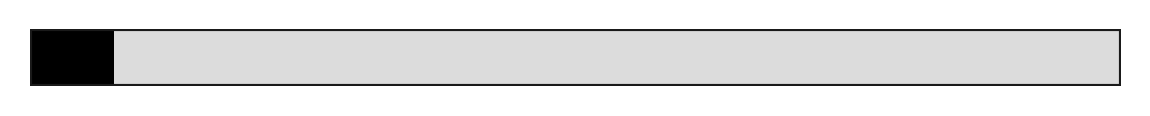

In [1064]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

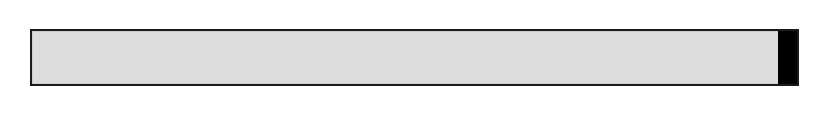

In [1065]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [1066]:
counter=Counter(df_cor_pn['drug_anno']).most_common()

In [1067]:
a=[x[0] for x in counter]
a

['Others',
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'DNA inhibitor',
 'ERK MAPK signaling',
 'Antimetabolite',
 'Cell cycle',
 'EGFR signaling',
 'Antimicrotubule',
 'Apoptosis regulation',
 'Protein stability and degradation',
 'Hormone-related',
 'DNA alkylator',
 'PARP inhibitor',
 'Topoisomerase inhibitor',
 'Genome integrity',
 'WNT signaling',
 'Platinum',
 'Metabolism',
 'IGF1R signaling',
 'Cytoskeleton',
 'p53 pathway',
 'JNK and p38 signaling']

In [1068]:
drug_order=[ 'Platinum',  'PARP inhibitor',  'Topoisomerase inhibitor',
 'DNA alkylator','DNA inhibitor', 'Antimetabolite', 
 'PI3K/MTOR signaling',
 'RTK signaling',
 'Chromatin-related',
 'ERK MAPK signaling',
 'Cell cycle',
 'Antimicrotubule', 
 'Protein stability and degradation',
 'Apoptosis regulation',
 'EGFR signaling',
 'WNT signaling',
 'Genome integrity',
 'Metabolism',
 'Hormone-related',
 'IGF1R signaling',
 'p53 pathway',
 'Cytoskeleton',
 'JNK and p38 signaling']

In [1069]:
anno_platinum=[]
for index in df_cor_pn.index:
    if 'isplatin' in index:
        anno_platinum.append(1)
    elif 'arboplatin' in index:
        anno_platinum.append(3)
    elif 'xaliplatin' in index:
        anno_platinum.append(2)
    else:
        anno_platinum.append(0)
df_cor_pn['platinum_color']=anno_platinum

In [1070]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

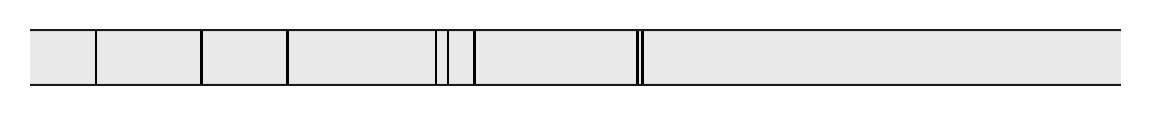

In [1071]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [1072]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

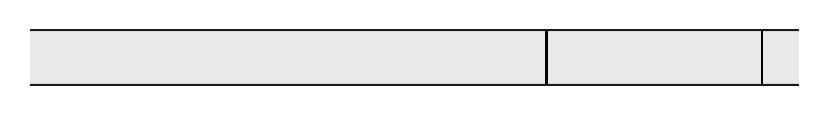

In [1073]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [1074]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

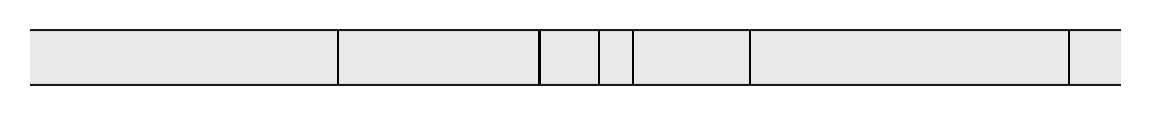

In [1075]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [1076]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

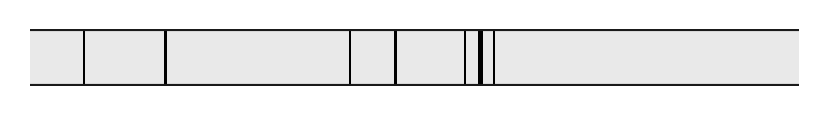

In [1077]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [1078]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,platinum_color,FDR
PRISM_oxaliplatin_BRD-K78960041-001-05-7,10.0,0.082144,0.132910,0.041479,1.382167,1,Platinum,24197464,2,0.357496
PRISM_carboplatin_BRD-K90947825-001-02-7,9.0,0.203643,0.180027,0.107249,0.969607,0,Platinum,426756,3,0.357496
GDSC2_Oxaliplatin_1089,17.0,0.010165,0.019404,0.186487,0.729351,0,Platinum,5310940,2,0.433714
CTRP2_oxaliplatin_375582,16.0,0.191000,0.374090,0.313295,0.504047,0,Platinum,24197464,2,0.433714
GDSC1_Cisplatin_1005,20.0,0.013929,0.015475,0.321850,0.492346,0,Platinum,84691,1,0.433714
gCSI_Cisplatin_CID24191118,12.0,0.158889,0.074390,0.333299,0.477167,0,Platinum,24191118,1,0.433714
GDSC2_Oxaliplatin_1806,13.0,0.004583,0.008705,0.496994,0.303649,0,Platinum,5310940,2,0.497160
GDSC2_Cisplatin_1005,18.0,0.007706,0.010610,0.497160,0.303504,0,Platinum,84691,1,0.497160
PRISM_cisplatin_BRD-K69172251-001-08-9,10.0,-0.021881,-0.064648,0.346971,0.459706,0,Platinum,24191118,1,0.433714
CTRP2_carboplatin_26979,17.0,-0.179000,-0.427786,0.091295,1.039552,0,Platinum,38904,3,0.357496


In [1079]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,med_dif,mean_dif,pvalues,mlog10p,significant,drug_anno,cid,platinum_color,FDR
GDSC2_Talazoparib_1259,17.0,0.021160,0.023576,0.224362,0.649051,0,PARP inhibitor,44819241,0,0.765971
GDSC1_Rucaparib_1175,20.0,0.006450,0.006751,0.393617,0.404927,0,PARP inhibitor,9931953,0,0.765971
CTRP2_olaparib_411867,16.0,0.061500,-0.194652,0.456745,0.340326,0,PARP inhibitor,23725625,0,0.765971
GDSC2_Niraparib_1177,13.0,0.004267,0.009930,0.494310,0.306001,0,PARP inhibitor,24958200,0,0.765971
PRISM_olaparib_BRD-K02113016-001-19-6,10.0,0.026362,-0.031064,0.601834,0.220523,0,PARP inhibitor,23725625,0,0.765971
PRISM_talazoparib_BRD-K95142244-001-01-5,11.0,0.015037,0.010431,0.950374,0.022106,0,PARP inhibitor,135565082,0,0.950374
GDSC1_Veliparib_1018,20.0,-0.000031,0.004012,0.903346,0.044146,0,PARP inhibitor,11960529,0,0.950374
GDSC1_Olaparib_1017,20.0,-0.002336,0.005082,0.803157,0.095200,0,PARP inhibitor,23725625,0,0.937016
GDSC1_Olaparib_1495,20.0,-0.010069,-0.007203,0.554169,0.256358,0,PARP inhibitor,23725625,0,0.765971
GDSC2_Olaparib_1017,18.0,-0.004052,-0.002076,0.503178,0.298278,0,PARP inhibitor,23725625,0,0.765971


## Correlations with HRD score and Signature 3

In [1080]:
df=df_sel.copy()

(99, 2)
r = 0.634, p = 1.90e-12


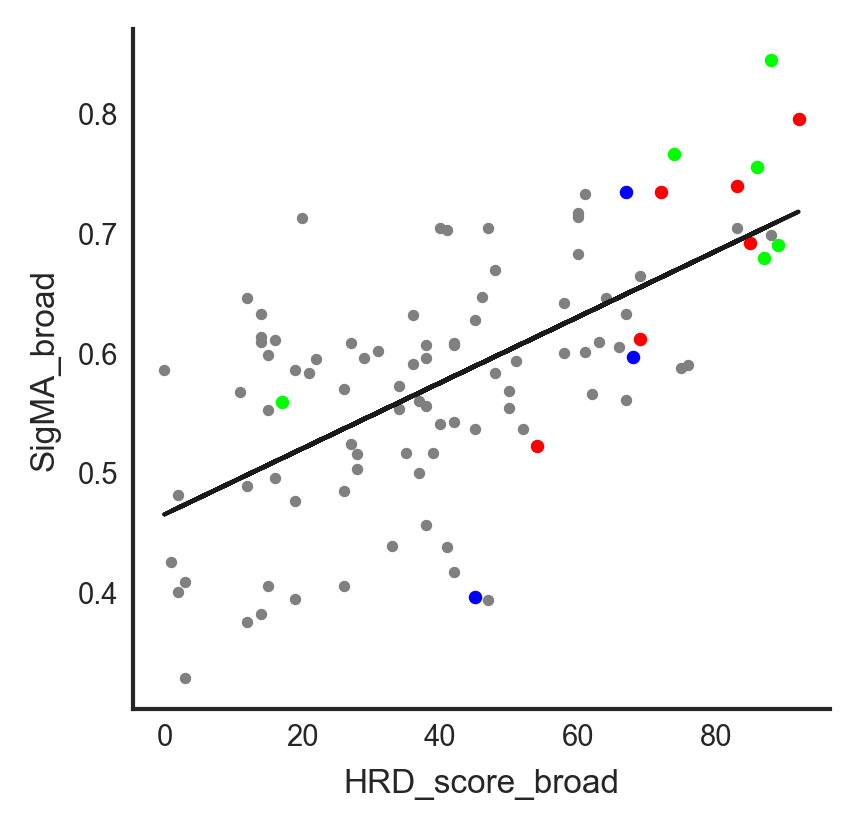

In [1081]:
in_df=df.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2,val3='HRD_score_broad','SigMA_broad','BRCA_status'
plt_df=in_df[[val1,val2]].dropna()
print(plt_df.shape)
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=3,c='grey')
ax.set_xlabel(val1)
ax.set_ylabel(val2)
# linear regression, Pearson correlation
lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,c='k')

plt_df2=in_df[[val1,val2,val3]].dropna()
plt_df3=plt_df2[plt_df2[val3]=='BRCA1_methylation']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='lime')

plt_df3=plt_df2[plt_df2[val3]=='BRCA1_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='red')

plt_df3=plt_df2[plt_df2[val3]=='BRCA2_LOH']
x1,y1=plt_df3[val1],plt_df3[val2]
ax.scatter(x1,y1,s=5,c='blue')

ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)

print('r = {:.3f}, p = {:.2e}'.format(r,p))

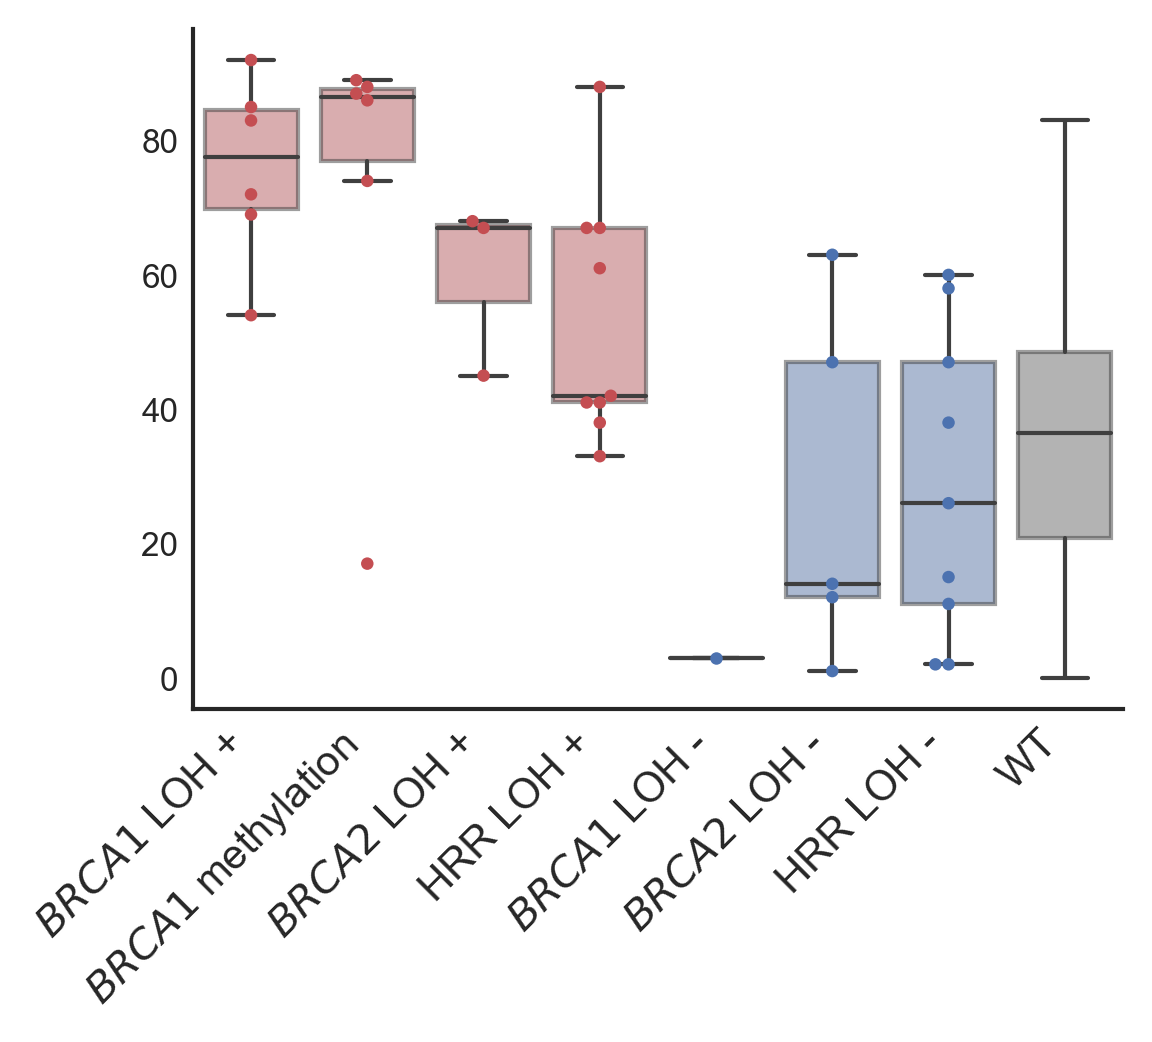

In [1082]:
plt_df=df
cat='BRCA_status'
val='HRD_score_broad'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

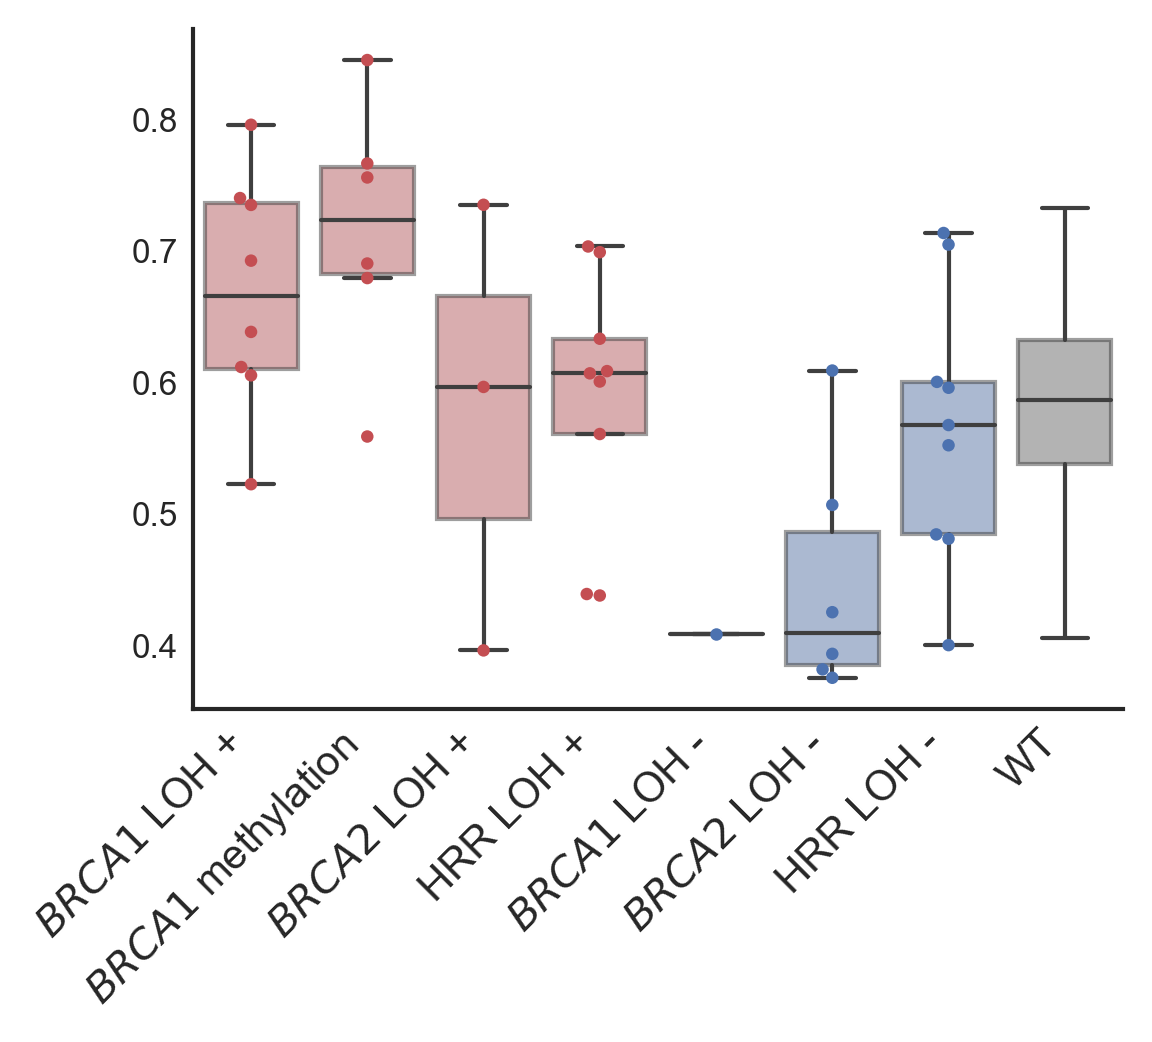

In [1083]:
plt_df=df
cat='BRCA_status'
val='SigMA_broad'
order=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','wt']#'BRCA1_unknown' ]
order2=['BRCA1_LOH','BRCA1_methylation','BRCA2_LOH','HRR_LOH','BRCA1_nonLOH','BRCA2_nonLOH','HRR_nonLOH','']#'BRCA1_unknown' ]
order3=['$BRCA1$ LOH +','$BRCA1$ methylation','$BRCA2$ LOH +','HRR LOH +','$BRCA1$ LOH -','$BRCA2$ LOH -','HRR LOH -','WT']#'BRCA1_unknown' ]

#hue=
palette=['r','r','r','r','b','b','b','dimgrey']
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
#sns.violinplot(x=cat,y=val,data=plt_df,inner="stick",order=order,cut=0,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order2,palette=palette)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.set_xticklabels(order3,rotation=45,fontsize=10,ha='right')
ax.tick_params('y',labelsize=8)

## Genomic scar and Drug sensitivity

In [1084]:
df=df_sel.copy()

In [1085]:
len(drug_all)

882

### HRD score

In [1086]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df[['HRD_score_broad',drug]].dropna()
    a=plt_df['HRD_score_broad'].values
    b=plt_df[drug].values
    n=len(a)
    if n>= 10:
        r,p=stats.spearmanr(a,b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)

In [1087]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs

In [635]:
df_cor=df_cor.dropna()

In [636]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['FDR']=multipletests(df_cor['pvalues'],method='fdr_bh')[1]
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [637]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(856, 8)

In [638]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
PRISM_temsirolimus_BRD-K42898655-001-01-8,51.0,3.588127e-08,0.681959,7.445132,0.000031,1,PI3K/MTOR signaling,6918289
PRISM_abemaciclib_BRD-K33622447-066-01-9,51.0,2.597013e-06,0.604783,5.585526,0.000882,1,Cell cycle,46220502
PRISM_palbociclib_BRD-K51313569-001-07-8,46.0,3.090147e-06,0.627248,5.510021,0.000882,1,Cell cycle,5330286
GDSC1_Temsirolimus_1016,71.0,1.321755e-05,0.491887,4.878849,0.002829,1,PI3K/MTOR signaling,6918289
GDSC2_Palbociclib_1054,69.0,3.896096e-05,0.473946,4.409370,0.006670,1,Cell cycle,5330286
...,...,...,...,...,...,...,...,...
GDSC1_TGX221_94,13.0,4.220666e-02,-0.569464,1.374619,0.275793,1,PI3K/MTOR signaling,9907093
CTRP2_cimetidine_26870,22.0,3.988074e-02,-0.441112,1.399237,0.266702,1,Others,2756
GDSC1_Navitoclax_1011,71.0,2.238452e-02,-0.270757,1.650052,0.208259,1,Apoptosis regulation,24978538
GDSC1_Cyclopamine_17,12.0,1.845272e-02,-0.664336,1.733940,0.199943,1,Others,442972


In [639]:
NP=len(df_cor_p)
NN=len(df_cor_n)

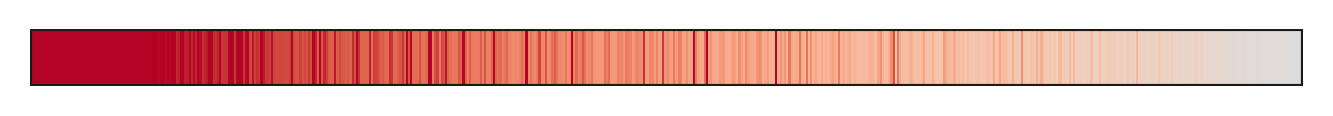

In [640]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

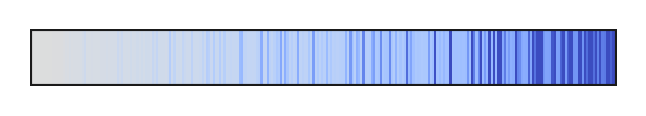

In [641]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

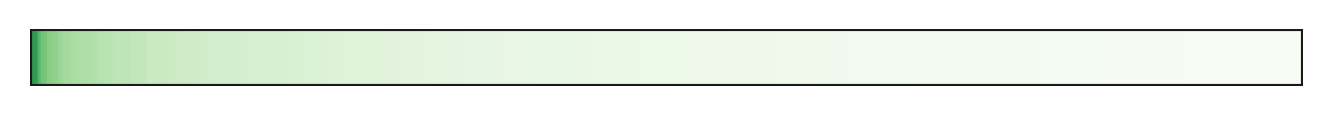

In [642]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

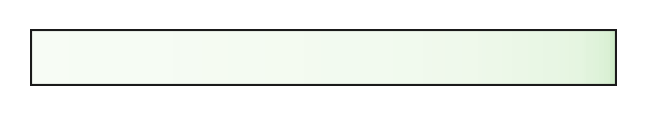

In [643]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

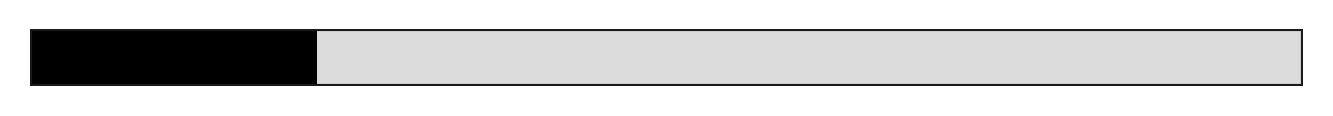

In [644]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

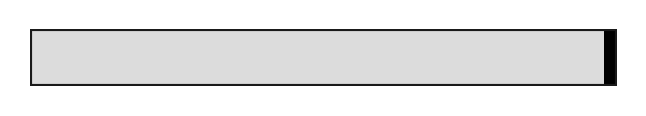

In [645]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [646]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

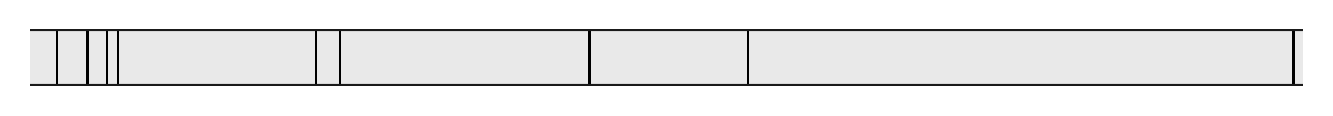

In [647]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

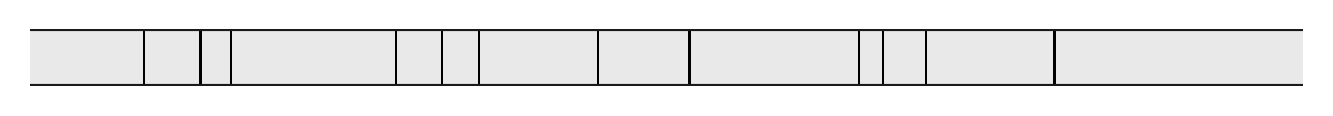

In [648]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [649]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

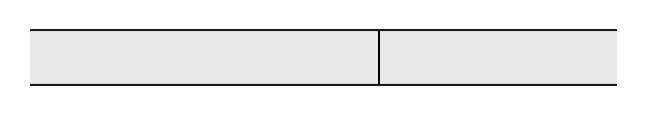

In [650]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

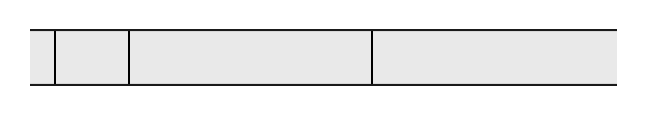

In [651]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [652]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Oxaliplatin_1089,67.0,0.000419,0.418854,3.377486,0.004193,1,Platinum,5310940
GDSC2_Cisplatin_1005,68.0,0.002283,0.363919,2.641421,0.011417,1,Platinum,84691
CTRP2_oxaliplatin_375582,71.0,0.004257,0.335310,2.370910,0.013539,1,Platinum,24197464
GDSC1_Cisplatin_1005,71.0,0.005416,0.326756,2.266346,0.013539,1,Platinum,84691
PRISM_oxaliplatin_BRD-K78960041-001-05-7,49.0,0.049683,0.281945,1.303792,0.097938,1,Platinum,24197464
GDSC2_Oxaliplatin_1806,57.0,0.058763,0.251860,1.230900,0.097938,0,Platinum,5310940
gCSI_Cisplatin_CID24191118,58.0,0.188469,0.175158,0.724760,0.269241,0,Platinum,24191118
PRISM_carboplatin_BRD-K90947825-001-02-7,48.0,0.326072,0.144816,0.486686,0.407591,0,Platinum,426756
CTRP2_carboplatin_26979,72.0,0.996255,0.000563,0.001629,0.996255,0,Platinum,38904
PRISM_cisplatin_BRD-K69172251-001-08-9,47.0,0.498919,-0.101102,0.301970,0.554355,0,Platinum,24191118


In [653]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
GDSC2_Niraparib_1177,57.0,0.007916,0.348370,2.101478,0.118744,1,PARP inhibitor,24958200
GDSC2_Talazoparib_1259,63.0,0.019768,0.293034,1.704040,0.120962,1,PARP inhibitor,44819241
PRISM_talazoparib_BRD-K95142244-001-01-5,51.0,0.024192,0.315348,1.616320,0.120962,1,PARP inhibitor,135565082
GDSC1_Olaparib_1017,71.0,0.073520,0.213717,1.133594,0.275701,0,PARP inhibitor,23725625
PRISM_olaparib_BRD-K02113016-001-19-6,46.0,0.095593,0.248694,1.019575,0.286778,0,PARP inhibitor,23725625
GDSC2_Olaparib_1017,67.0,0.120454,0.191557,0.919180,0.301134,0,PARP inhibitor,23725625
CTRP2_olaparib_411867,74.0,0.195534,0.152181,0.708777,0.419002,0,PARP inhibitor,23725625
GDSC1_Veliparib_1018,71.0,0.263300,0.134540,0.579549,0.493688,0,PARP inhibitor,11960529
GDSC1_Talazoparib_1259,69.0,0.433229,0.095878,0.363282,0.635586,0,PARP inhibitor,44819241
PRISM_niraparib_BRD-K54955827-001-02-2,49.0,0.461107,0.107764,0.336198,0.635586,0,PARP inhibitor,24958200


### Signature 3 broad

In [654]:
ns,rs,ps=[],[],[]
for drug in drug_all:
    plt_df=df[['SigMA_broad',drug]].dropna()
    a=plt_df['SigMA_broad'].values
    b=plt_df[drug].values
    n=len(a)
    if n>= 50:
        r,p=stats.spearmanr(a,b)
        ns.append(n)
        rs.append(r)
        ps.append(p)
    else:
        ns.append(np.nan)
        rs.append(np.nan)
        ps.append(np.nan)

In [655]:
df_cor=pd.DataFrame(index=drug_all)
df_cor['Number']=ns
df_cor['pvalues']=ps
df_cor['rS']=rs

In [656]:
df_cor=df_cor.dropna()

In [657]:
df_cor['mlog10p']=-np.log10(df_cor['pvalues'])
df_cor['FDR']=multipletests(df_cor['pvalues'],method='fdr_bh')[1]
df_cor['significant']=(df_cor['pvalues']<0.05).astype(int)

In [658]:
df_cor=df_cor.merge(drug_anno,left_index=True,right_index=True,how='inner')
df_cor.shape

(543, 8)

In [659]:
df_cor_p=df_cor[df_cor['rS']>=0].sort_values('pvalues')
df_cor_n=df_cor[df_cor['rS']<0].sort_values('pvalues',ascending=False)
df_cor_pn=pd.concat([df_cor_p,df_cor_n])
df_cor_pn

,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
PRISM_temsirolimus_BRD-K42898655-001-01-8,51.0,6.775541e-07,0.631386,6.169056,0.000368,1,PI3K/MTOR signaling,6918289
CTRP2_vorinostat_56554,73.0,6.975187e-04,0.387872,3.156444,0.162775,1,Chromatin-related,5311
CTRP2_LBH-589_54210,75.0,8.993108e-04,0.375562,3.046090,0.162775,1,Chromatin-related,6918837
GDSC2_Uprosertib_1553,72.0,1.450035e-03,0.368448,2.838621,0.196842,1,PI3K/MTOR signaling,51042438
CTRP2_GDC-0941_639759,76.0,1.951961e-03,0.349802,2.709529,0.211983,1,PI3K/MTOR signaling,17755052
...,...,...,...,...,...,...,...,...
GDSC1_XAV939_1268,82.0,6.418729e-02,-0.205363,1.192551,0.633213,0,WNT signaling,2726824
GDSC2_Nelarabine_1814,66.0,5.180156e-02,-0.240455,1.285657,0.625072,0,DNA inhibitor,3011155
gCSI_Vorinostat_CID5311,56.0,4.752945e-02,-0.266004,1.323037,0.600197,1,Chromatin-related,5311
CTRP2_AZD7762_660777,73.0,3.181448e-02,-0.251543,1.497375,0.514504,1,Cell cycle,11152667


In [678]:
# NP=len(df_cor_p)
NN=len(df_cor_n)

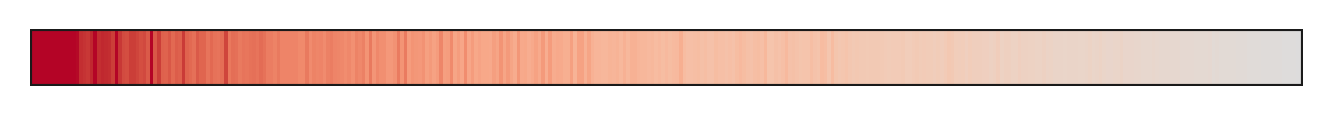

In [660]:
sns_df=df_cor_p[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

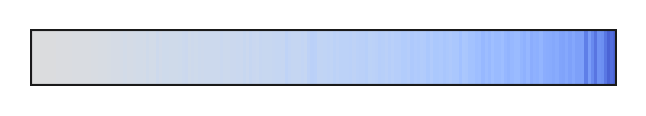

In [661]:
sns_df=df_cor_n[['rS']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=0.3,cmap='coolwarm',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

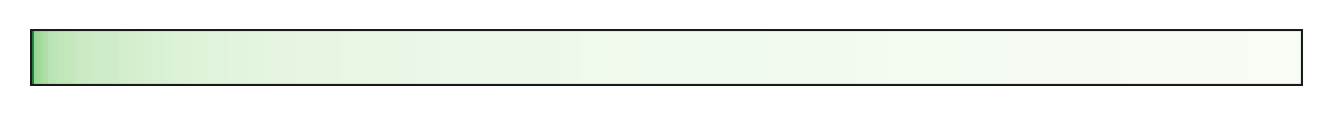

In [662]:
sns_df=df_cor_p[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

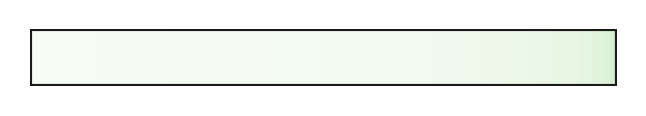

In [663]:
sns_df=df_cor_n[['mlog10p']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=0,vmax=8,cmap='Greens',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

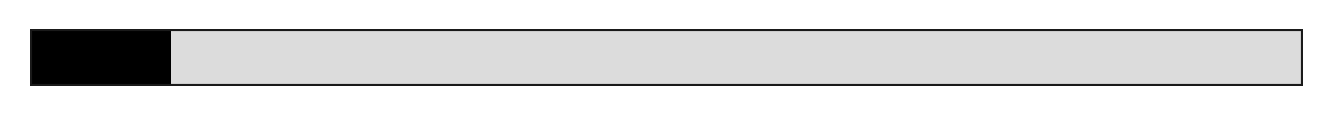

In [664]:
sns_df=df_cor_p[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

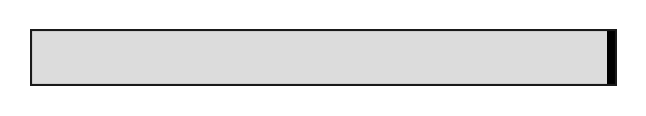

In [665]:
sns_df=df_cor_n[['significant']]
N=sns_df.shape[0]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.3,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [666]:
in_df=pd.get_dummies( df_cor_p['drug_anno'] )

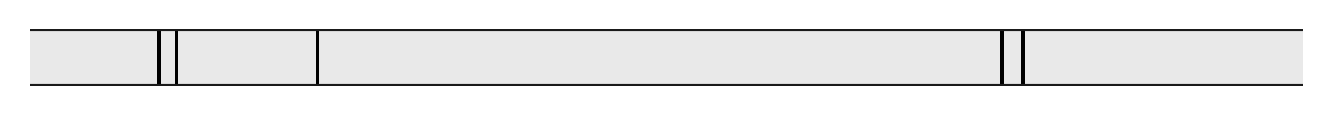

In [667]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

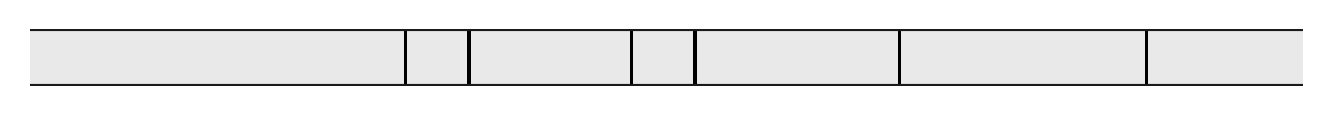

In [668]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NP/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [669]:
in_df=pd.get_dummies( df_cor_n['drug_anno'] )

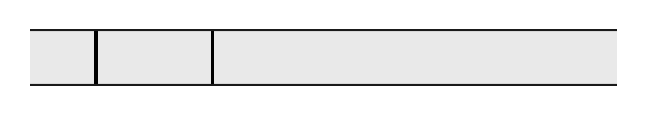

In [670]:
sns_df=in_df[['Platinum']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

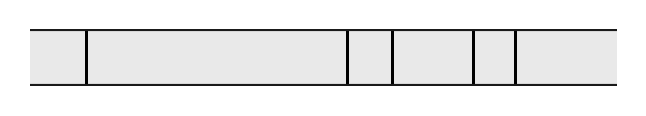

In [671]:
sns_df=in_df[['PARP inhibitor']]
fig=plt.figure(figsize=(8*(NN/(NP+NN)),0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df.T,vmin=-0.2,vmax=1,cmap='Greys',cbar=False,ax=ax,xticklabels=0,yticklabels=0,)
ax.hlines(y=0,xmin=0,xmax=sns_df.shape[0],color='k')
ax.hlines(y=1,xmin=0,xmax=sns_df.shape[0],color='k')
#ax.vlines(x=0,ymin=0,ymax=sns_df.shape[1],color='k')
#ax.vlines(x=sns_df.shape[0],ymin=0,ymax=sns_df.shape[1],color='k')

In [672]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='Platinum']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/1814905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
gCSI_Cisplatin_CID24191118,62.0,0.040138,0.261414,1.396439,0.188613,1,Platinum,24191118
CTRP2_oxaliplatin_375582,72.0,0.053889,0.228171,1.268498,0.188613,0,Platinum,24197464
GDSC2_Oxaliplatin_1089,77.0,0.124181,0.176718,0.905944,0.289756,0,Platinum,5310940
GDSC1_Cisplatin_1005,84.0,0.703646,0.042118,0.152646,0.887179,0,Platinum,84691
GDSC2_Oxaliplatin_1806,66.0,0.723594,0.044359,0.140505,0.887179,0,Platinum,5310940
GDSC2_Cisplatin_1005,78.0,0.927942,-0.010407,0.032479,0.927942,0,Platinum,84691
CTRP2_carboplatin_26979,73.0,0.760439,-0.036301,0.118935,0.887179,0,Platinum,38904


In [673]:
tmp_df=df_cor_pn[df_cor_pn['drug_anno']=='PARP inhibitor']
tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]
tmp_df

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_12083/188230088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['FDR']=multipletests(tmp_df['pvalues'],method='fdr_bh')[1]


,Number,pvalues,rS,mlog10p,FDR,significant,drug_anno,cid
PRISM_talazoparib_BRD-K95142244-001-01-5,51.0,0.179022,0.191164,0.747093,0.749682,0,PARP inhibitor,135565082
GDSC1_Veliparib_1018,84.0,0.241886,0.129088,0.616389,0.749682,0,PARP inhibitor,11960529
GDSC2_Niraparib_1177,65.0,0.378274,0.111101,0.422193,0.749682,0,PARP inhibitor,24958200
CTRP2_olaparib_411867,75.0,0.450553,0.088436,0.346254,0.749682,0,PARP inhibitor,23725625
GDSC2_Talazoparib_1259,72.0,0.613376,0.060551,0.212273,0.749682,0,PARP inhibitor,44819241
GDSC1_Olaparib_1017,84.0,0.822780,0.024805,0.084716,0.905058,0,PARP inhibitor,23725625
GDSC1_Rucaparib_1175,82.0,0.939894,-0.008457,0.026921,0.939894,0,PARP inhibitor,9931953
GDSC2_Olaparib_1017,77.0,0.567320,-0.066197,0.246172,0.749682,0,PARP inhibitor,23725625
GDSC1_Talazoparib_1259,81.0,0.506407,-0.074887,0.295500,0.749682,0,PARP inhibitor,44819241
CTRP2_veliparib_606034,74.0,0.346916,-0.110891,0.459776,0.749682,0,PARP inhibitor,11960529


# ROARMAP

In [679]:
rm=pd.read_excel('../data/roadmaps_12-14-2021.xlsx')
rm['stripped_name']=[x.replace('_','').replace('-','').replace('/','').replace(' ','') for x in rm['Tumor Model']]
rm['stripped_name']=rm['stripped_name'].replace({'A549ATCC':'A549','A549(ASC)1':'A549',
                                                 '7860':'786O','HelaLUC':'HELA'})
rm['Drug_route']=[x+'_'+y for x,y in zip(rm['Generic Name'],rm['Admin Route'])]

In [680]:
a=set(rm['stripped_name'])
b=set(df0['stripped_cell_line_name'])
len( a&b )

72

In [685]:
counter=Counter(rm['Drug_route']).most_common()
drugs=[x[0] for x in counter[0:10]]
drugs

['Cyclophosphamide_IP',
 'Cisplatin_IP',
 'Paclitaxel_IV',
 'Fluorouracil_IP',
 'Methotrexate_IP',
 'Dacarbazine_IP',
 'Dactinomycin_IP',
 'Bleomycin_IP',
 'Vinblastine_IP',
 'Carmustine_IP']

45 Cisplatin_IP 45 0.4124308909827742
45.0 36.0


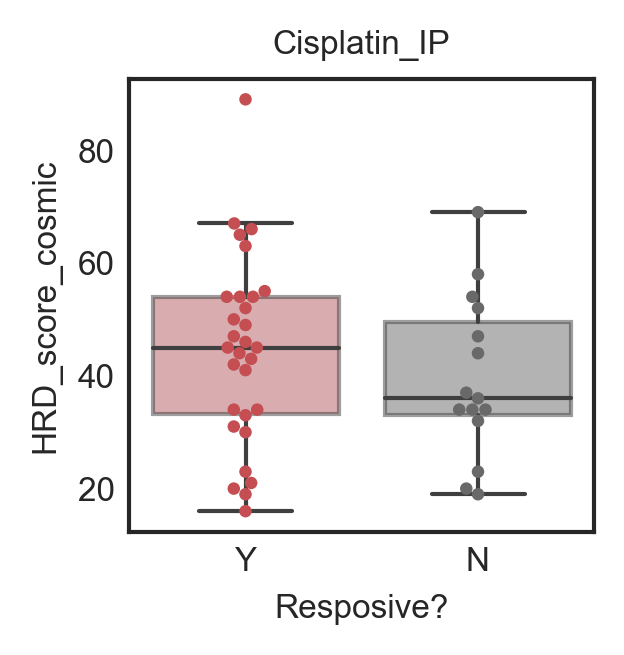

In [686]:
drug='Cisplatin_IP'
add=rm[rm['Drug_route']==drug]
df_add=df2.merge(add, left_on='stripped_cell_line_name',right_on='stripped_name',how='inner')
df_add=df_add.sort_values('Resposive?',ascending=True)
df_add=df_add[~df_add['stripped_name'].duplicated()]
plt_df=df_add#[~df_add[['stripped_name',cat]].duplicated()]
cat='Resposive?'
val='HRD_score_cosmic'
order=['Y','N']
#hue=
palette=['r','dimgrey']
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(1,1,1)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order,dodge=True,palette=palette)
ax.set_xlabel(cat)
ax.set_title(drug)
ax.tick_params(labelsize=8)

a=plt_df[plt_df[cat]=='Y'][val].dropna().values
b=plt_df[plt_df[cat]=='N'][val].dropna().values
r,p=stats.mannwhitneyu(a,b)
print(len(plt_df), drug,len(plt_df),p)

print( np.median(a),np.median(b) )

47 Cisplatin_IP 47 0.44455182146463057
0.625475965962196 0.558120321902762


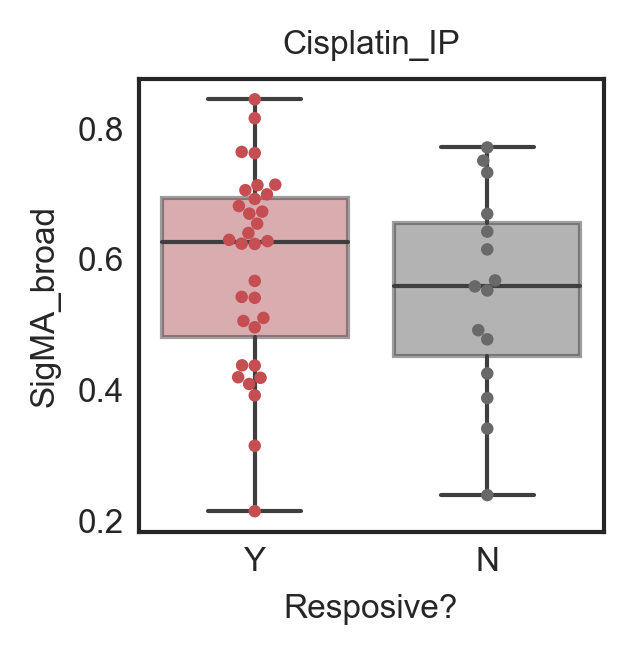

In [688]:
drug='Cisplatin_IP'
add=rm[rm['Drug_route']==drug]
df_add=df0.merge(add, left_on='stripped_cell_line_name',right_on='stripped_name',how='inner')
df_add=df_add.sort_values('Resposive?',ascending=True)
df_add=df_add[~df_add['stripped_name'].duplicated()]
plt_df=df_add#[~df_add[['stripped_name',cat]].duplicated()]
cat='Resposive?'
val='SigMA_broad'
order=['Y','N']
#hue=
palette=['r','dimgrey']
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(1,1,1)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=3,order=order,dodge=True,palette=palette)
ax.set_xlabel(cat)
ax.set_title(drug)
ax.tick_params(labelsize=8)

a=plt_df[plt_df[cat]=='Y'][val].dropna().values
b=plt_df[plt_df[cat]=='N'][val].dropna().values

r,p=stats.mannwhitneyu(a,b)
print(len(plt_df), drug,len(plt_df),p)

print( np.median(a),np.median(b) )

# BCaPE

In [703]:
drug=pd.read_csv('../data/DrugResponsesAUCSamples.txt',sep='\t')

In [704]:
dict_sid_drug_auc={}
for idx in drug.index:
    sid=drug.loc[idx,'ID']
    did=drug.loc[idx,'Drug']
    auc=drug.loc[idx,'AUC']
    if sid not in dict_sid_drug_auc:
        dict_sid_drug_auc[sid]={}
    else:
        dict_sid_drug_auc[sid][did]=auc

In [705]:
import re
auc=pd.DataFrame(dict_sid_drug_auc).T
auc['ModelName']=[x.split('-')[0] for x in auc.index]
auc.index=[re.sub('CR$','R',x) for x in auc.index]
auc.index=[re.sub('C$','', x) for x in auc.index]

In [706]:
dict_did_dname={'AZD2281':'Olaparib','AG-014699':'Rucaparib'}
auc=auc.rename(columns=dict_did_dname)

In [707]:
sigma=pd.read_csv('../data//Cell2016_sigMA.csv').iloc[:,96:]
sigma=sigma.set_index('tumor')
sigma.index=[x.split('//')[1].replace('.maf','') for x in sigma.index]
sigma=sigma.sort_index()
sigma['splitID']=[x.split('-')[0] for x in sigma.index]

In [708]:
auc_sigma=auc.merge(sigma,left_index=True,right_index=True,how='inner')

19
r = -0.430, p = 6.60e-02
SpearmanrResult(correlation=-0.41578947368421054, pvalue=0.07664058021073578)


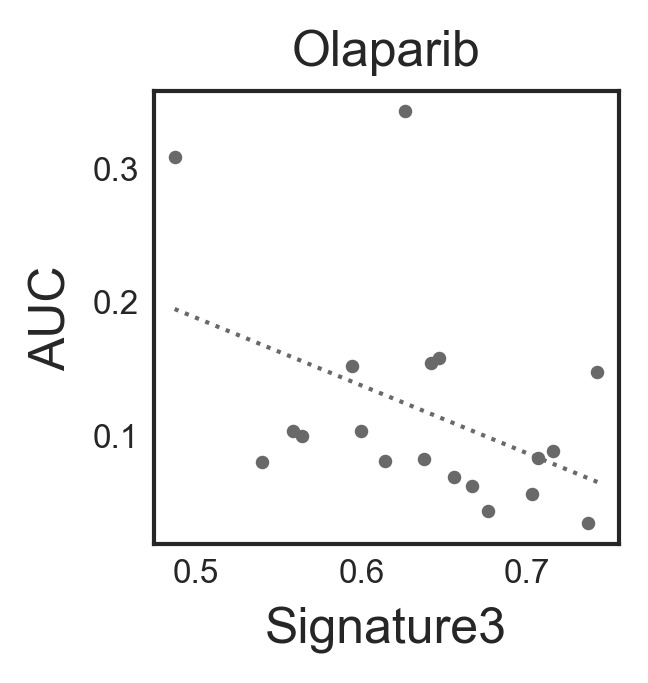

In [709]:
plt_df=auc_sigma.copy()
val1,val2='Signature_3_c','Olaparib'
plt_df=plt_df[[val1,val2]].dropna()
print(len(plt_df))
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=5,c='dimgray')
ax.set_xlabel('Signature3',fontsize=12)
ax.set_ylabel('AUC',fontsize=12)
ax.set_title(val2,fontsize=12)
ax.tick_params(labelsize=8)

lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
X=np.array([min(x),max(x)])
ax.plot(X,a*X+b,lw=1,c='dimgray',ls='dotted')
print('r = {:.3f}, p = {:.2e}'.format(r,p))

print( stats.spearmanr(x,y,nan_policy='omit') )

13
r = -0.406, p = 1.69e-01
SpearmanrResult(correlation=-0.2087912087912088, pvalue=0.493621819356885)


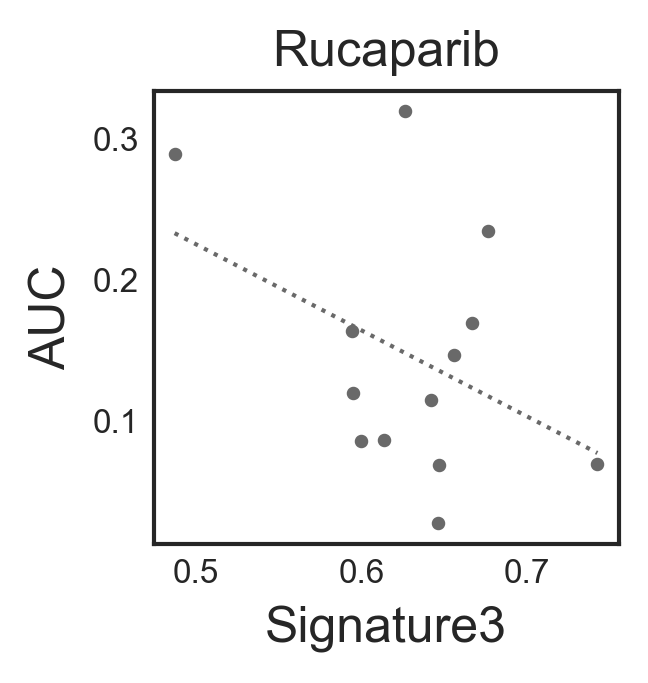

In [710]:
plt_df=auc_sigma.copy()
val1,val2='Signature_3_c','Rucaparib'
plt_df=plt_df[[val1,val2]].dropna()
print(len(plt_df))
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=5,c='dimgray')
ax.set_xlabel('Signature3',fontsize=12)
ax.set_ylabel('AUC',fontsize=12)
ax.set_title(val2,fontsize=12)
ax.tick_params(labelsize=8)

lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
X=np.array([min(x),max(x)])
ax.plot(X,a*X+b,lw=1,c='dimgray',ls='dotted')
print('r = {:.3f}, p = {:.2e}'.format(r,p))

print( stats.spearmanr(x,y,nan_policy='omit') )